### Table of Contents

* [1. Préparation du notebook](#chapter1)


* [2. Chargement et description des données](#chapter2)

    * [2.1 Dataset `application_train`](#section2.1)
    
        * [2.1.1 Description du dataset `application_train`](#section2.1.1)
        
        * [2.1.2 Distribution de la variable `TARGET`](#section2.1.2)
    
    * [2.2 Dataset `application_test`](#section2.2)
    
    * [2.3 Dataset `bureau`](#section2.3)
    
    * [2.4 Dataset `previous_application`](#section2.4)

    * [2.5 Dataset `POS_CASH_balance`](#section2.5)
    
    * [2.6 Dataset `installments_payments`](#section2.6)
    
    * [2.7 Dataset `credit_card_balance`](#section2.7)
   
* [3. Feature selection par LightGBM](#chapter3)

    * [3.1 Supprimer quelques colonnes non pertinentes pour la segmentation](#section_3.1)
    
    * [3.2 Changer les types des variables temps](#section_3.2)
    
* [4. Analyse univariée de features sélectionné par LightGBM](#chapter4)

    * [4.1 Analyses univariées des variables utilisées pour la segmentation](#section_4.1)
        
        * [4.1.1 Analyse des variables RFM](#section_4.1.1)
    
        * [4.1.2 Analyse des variables qui peuvent être utiles pour la segmentation](#section_4.1.2)
    
    * [4.2 Analyses bivariées des variables utilisées pour la segmentation](#section_4.2)
    


# 1. Préparation du notebook <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#import missingno as msn

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as st

import math

import random

import timeit

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GroupKFold # StratifiedGroupKFold

from sklearn import model_selection

import datetime

#import squarify

from colorama import Fore, Back, Style

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def namestr(obj, namespace): 
    return [name for name in namespace if namespace[name] is obj]



font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,}

def missing_cells(data):
    return data.isna().sum().sum()

def missing_cells_percent(data):
    return data.isna().sum().sum()*100/(data.size)

def summary_columns(data):
    summary = pd.DataFrame(columns=['Variable name', 'Variable type', 'Missing values', '% Missing'])
    summary['Variable name'] = data.columns
    summary['Variable type'] = list(pd.DataFrame(data.dtypes)[0])
    missing = list()
    percent_missing = list()
    for var in data.columns:
        nb_missing = missing_cells(data[var])
        pc_missing = missing_cells_percent(data[var])
        missing.append(nb_missing)
        percent_missing.append(pc_missing)
    summary['Missing values'] = list(missing)
    summary['% Missing'] = list(percent_missing)
    
    # On range de manière décroissante 
    summary = summary[summary.iloc[:,1] != 0].sort_values('% Missing', ascending=False).round(1)
    
    return summary

def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
    '''
    #checking if there is any column with NaNs or not.
    if df_nan['% Missing'].sum() != 0:
        print(f"Le nombre de colonnes ayant Nan : {df_nan[df_nan['% Missing'] != 0].shape[0]} colonnes")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'Variable name', y = '% Missing', data = df_nan[df_nan['% Missing'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"Le dataset {title_name} ne contient pas de NaN.")

def description_dataset(data, name):
    ''' Return the description of a dataset
            Parameters: data: dataframe
                        name: 
            
            Returns: the 3 first line of the dataframe
                     the shape, the types, the number of null values,
                     the number of unique values, the number of duplicated values
            '''
    print('=='*20 + name + '=='*20 )
    print('\n')
    
    print(f'Taille :  {data.shape}')
    print('\n')
    
    print(Fore.RED + "Valeurs différentes par variables : ")
    print(Style.RESET_ALL)
    for col in data:
        if data[col].nunique() < 30:
            print (f'{col} ( type de variable : {data[col].dtype} ) : {data[col].unique()}')
        else : 
            print(f'{col} ( type de variable : {data[col].dtype} ) contient {data[col].nunique()} valeurs différentes')
    print('\n')
    
    print(f"Nombre de doublons : {data.duplicated().sum()}")
    print('\n')
    
    print("Valeurs manquantes par colonnes (%): ")
    table = summary_columns(data)
    display(table.head(50))
    print('\n')

    plot_nan_percent(table, name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90)

# Fonction pour supprimer les doublons de lignes dans une dataframe
def drop_doublons(data):
    
    # Création d'une variable indiquant la présence de lignes dupliquées dans la dataframe
    nbre_lignes_dupliq_av = data[data.duplicated(keep=False)] 
    
    print("Liste des lignes dupliquées pour chaque colonne de la dataframe :")
    display(nbre_lignes_dupliq_av)
    
    # Suppression des valeurs dupliquées
    data.drop_duplicates(keep="first", inplace=True)
    
    # Création d'une variable indiquant la présence de lignes dupliquées dans la dataframe
    nbre_lignes_dupliq_ap = data[data.duplicated(keep=False)] 

    return nbre_lignes_dupliq_ap

In [3]:
def chargement_dataset(chemin):
    data = pd.read_csv(chemin, sep=',', low_memory=False)
    display(data.head())
    print(data.info())
    return data

def merge_dataset(data1, data2, col):
    data1 = data1.merge(data2, on=col, how='left')
    display(data1.head())
    print(data1.info())
    return data1

In [4]:
def plots_uniVariable(monData, var, title1, title2, title3):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
    fig.suptitle(title1)

    sns.histplot(ax=axes[0], x=var, hue="TARGET", data=monData, kde=True)
    axes[0].set_title(title2)

    sns.boxplot(ax=axes[1], x=var, hue="TARGET", data=monData)
    axes[1].set_title(title3)

    plt.show()
    return

In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# 2. Chargement et description des données <a class="anchor" id="chapter2"></a>

Les données **Home Credit** sont disponibles à l'adresse suivante: https://www.kaggle.com/c/home-credit-default-risk/data 

Le jeu de données contient 7 tables, plus une table des descriptions des différentes variables.

 - application_{train|test}.csv : 
  -  Il s’agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Ce sont des données statiques pour toutes les applications. 
  -  Une ligne représente un prêt dans l'échantillon de données, identifié par la variable `SK_ID_CURR`.
  -  La variable `TARGET` contient, soit la valeur 0 (le prêt a été remboursé à temps), soit la valeur 1 (le prêt n'a pas été remboursé à temps).

 - bureau.csv :
  -  Tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans l'échantillon).
  -  Pour chaque prêt de l'échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.

 - bureau_balance.csv :
  -  Soldes mensuels des crédits précédents au Credit Bureau.
  -  Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a contient des lignes correspondant à X prêts dans l'échantillon multipliés par Y crédits précédents relatifs à Z mois où nous avons un historique observable pour les crédits précédents.

 - POS_CASH_balance.csv :
  -  Instantanés du solde mensuel des POS (points de vente) précédents et des prêts en espèces que le demandeur avait avec Home Credit.
  -  Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit précédent dans le crédit immobilier (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a contient des lignes correspondant à X prêts dans l'échantillon multipliés par Y crédits précédents relatifs à Z mois où nous avons un historique observable pour les crédits précédents.

 - credit_card_balance.csv :
  -  Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.
  -  Ce tableau a une ligne pour chaque mois d’historique de chaque crédit précédent dans le crédit immobilier (crédit à la consommation et prêts de trésorerie) lié aux prêts dans notre échantillon - c’est-à-dire que le tableau a (#loans dans l’échantillon * # de cartes de crédit antérieures relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

 - previous_application.csv :
  -  Toutes les demandes précédentes de prêts de crédit immobilier de clients qui ont des prêts dans notre échantillon.
  -  Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. Chaque prêt en cours dans l'application (application_train/test) peut avoir plusieurs des demandes/prêts antérieur(e)s. Chaque demande de prêt antérieure est identifiée par la variable `SK_ID_PREV`.

 - installments_payments.csv :
  -  Historique de remboursement des crédits précédemment décaissés en Home Credit  liés aux prêts de notre échantillon.
  -  Il y a une ligne pour chaque paiement effectué plus une ligne pour chaque paiement manqué.
  -  Une ligne équivaut à un versement d’un versement ou à un versement correspondant à un versement d’un crédit immobilier précédent lié à des prêts de notre échantillon.

 - HomeCredit_columns_description.csv :
   -  Ce fichier contient les descriptions des colonnes des différents fichiers de données.

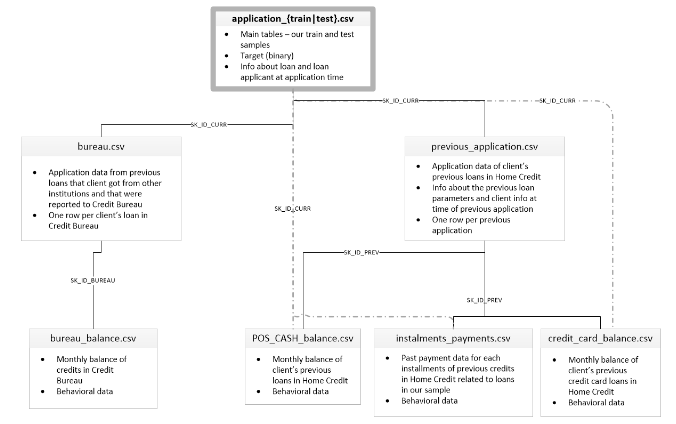

## 2.1 Dataset `application_train` <a class="anchor" id="section2.1"></a>

In [31]:
application_train = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\application_train.csv')


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


L'identifiant de ce dataset est la variable `SK_ID_CURR`.

La variable `TARGET` représente la status pour la défaillance de crédit: 0 pour les emprunteurs non défaillants, 1 pour les emprunteurs défaillances.

### 2.1.1 Description du dataset `application_train` <a class="anchor" id="section2.1.1"></a>

========================================Dataset application_train========================================


Taille :  (307511, 122)


Valeurs différentes par variables : 

SK_ID_CURR ( type de variable : int64 ) contient 307511 valeurs différentes
TARGET ( type de variable : int64 ) : [1 0]
NAME_CONTRACT_TYPE ( type de variable : object ) : ['Cash loans' 'Revolving loans']
CODE_GENDER ( type de variable : object ) : ['M' 'F' 'XNA']
FLAG_OWN_CAR ( type de variable : object ) : ['N' 'Y']
FLAG_OWN_REALTY ( type de variable : object ) : ['Y' 'N']
CNT_CHILDREN ( type de variable : int64 ) : [ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
AMT_INCOME_TOTAL ( type de variable : float64 ) contient 2548 valeurs différentes
AMT_CREDIT ( type de variable : float64 ) contient 5603 valeurs différentes
AMT_ANNUITY ( type de variable : float64 ) contient 13672 valeurs différentes
AMT_GOODS_PRICE ( type de variable : float64 ) contient 1002 valeurs différentes
NAME_TYPE_SUITE ( type de variable : object

OBS_30_CNT_SOCIAL_CIRCLE ( type de variable : float64 ) contient 33 valeurs différentes
DEF_30_CNT_SOCIAL_CIRCLE ( type de variable : float64 ) : [ 2.  0.  1. nan  3.  4.  5.  6.  7. 34.  8.]
OBS_60_CNT_SOCIAL_CIRCLE ( type de variable : float64 ) contient 33 valeurs différentes
DEF_60_CNT_SOCIAL_CIRCLE ( type de variable : float64 ) : [ 2.  0.  1. nan  3.  5.  4.  7. 24.  6.]
DAYS_LAST_PHONE_CHANGE ( type de variable : float64 ) contient 3773 valeurs différentes
FLAG_DOCUMENT_2 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_3 ( type de variable : int64 ) : [1 0]
FLAG_DOCUMENT_4 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_5 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_6 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_7 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_8 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_9 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_10 ( type de variable : int64 ) : [0 1]
FLAG_DOCUMENT_11 ( type de variable : int64 ) : [0 1]


Variable name Variable type  Missing values  % Missing
76               COMMONAREA_MEDI       float64          214865       69.9
48                COMMONAREA_AVG       float64          214865       69.9
62               COMMONAREA_MODE       float64          214865       69.9
70      NONLIVINGAPARTMENTS_MODE       float64          213514       69.4
56       NONLIVINGAPARTMENTS_AVG       float64          213514       69.4
84      NONLIVINGAPARTMENTS_MEDI       float64          213514       69.4
86            FONDKAPREMONT_MODE        object          210295       68.4
68         LIVINGAPARTMENTS_MODE       float64          210199       68.4
54          LIVINGAPARTMENTS_AVG       float64          210199       68.4
82         LIVINGAPARTMENTS_MEDI       float64          210199       68.4
52                 FLOORSMIN_AVG       float64          208642       67.8
66                FLOORSMIN_MODE       float64          208642       67.8
80                FLOORSMIN_MEDI       float64          208642       67.8
75              YEARS_BUILD_MEDI       float64          204488       66.5
61              YEARS_BUILD_MODE       float64          204488       66.5
47               YEARS_BUILD_AVG       float64          204488       66.5
21                   OWN_CAR_AGE       float64          202929       66.0
81                 LANDAREA_MEDI       float64          182590       59.4
67                 LANDAREA_MODE       float64          182590       59.4
53                  LANDAREA_AVG       float64          182590       59.4
73             BASEMENTAREA_MEDI       float64          179943       58.5
45              BASEMENTAREA_AVG       float64          179943       58.5
59             BASEMENTAREA_MODE       float64          179943       58.5
41                  EXT_SOURCE_1       float64          173378       56.4
71            NONLIVINGAREA_MODE       float64          169682       55.2
57             NONLIVINGAREA_AVG       float64          169682       55.2
85            NONLIVINGAREA_MEDI       float64          169682       55.2
77                ELEVATORS_MEDI       float64          163891       53.3
49                 ELEVATORS_AVG       float64          163891       53.3
63                ELEVATORS_MODE       float64          163891       53.3
89            WALLSMATERIAL_MODE        object          156341       50.8
72               APARTMENTS_MEDI       float64          156061       50.7
44                APARTMENTS_AVG       float64          156061       50.7
58               APARTMENTS_MODE       float64          156061       50.7
78                ENTRANCES_MEDI       float64          154828       50.3
50                 ENTRANCES_AVG       float64          154828       50.3
64                ENTRANCES_MODE       float64          154828       50.3
55                LIVINGAREA_AVG       float64          154350       50.2
69               LIVINGAREA_MODE       float64          154350       50.2
83               LIVINGAREA_MEDI       float64          154350       50.2
87                HOUSETYPE_MODE        object          154297       50.2
65                FLOORSMAX_MODE       float64          153020       49.8
79                FLOORSMAX_MEDI       float64          153020       49.8
51                 FLOORSMAX_AVG       float64          153020       49.8
60  YEARS_BEGINEXPLUATATION_MODE       float64          150007       48.8
74  YEARS_BEGINEXPLUATATION_MEDI       float64          150007       48.8
46   YEARS_BEGINEXPLUATATION_AVG       float64          150007       48.8
88                TOTALAREA_MODE       float64          148431       48.3
90           EMERGENCYSTATE_MODE        object          145755       47.4
28               OCCUPATION_TYPE        object           96391       31.3



Le nombre de colonnes ayant Nan : 64 colonnes


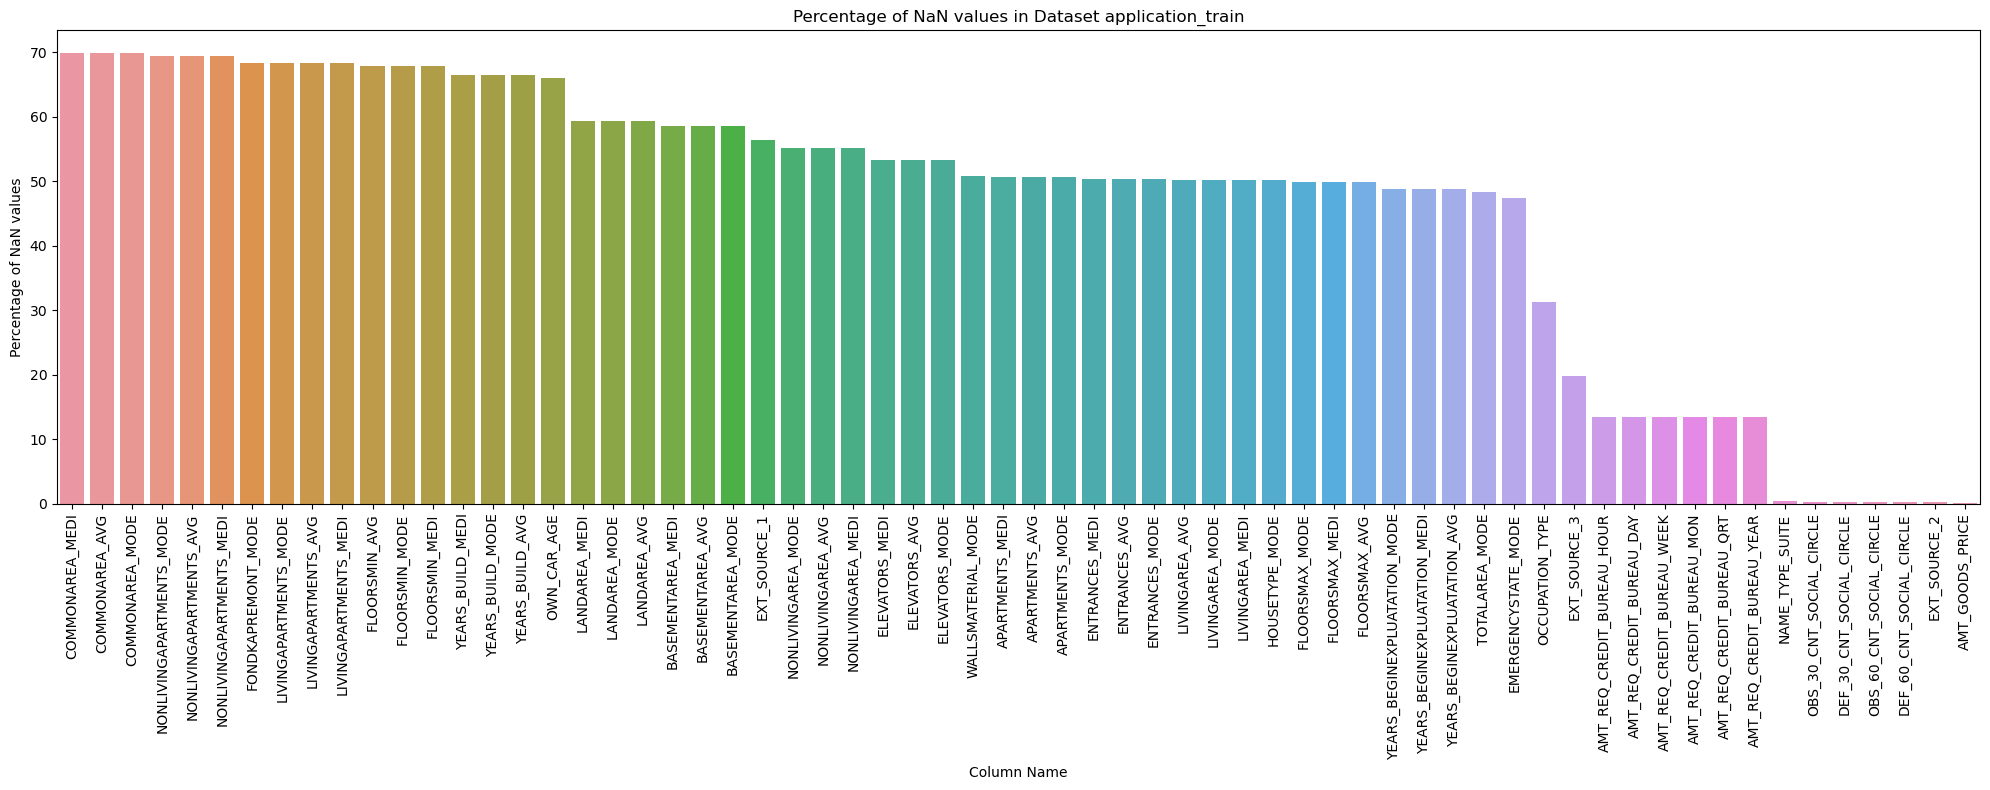

In [11]:
description_dataset(application_train, "Dataset application_train")


### 2.1.2 Distribution de la variable `TARGET` <a class="anchor" id="section2.1.2"></a>

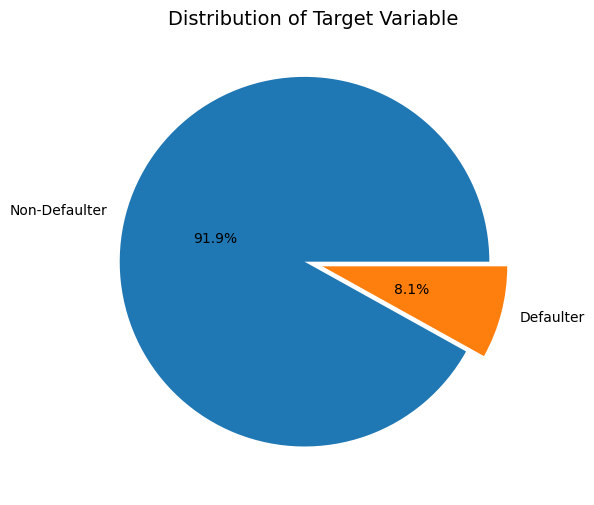

In [10]:
# Affichage de la distribution de la variable "TARGET"
#target_distribution = application_train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=application_train['TARGET'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Distribution of Target Variable", fontsize=14);


La distribution de la variable cible est très déséquilibrée des données. Il n'y a que 8, 8,1 % du total des prêts qui ont effectivement été en défaut ( valeur 1). 

## 2.2 Dataset `application_test` <a class="anchor" id="section2.2"></a> 

In [32]:
application_test = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\application_test.csv')


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


Les variables sont les mêmes que sur le dataset **application_train**, mais il n'y pas de variable `TARGET`, les valeurs de cette variable doivent être prédites par des modèles de classification de Machine Learning.

L'identifiant de ce dataset est la variable `SK_ID_CURR`.

### 2.2.1 Description du dataset `application_test` <a class="anchor" id="section2.2.1"></a>

========================================Dataset application_test========================================


Taille :  (48744, 121)


Valeurs différentes par variables : 

SK_ID_CURR ( type de variable : int64 ) contient 48744 valeurs différentes
NAME_CONTRACT_TYPE ( type de variable : object ) : ['Cash loans' 'Revolving loans']
CODE_GENDER ( type de variable : object ) : ['F' 'M']
FLAG_OWN_CAR ( type de variable : object ) : ['N' 'Y']
FLAG_OWN_REALTY ( type de variable : object ) : ['Y' 'N']
CNT_CHILDREN ( type de variable : int64 ) : [ 0  2  1  3  8  4  6  5  7 20 11]
AMT_INCOME_TOTAL ( type de variable : float64 ) contient 606 valeurs différentes
AMT_CREDIT ( type de variable : float64 ) contient 2937 valeurs différentes
AMT_ANNUITY ( type de variable : float64 ) contient 7491 valeurs différentes
AMT_GOODS_PRICE ( type de variable : float64 ) contient 677 valeurs différentes
NAME_TYPE_SUITE ( type de variable : object ) : ['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of peopl

Nombre de doublons : 0


Valeurs manquantes par colonnes (%): 


Variable name Variable type  Missing values  % Missing
47                COMMONAREA_AVG       float64           33495       68.7
61               COMMONAREA_MODE       float64           33495       68.7
75               COMMONAREA_MEDI       float64           33495       68.7
55       NONLIVINGAPARTMENTS_AVG       float64           33347       68.4
69      NONLIVINGAPARTMENTS_MODE       float64           33347       68.4
83      NONLIVINGAPARTMENTS_MEDI       float64           33347       68.4
85            FONDKAPREMONT_MODE        object           32797       67.3
53          LIVINGAPARTMENTS_AVG       float64           32780       67.2
67         LIVINGAPARTMENTS_MODE       float64           32780       67.2
81         LIVINGAPARTMENTS_MEDI       float64           32780       67.2
79                FLOORSMIN_MEDI       float64           32466       66.6
51                 FLOORSMIN_AVG       float64           32466       66.6
65                FLOORSMIN_MODE       float64           32466       66.6
20                   OWN_CAR_AGE       float64           32312       66.3
46               YEARS_BUILD_AVG       float64           31818       65.3
74              YEARS_BUILD_MEDI       float64           31818       65.3
60              YEARS_BUILD_MODE       float64           31818       65.3
80                 LANDAREA_MEDI       float64           28254       58.0
52                  LANDAREA_AVG       float64           28254       58.0
66                 LANDAREA_MODE       float64           28254       58.0
72             BASEMENTAREA_MEDI       float64           27641       56.7
44              BASEMENTAREA_AVG       float64           27641       56.7
58             BASEMENTAREA_MODE       float64           27641       56.7
56             NONLIVINGAREA_AVG       float64           26084       53.5
70            NONLIVINGAREA_MODE       float64           26084       53.5
84            NONLIVINGAREA_MEDI       float64           26084       53.5
62                ELEVATORS_MODE       float64           25189       51.7
76                ELEVATORS_MEDI       float64           25189       51.7
48                 ELEVATORS_AVG       float64           25189       51.7
88            WALLSMATERIAL_MODE        object           23893       49.0
57               APARTMENTS_MODE       float64           23887       49.0
71               APARTMENTS_MEDI       float64           23887       49.0
43                APARTMENTS_AVG       float64           23887       49.0
86                HOUSETYPE_MODE        object           23619       48.5
63                ENTRANCES_MODE       float64           23579       48.4
49                 ENTRANCES_AVG       float64           23579       48.4
77                ENTRANCES_MEDI       float64           23579       48.4
82               LIVINGAREA_MEDI       float64           23552       48.3
68               LIVINGAREA_MODE       float64           23552       48.3
54                LIVINGAREA_AVG       float64           23552       48.3
50                 FLOORSMAX_AVG       float64           23321       47.8
78                FLOORSMAX_MEDI       float64           23321       47.8
64                FLOORSMAX_MODE       float64           23321       47.8
45   YEARS_BEGINEXPLUATATION_AVG       float64           22856       46.9
73  YEARS_BEGINEXPLUATATION_MEDI       float64           22856       46.9
59  YEARS_BEGINEXPLUATATION_MODE       float64           22856       46.9
87                TOTALAREA_MODE       float64           22624       46.4
89           EMERGENCYSTATE_MODE        object           22209       45.6
40                  EXT_SOURCE_1       float64           20532       42.1
27               OCCUPATION_TYPE        object           15605       32.0



Le nombre de colonnes ayant Nan : 62 colonnes


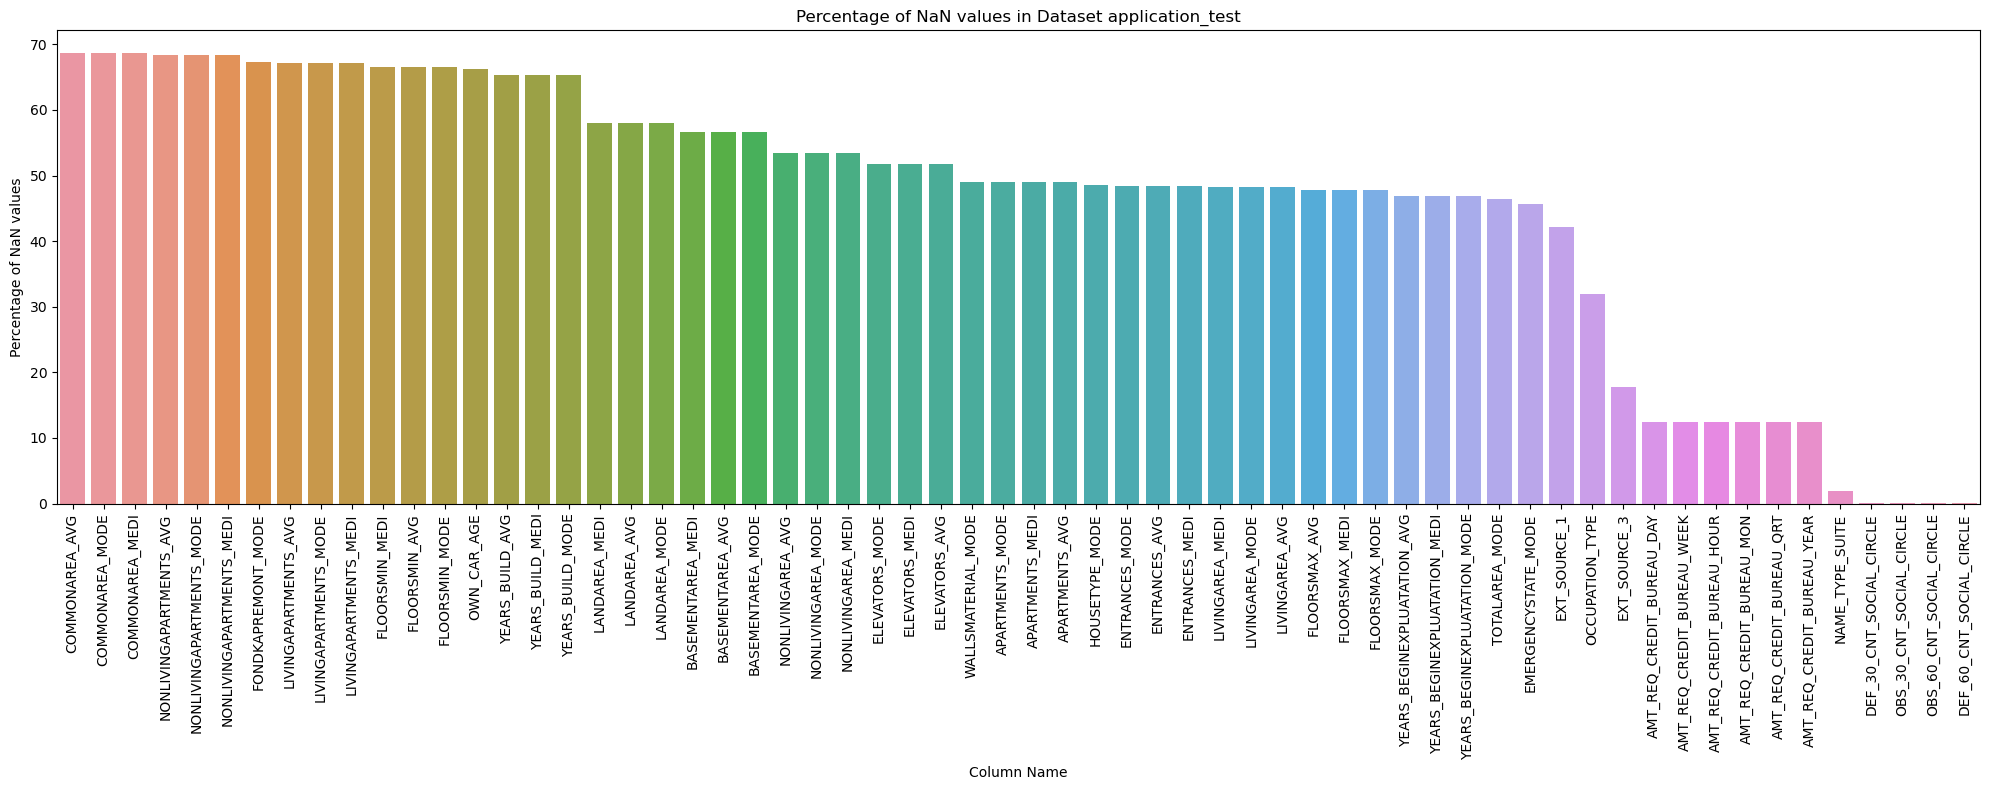

In [14]:
description_dataset(application_test, "Dataset application_test")


Il y a un nombre très similaire de colonnes avec des valeurs NaN (64) et leur poucentage de valeur NaN comme dans le dataset **application_train**.

On regroupe les deux datasets `application_train` et `application_test` pour la préparation du dataset final.

In [33]:
data = application_train.append(application_test)
data.shape

(356255, 122)

In [34]:
# Remove 4 applications with XNA CODE_GENDER (train set)
data = data[data['CODE_GENDER'] != 'XNA']

In [35]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
data = data[data['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

# Some simple new features (percentages)
data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    
# Flag_document features - count and kurtosis
docs = [f for f in data.columns if 'FLAG_DOC' in f]
data['DOCUMENT_COUNT'] = data[docs].sum(axis=1)
data['NEW_DOC_KURT'] = data[docs].kurtosis(axis=1)

In [36]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    print(feature_name)

EXT_SOURCES_MIN
EXT_SOURCES_MAX
EXT_SOURCES_MEAN
EXT_SOURCES_NANMEDIAN
EXT_SOURCES_VAR


In [37]:
# New features based on External sources
data['EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['EXT_SOURCES_WEIGHTED'] = data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 1 + data.EXT_SOURCE_3 * 3

# 'EXT_SOURCES_MIN', 'EXT_SOURCES_MAX', 'EXT_SOURCES_MEAN', 'EXT_SOURCES_NANMEDIAN', 'EXT_SOURCES_VAR'
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    data[feature_name] = eval('np.{}'.format(function_name))(data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    

In [13]:
data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCES_PROD', 'EXT_SOURCES_WEIGHTED',
      'EXT_SOURCES_MIN', 'EXT_SOURCES_MAX', 'EXT_SOURCES_MEAN', 'EXT_SOURCES_NANMEDIAN', 'EXT_SOURCES_VAR']].head(5)

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  EXT_SOURCES_PROD  \
0      0.083037      0.262949      0.139376          0.003043   
1      0.311267      0.622246           NaN               NaN   
2           NaN      0.555912      0.729567               NaN   
3           NaN      0.650442           NaN               NaN   
4           NaN      0.322738           NaN               NaN   

   EXT_SOURCES_WEIGHTED  EXT_SOURCES_MIN  EXT_SOURCES_MAX  EXT_SOURCES_MEAN  \
0               0.84715         0.083037         0.262949          0.161787   
1                   NaN         0.311267         0.622246          0.466757   
2                   NaN         0.555912         0.729567          0.642739   
3                   NaN         0.650442         0.650442          0.650442   
4                   NaN         0.322738         0.322738          0.322738   

   EXT_SOURCES_NANMEDIAN  EXT_SOURCES_VAR  
0               0.139376         0.005646  
1               0.466757         0.024177  
2               0.642739         0.007539  
3               0.650442         0.000000  
4               0.322738         0.000000

In [38]:
# Credit ratios
data['CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

# Income ratios
data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['INCOME_TO_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_EMPLOYED']
data['INCOME_TO_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_BIRTH']

# Time ratios
data['EMPLOYED_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['ID_TO_BIRTH_RATIO'] = data['DAYS_ID_PUBLISH'] / data['DAYS_BIRTH']
data['CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['CAR_TO_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

In [39]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    data[bin_feature], uniques = pd.factorize(data[bin_feature])

# Categorical features with One-Hot encode
data, cat_cols = one_hot_encoder(data, nan_as_category = False)

In [40]:
drop_list = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 
             'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE', 'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 
             'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
             'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'COMMONAREA_MODE', 
             'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG','FLOORSMIN_MEDI', 'LANDAREA_MODE', 
             'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 
             'LANDAREA_MEDI', 'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG', 
             'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 
             'YEARS_BUILD_MEDI', 'ENTRANCES_MODE', 'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
             'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
             'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG']

# Drop most flag document columns
for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
    drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
data.drop(drop_list, axis=1, inplace=True)


In [17]:
data.head(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
0      100002     1.0            0             0          202500.0   
1      100003     0.0            1             0          270000.0   
2      100004     0.0            0             1           67500.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    406597.5      24700.5         351000.0                    0.018801   
1   1293502.5      35698.5        1129500.0                    0.003541   
2    135000.0       6750.0         135000.0                    0.010032   

   DAYS_BIRTH  ...  HOUSETYPE_MODE_terraced house  WALLSMATERIAL_MODE_Block  \
0       -9461  ...                              0                         0   
1      -16765  ...                              0                         1   
2      -19046  ...                              0                         0   

   WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                         0                              0   
1                         0                              0   
2                         0                              0   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                          0                         0   
1                          0                         0   
2                          0                         0   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                1                          0   
1                                0                          0   
2                                0                          0   

   EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                       1                        0  
1                       1                        0  
2                       0                        0  

[3 rows x 201 columns]

## 2.3 Datasets `bureau` et `bureau_and_balance`<a class="anchor" id="section2.3"></a> 

In [41]:
bureau = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\bureau.csv')

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None


========================================Dataset bureau========================================


Taille :  (1716428, 17)


Valeurs différentes par variables : 

SK_ID_CURR ( type de variable : int64 ) contient 305811 valeurs différentes
SK_ID_BUREAU ( type de variable : int64 ) contient 1716428 valeurs différentes
CREDIT_ACTIVE ( type de variable : object ) : ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY ( type de variable : object ) : ['currency 1' 'currency 2' 'currency 4' 'currency 3']
DAYS_CREDIT ( type de variable : int64 ) contient 2923 valeurs différentes
CREDIT_DAY_OVERDUE ( type de variable : int64 ) contient 942 valeurs différentes
DAYS_CREDIT_ENDDATE ( type de variable : float64 ) contient 14096 valeurs différentes
DAYS_ENDDATE_FACT ( type de variable : float64 ) contient 2917 valeurs différentes
AMT_CREDIT_MAX_OVERDUE ( type de variable : float64 ) contient 68251 valeurs différentes
CNT_CREDIT_PROLONG ( type de variable : int64 ) : [0 2 1 4 3 5 9 8 6 7]
AMT_CREDIT_S

Variable name Variable type  Missing values  % Missing
16             AMT_ANNUITY       float64         1226791       71.5
8   AMT_CREDIT_MAX_OVERDUE       float64         1124488       65.5
7        DAYS_ENDDATE_FACT       float64          633653       36.9
12    AMT_CREDIT_SUM_LIMIT       float64          591780       34.5
11     AMT_CREDIT_SUM_DEBT       float64          257669       15.0
6      DAYS_CREDIT_ENDDATE       float64          105553        6.1
10          AMT_CREDIT_SUM       float64              13        0.0
2            CREDIT_ACTIVE        object               0        0.0
3          CREDIT_CURRENCY        object               0        0.0
4              DAYS_CREDIT         int64               0        0.0
5       CREDIT_DAY_OVERDUE         int64               0        0.0
1             SK_ID_BUREAU         int64               0        0.0
9       CNT_CREDIT_PROLONG         int64               0        0.0
13  AMT_CREDIT_SUM_OVERDUE       float64               0        0.0
14             CREDIT_TYPE        object               0        0.0
15      DAYS_CREDIT_UPDATE         int64               0        0.0
0               SK_ID_CURR         int64               0        0.0



Le nombre de colonnes ayant Nan : 6 colonnes


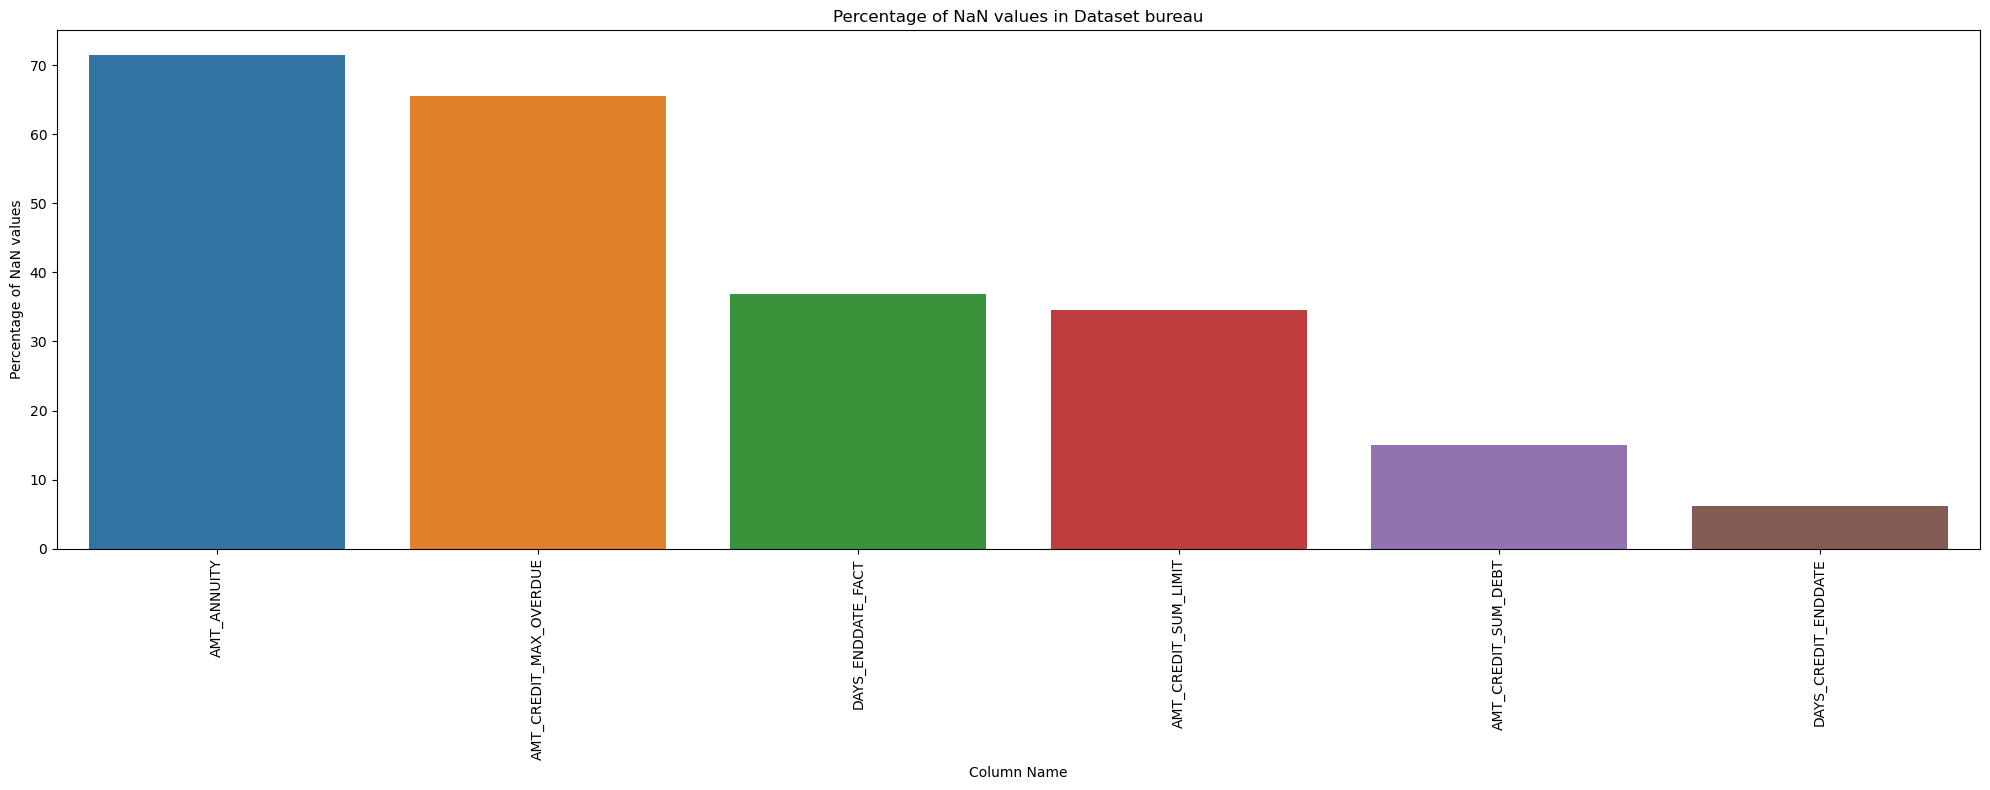

In [21]:
description_dataset(bureau, "Dataset bureau")

In [42]:
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category = True)

In [39]:
bureau_cat

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_ACTIVE_nan',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_CURRENCY_nan',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Cash loan (non-earmarked)',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Interbank credit',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
 'CREDIT_TYPE_Loan for the purchase of equipment',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mobile operator loan',
 'CREDIT_TYPE_Mortgage',
 'CREDIT_TYPE_Real estate loan',
 'CREDIT_TYPE_Unknown type of loan',
 'CREDIT_TYPE_nan']

In [43]:
bureau_and_balance = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\bureau_balance.csv')

ParserError: Error tokenizing data. C error: out of memory

In [36]:
description_dataset(bureau_and_balance, "Dataset bureau_and_balance")

========================================Dataset bureau_and_balance========================================


Taille :  (27299925, 3)


Valeurs différentes par variables : 

SK_ID_BUREAU ( type de variable : int64 ) contient 817395 valeurs différentes
MONTHS_BALANCE ( type de variable : int64 ) contient 97 valeurs différentes
STATUS ( type de variable : object ) : ['C' '0' 'X' '1' '2' '3' '5' '4']


Nombre de doublons : 0


Valeurs manquantes par colonnes (%): 


Variable name Variable type  Missing values  % Missing
0    SK_ID_BUREAU         int64               0        0.0
1  MONTHS_BALANCE         int64               0        0.0
2          STATUS        object               0        0.0



Le dataset Dataset bureau_and_balance ne contient pas de NaN.


La variable `SK_ID_BUREAU` conserve le numéro de demandes antérieures d'un client. Chaque client peut avoir plusieurs demandes.

In [44]:
bb, bb_cat = one_hot_encoder(bureau_and_balance, nan_as_category = True)

In [38]:
bb_cat

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X',
 'STATUS_nan']

In [45]:
# Bureau balance: Perform aggregations
bb_aggregations = {'MONTHS_BALANCE': ['mean', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg

MONTHS_BALANCE_MEAN  MONTHS_BALANCE_SIZE  STATUS_0_MEAN  \
SK_ID_BUREAU                                                            
5001709                     -48.0                   97       0.000000   
5001710                     -41.0                   83       0.060241   
5001711                      -1.5                    4       0.750000   
5001712                      -9.0                   19       0.526316   
5001713                     -10.5                   22       0.000000   
...                           ...                  ...            ...   
6842884                     -23.5                   48       0.187500   
6842885                     -11.5                   24       0.500000   
6842886                     -16.0                   33       0.242424   
6842887                     -18.0                   37       0.162162   
6842888                     -30.5                   62       0.145161   

              STATUS_1_MEAN  STATUS_2_MEAN  STATUS_3_MEAN  STATUS_4_MEAN  \
SK_ID_BUREAU                                                               
5001709            0.000000            0.0            0.0            0.0   
5001710            0.000000            0.0            0.0            0.0   
5001711            0.000000            0.0            0.0            0.0   
5001712            0.000000            0.0            0.0            0.0   
5001713            0.000000            0.0            0.0            0.0   
...                     ...            ...            ...            ...   
6842884            0.000000            0.0            0.0            0.0   
6842885            0.000000            0.0            0.0            0.0   
6842886            0.000000            0.0            0.0            0.0   
6842887            0.000000            0.0            0.0            0.0   
6842888            0.016129            0.0            0.0            0.0   

              STATUS_5_MEAN  STATUS_C_MEAN  STATUS_X_MEAN  STATUS_nan_MEAN  
SK_ID_BUREAU                                                                
5001709                 0.0       0.886598       0.113402              0.0  
5001710                 0.0       0.578313       0.361446              0.0  
5001711                 0.0       0.000000       0.250000              0.0  
5001712                 0.0       0.473684       0.000000              0.0  
5001713                 0.0       0.000000       1.000000              0.0  
...                     ...            ...            ...              ...  
6842884                 0.0       0.416667       0.395833              0.0  
6842885                 0.5       0.000000       0.000000              0.0  
6842886                 0.0       0.757576       0.000000              0.0  
6842887                 0.0       0.837838       0.000000              0.0  
6842888                 0.0       0.838710       0.000000              0.0  

[817395 rows x 11 columns]

In [46]:
# Merge with bureau.csv
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 50 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   DAYS_CREDIT                                               int64  
 2   CREDIT_DAY_OVERDUE                                        int64  
 3   DAYS_CREDIT_ENDDATE                                       float64
 4   DAYS_ENDDATE_FACT                                         float64
 5   AMT_CREDIT_MAX_OVERDUE                                    float64
 6   CNT_CREDIT_PROLONG                                        int64  
 7   AMT_CREDIT_SUM                                            float64
 8   AMT_CREDIT_SUM_DEBT                                       float64
 9   AMT_CREDIT_SUM_LIMIT                                      float64
 10  AMT_CREDIT_SUM_OVERDUE        

In [47]:
# New features on CREDIT
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']

# Credit to debt ratio and difference
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

In [48]:
# Bureau and bureau_balance numeric features
num_aggregations = {'DAYS_CREDIT': ['min', 'max', 'mean'], 
                    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
                    'DAYS_CREDIT_UPDATE': ['mean'],
                    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                    'AMT_CREDIT_MAX_OVERDUE': ['max','mean'],
                    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
                    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
                    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
                    'AMT_ANNUITY': ['mean'],
                    'CNT_CREDIT_PROLONG': ['sum'],
                    'MONTHS_BALANCE_MEAN': ['mean',"var"],
                    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
                    'CREDIT_DURATION': ['min', 'max', 'mean'],
                    'ENDDATE_DIF': ['min', 'max', 'mean'],
                    'DEBT_PERCENTAGE': ['min', 'max', 'mean'],
                    'DEBT_CREDIT_DIFF': ['var','mean'],
                    'CREDIT_TO_ANNUITY_RATIO': ['min', 'max', 'mean'],}

In [49]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

In [50]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
bureau_agg

BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100003                       -2586                    -606   
100004                       -1326                    -408   
100005                        -373                     -62   
...                            ...                     ...   
456249                       -2713                    -483   
456250                       -1002                    -760   
456253                        -919                    -713   
456254                       -1104                   -1104   
456255                       -2337                    -363   

            BUREAU_DAYS_CREDIT_MEAN  BUREAU_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                            
100001                  -735.000000                         -1329.0   
100002                  -874.000000                         -1072.0   
100003                 -1400.750000                         -2434.0   
100004                  -867.000000                          -595.0   
100005                  -190.666667                          -128.0   
...                             ...                             ...   
456249                 -1667.076923                         -2499.0   
456250                  -862.000000                          -272.0   
456253                  -867.500000                          -189.0   
456254                 -1104.000000                          -859.0   
456255                 -1089.454545                         -1243.0   

            BUREAU_DAYS_CREDIT_ENDDATE_MAX  BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                   
100001                              1778.0                      -93.142857   
100002                               780.0                     -499.875000   
100003                              1216.0                     -816.000000   
100004                              -382.0                     -532.000000   
100005                              1324.0                      -54.333333   
...                                    ...                             ...   
456249                              1363.0                    -1064.538462   
456250                              2340.0                      -60.333333   
456253                              1113.0                     -253.250000   
456254                              -859.0                     -401.000000   
456255                             27320.0                     -531.090909   

            BUREAU_CREDIT_DAY_OVERDUE_MAX  BUREAU_CREDIT_DAY_OVERDUE_MEAN  \
SK_ID_CURR                                                                  
100001                                  0                             0.0   
100002                                  0                             0.0   
100003                                  0                             0.0   
100004                                  0                             0.0   
100005                                  0                             0.0   
...                                   ...                             ...   
456249                                  0                             0.0   
456250                                  0                             0.0   
456253                                  0                             0.0   
456254                                  0                             0.0   
456255                                  0                             0.0   

            BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX  \
SK_ID_CURR                                      
100001                                    NaN   
100002                               5043.645   
100003                                  0.000   
100004             

In [51]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['BUREAU_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
bureau_agg

BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100003                       -2586                    -606   
100004                       -1326                    -408   
100005                        -373                     -62   
...                            ...                     ...   
456249                       -2713                    -483   
456250                       -1002                    -760   
456253                        -919                    -713   
456254                       -1104                   -1104   
456255                       -2337                    -363   

            BUREAU_DAYS_CREDIT_MEAN  BUREAU_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                            
100001                  -735.000000                         -1329.0   
100002                  -874.000000                         -1072.0   
100003                 -1400.750000                         -2434.0   
100004                  -867.000000                          -595.0   
100005                  -190.666667                          -128.0   
...                             ...                             ...   
456249                 -1667.076923                         -2499.0   
456250                  -862.000000                          -272.0   
456253                  -867.500000                          -189.0   
456254                 -1104.000000                          -859.0   
456255                 -1089.454545                         -1243.0   

            BUREAU_DAYS_CREDIT_ENDDATE_MAX  BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                   
100001                              1778.0                      -93.142857   
100002                               780.0                     -499.875000   
100003                              1216.0                     -816.000000   
100004                              -382.0                     -532.000000   
100005                              1324.0                      -54.333333   
...                                    ...                             ...   
456249                              1363.0                    -1064.538462   
456250                              2340.0                      -60.333333   
456253                              1113.0                     -253.250000   
456254                              -859.0                     -401.000000   
456255                             27320.0                     -531.090909   

            BUREAU_CREDIT_DAY_OVERDUE_MAX  BUREAU_CREDIT_DAY_OVERDUE_MEAN  \
SK_ID_CURR                                                                  
100001                                  0                             0.0   
100002                                  0                             0.0   
100003                                  0                             0.0   
100004                                  0                             0.0   
100005                                  0                             0.0   
...                                   ...                             ...   
456249                                  0                             0.0   
456250                                  0                             0.0   
456253                                  0                             0.0   
456254                                  0                             0.0   
456255                                  0                             0.0   

            BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX  \
SK_ID_CURR                                      
100001                                    NaN   
100002                               5043.645   
100003                                  0.000   
100004             

In [52]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['BUREAU_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

In [63]:
bureau_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Columns: 158 entries, BUREAU_DAYS_CREDIT_MIN to BUREAU_CLOSED_CREDIT_TO_ANNUITY_RATIO_MEAN
dtypes: float64(154), int64(4)
memory usage: 371.0 MB


In [53]:
#Fusionner bureau_agg au dataset 
data = data.join(bureau_agg, how='left', on='SK_ID_CURR')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356250 entries, 0 to 48743
Columns: 359 entries, SK_ID_CURR to BUREAU_CLOSED_CREDIT_TO_ANNUITY_RATIO_MEAN
dtypes: float64(211), int64(15), uint8(133)
memory usage: 662.2 MB


## 2.4 Dataset `previous_application`<a class="anchor" id="section2.4"></a>

In [56]:
previous_application = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\previous_application.csv')

ParserError: Error tokenizing data. C error: out of memory

========================================Dataset previous_application========================================


Taille :  (1670214, 37)


Valeurs différentes par variables : 

SK_ID_PREV ( type de variable : int64 ) contient 1670214 valeurs différentes
SK_ID_CURR ( type de variable : int64 ) contient 338857 valeurs différentes
NAME_CONTRACT_TYPE ( type de variable : object ) : ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
AMT_ANNUITY ( type de variable : float64 ) contient 357959 valeurs différentes
AMT_APPLICATION ( type de variable : float64 ) contient 93885 valeurs différentes
AMT_CREDIT ( type de variable : float64 ) contient 86803 valeurs différentes
AMT_DOWN_PAYMENT ( type de variable : float64 ) contient 29278 valeurs différentes
AMT_GOODS_PRICE ( type de variable : float64 ) contient 93885 valeurs différentes
WEEKDAY_APPR_PROCESS_START ( type de variable : object ) : ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
HOUR_APPR_PROCESS_START ( type

Variable name Variable type  Missing values  % Missing
14     RATE_INTEREST_PRIVILEGED       float64         1664263       99.6
13        RATE_INTEREST_PRIMARY       float64         1664263       99.6
6              AMT_DOWN_PAYMENT       float64          895844       53.6
12            RATE_DOWN_PAYMENT       float64          895844       53.6
20              NAME_TYPE_SUITE        object          820405       49.1
36    NFLAG_INSURED_ON_APPROVAL       float64          673065       40.3
35             DAYS_TERMINATION       float64          673065       40.3
34                DAYS_LAST_DUE       float64          673065       40.3
33    DAYS_LAST_DUE_1ST_VERSION       float64          673065       40.3
32               DAYS_FIRST_DUE       float64          673065       40.3
31           DAYS_FIRST_DRAWING       float64          673065       40.3
7               AMT_GOODS_PRICE       float64          385515       23.1
3                   AMT_ANNUITY       float64          372235       22.3
28                  CNT_PAYMENT       float64          372230       22.3
30          PRODUCT_COMBINATION        object             346        0.0
5                    AMT_CREDIT       float64               1        0.0
29             NAME_YIELD_GROUP        object               0        0.0
23               NAME_PORTFOLIO        object               0        0.0
27         NAME_SELLER_INDUSTRY        object               0        0.0
26             SELLERPLACE_AREA         int64               0        0.0
25                 CHANNEL_TYPE        object               0        0.0
24            NAME_PRODUCT_TYPE        object               0        0.0
0                    SK_ID_PREV         int64               0        0.0
22          NAME_GOODS_CATEGORY        object               0        0.0
21             NAME_CLIENT_TYPE        object               0        0.0
19           CODE_REJECT_REASON        object               0        0.0
1                    SK_ID_CURR         int64               0        0.0
17                DAYS_DECISION         int64               0        0.0
16         NAME_CONTRACT_STATUS        object               0        0.0
15       NAME_CASH_LOAN_PURPOSE        object               0        0.0
11       NFLAG_LAST_APPL_IN_DAY         int64               0        0.0
10  FLAG_LAST_APPL_PER_CONTRACT        object               0        0.0
9       HOUR_APPR_PROCESS_START         int64               0        0.0
8    WEEKDAY_APPR_PROCESS_START        object               0        0.0
4               AMT_APPLICATION       float64               0        0.0
2            NAME_CONTRACT_TYPE        object               0        0.0
18            NAME_PAYMENT_TYPE        object               0        0.0



Le nombre de colonnes ayant Nan : 14 colonnes


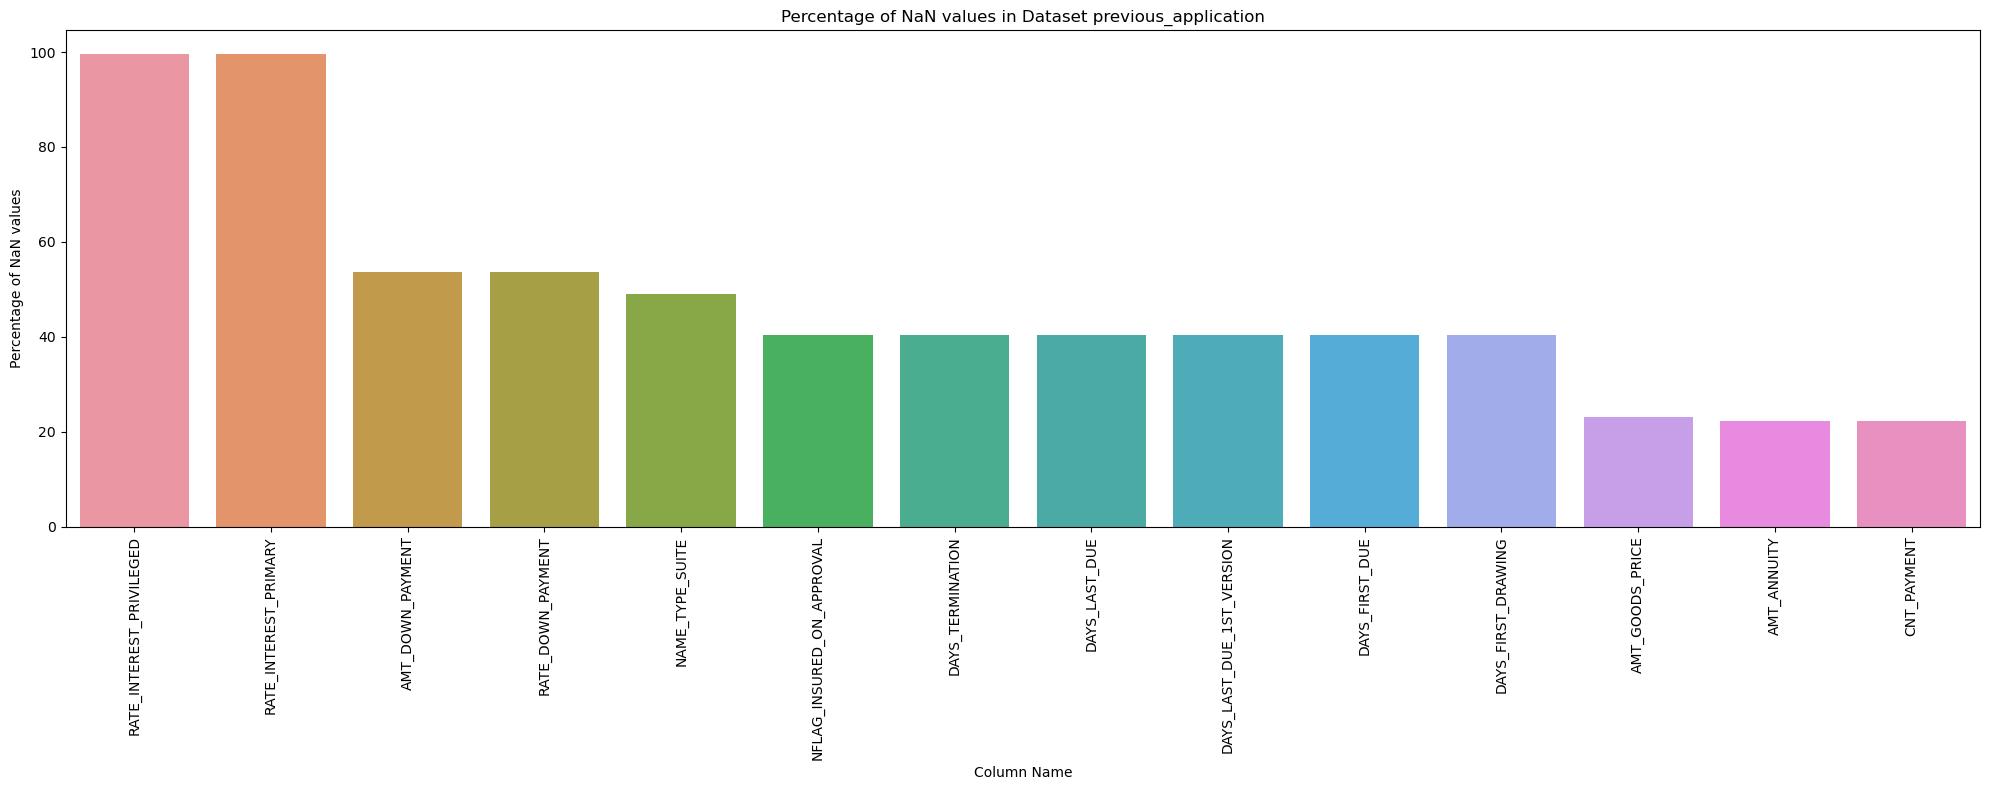

In [49]:
description_dataset(previous_application, "Dataset previous_application")

La variable `SK_ID_PREV` conserve l'identité de crédit précédent d'un client.

In [55]:
prev, cat_cols = one_hot_encoder(previous_application, nan_as_category= True)

NameError: name 'previous_application' is not defined

In [68]:
# Feature engineering: ratios and difference
prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

# Interest ratio on previous application (simplified)
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
    
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [72]:
# Previous applications numeric features
num_aggregations = {'AMT_ANNUITY': ['min', 'max', 'mean'],
                    'AMT_APPLICATION': ['min', 'max', 'mean'],
                    'AMT_CREDIT': ['min', 'max', 'mean'],
                    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
                    'AMT_DOWN_PAYMENT': ['max', 'mean'],
                    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
                    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
                    'RATE_DOWN_PAYMENT': ['max', 'mean'],
                    'DAYS_DECISION': ['min', 'max', 'mean'],
                    'CNT_PAYMENT': ['mean', 'max'],
                    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
                    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean',"var"],
                    'CREDIT_TO_ANNUITY_RATIO': ['max', 'mean'],
                    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
                    'SIMPLE_INTERESTS': ['mean']}

In [76]:
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
    
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

cat_aggregations

{'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
 'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
 'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
 'NAME_CONTRACT_TYPE_XNA': ['mean'],
 'NAME_CONTRACT_TYPE_nan': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_FRIDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_MONDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_SATURDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_SUNDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_THURSDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_TUESDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY': ['mean'],
 'WEEKDAY_APPR_PROCESS_START_nan': ['mean'],
 'FLAG_LAST_APPL_PER_CONTRACT_N': ['mean'],
 'FLAG_LAST_APPL_PER_CONTRACT_Y': ['mean'],
 'FLAG_LAST_APPL_PER_CONTRACT_nan': ['mean'],
 'NAME_CASH_LOAN_PURPOSE_Building a house or an annex': ['mean'],
 'NAME_CASH_LOAN_PURPOSE_Business development': ['mean'],
 'NAME_CASH_LOAN_PURPOSE_Buying a garage': ['mean'],
 'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land': ['mean'],
 'NAME_CASH_LOAN_PU

In [77]:
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

In [79]:
prev_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338857 entries, 100001 to 456255
Columns: 237 entries, PREV_AMT_ANNUITY_MIN to APPROVED_SIMPLE_INTERESTS_MEAN
dtypes: float64(233), int64(4)
memory usage: 615.3 MB


In [80]:
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])

In [82]:
refused_agg

REFUSED_AMT_ANNUITY_MIN  REFUSED_AMT_ANNUITY_MAX  \
SK_ID_CURR                                                     
100006                    32696.100                32696.100   
100011                          NaN                      NaN   
100027                    22556.475                22556.475   
100030                     2826.450                 6176.925   
100035                    22308.750                33238.800   
...                             ...                      ...   
456244                    17232.030                17232.030   
456247                          NaN                      NaN   
456249                    11497.500                11497.500   
456250                    19151.100                19151.100   
456255                     2250.000                30737.655   

            REFUSED_AMT_ANNUITY_MEAN  REFUSED_AMT_APPLICATION_MIN  \
SK_ID_CURR                                                          
100006                    32696.1000                   688500.000   
100011                           NaN                        0.000   
100027                    22556.4750                   225000.000   
100030                     4073.2650                    21969.225   
100035                    27773.7750                        0.000   
...                              ...                          ...   
456244                    17232.0300                   135000.000   
456247                           NaN                    52510.500   
456249                    11497.5000                   114210.000   
456250                    19151.1000                   450000.000   
456255                    16493.8275                    45000.000   

            REFUSED_AMT_APPLICATION_MAX  REFUSED_AMT_APPLICATION_MEAN  \
SK_ID_CURR                                                              
100006                         688500.0                   688500.0000   
100011                              0.0                        0.0000   
100027                         225000.0                   225000.0000   
100030                          43870.5                    33767.1225   
100035                        1260000.0                   241875.0000   
...                                 ...                           ...   
456244                         135000.0                   135000.0000   
456247                          52510.5                    52510.5000   
456249                         114210.0                   114210.0000   
456250                         450000.0                   450000.0000   
456255                         765000.0                   405000.0000   

            REFUSED_AMT_CREDIT_MIN  REFUSED_AMT_CREDIT_MAX  \
SK_ID_CURR                                                   
100006                  906615.000                906615.0   
100011                       0.000                     0.0   
100027                  239850.000                239850.0   
100030                   21969.225                 43870.5   
100035                       0.000               1260000.0   
...                            ...                     ...   
456244                  162778.500                162778.5   
456247                   52510.500                 52510.5   
456249                  125518.500                125518.5   
456250                  533160.000                533160.0   
456255                   45000.000               1067940.0   

            REFUSED_AMT_CREDIT_MEAN  REFUSED_APP_CREDIT_PERC_MIN  ...  \
SK_ID_CURR                                                        ...   
100006                  906615.0000                     0.759418  ...   
100011                       0.0000                          NaN  ...   
100027                  239850.0000                     0.938086  ...   
100030                   32533.2225                     1.000000  ...   
100035                  241875.0000                     1.000000  ...   
...          

In [81]:
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
prev_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338857 entries, 100001 to 456255
Columns: 276 entries, PREV_AMT_ANNUITY_MIN to REFUSED_SIMPLE_INTERESTS_MEAN
dtypes: float64(272), int64(4)
memory usage: 716.1 MB


In [83]:
#Fusionner prev_agg au dataset 
data = data.join(prev_agg, how='left', on='SK_ID_CURR')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356250 entries, 0 to 48743
Columns: 635 entries, SK_ID_CURR to REFUSED_SIMPLE_INTERESTS_MEAN
dtypes: float64(487), int64(15), uint8(133)
memory usage: 1.4 GB


## 2.5 Dataset `POS_CASH_balance`<a class="anchor" id="section2.5"></a> 

In [84]:
POS_CASH_balance = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\POS_CASH_balance.csv')

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None


========================================Dataset POS_CASH_balance========================================


Taille :  (10001358, 8)


Valeurs différentes par variables : 

SK_ID_PREV ( type de variable : int64 ) contient 936325 valeurs différentes
SK_ID_CURR ( type de variable : int64 ) contient 337252 valeurs différentes
MONTHS_BALANCE ( type de variable : int64 ) contient 96 valeurs différentes
CNT_INSTALMENT ( type de variable : float64 ) contient 73 valeurs différentes
CNT_INSTALMENT_FUTURE ( type de variable : float64 ) contient 79 valeurs différentes
NAME_CONTRACT_STATUS ( type de variable : object ) : ['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']
SK_DPD ( type de variable : int64 ) contient 3400 valeurs différentes
SK_DPD_DEF ( type de variable : int64 ) contient 2307 valeurs différentes


Nombre de doublons : 0


Valeurs manquantes par colonnes (%): 


Variable name Variable type  Missing values  % Missing
4  CNT_INSTALMENT_FUTURE       float64           26087        0.3
3         CNT_INSTALMENT       float64           26071        0.3
0             SK_ID_PREV         int64               0        0.0
1             SK_ID_CURR         int64               0        0.0
2         MONTHS_BALANCE         int64               0        0.0
5   NAME_CONTRACT_STATUS        object               0        0.0
6                 SK_DPD         int64               0        0.0
7             SK_DPD_DEF         int64               0        0.0



Le nombre de colonnes ayant Nan : 2 colonnes


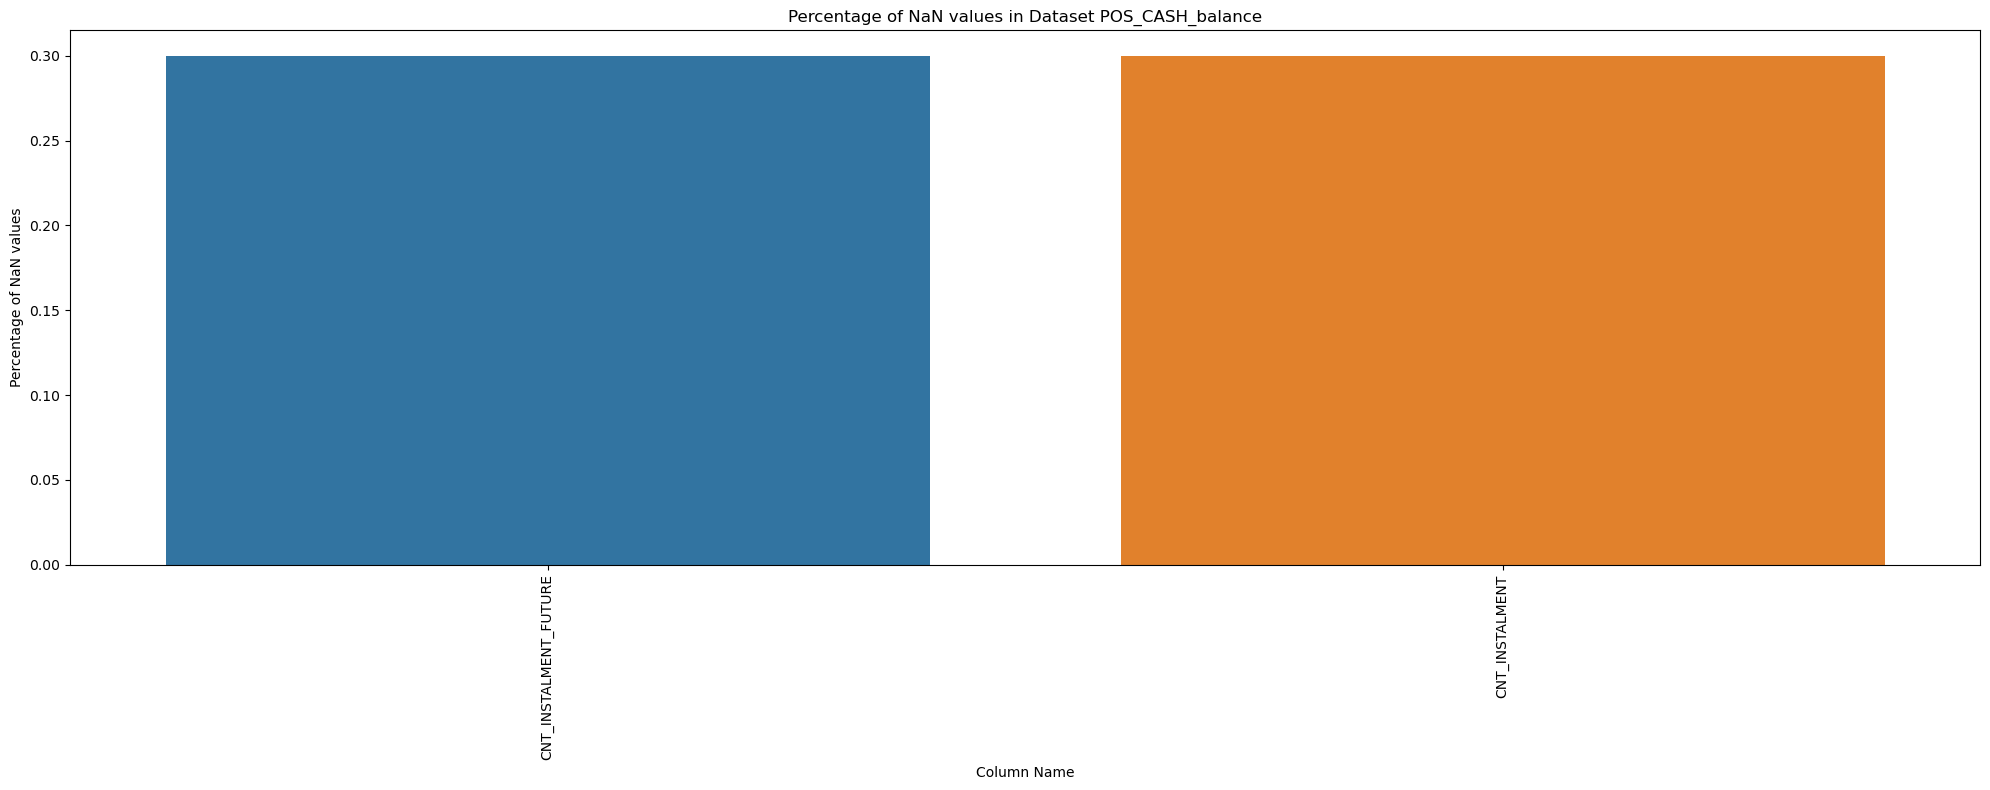

In [85]:
description_dataset(POS_CASH_balance, "Dataset POS_CASH_balance")

In [86]:
pos, cat_cols = one_hot_encoder(POS_CASH_balance, nan_as_category= True)

In [87]:
# Features
pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
aggregations = {'MONTHS_BALANCE': ['max', 'min', 'size'],
                'SK_DPD': ['max', 'mean', "sum", "var"],
                'SK_DPD_DEF': ['max', 'mean', "sum"],
                'LATE_PAYMENT': ['mean']}

for cat in cat_cols:
    aggregations[cat] = ['mean']
    
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

In [88]:
pos_agg

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MIN  \
SK_ID_CURR                                                   
100001                         -53                     -96   
100002                          -1                     -19   
100003                         -18                     -77   
100004                         -24                     -27   
100005                         -15                     -25   
...                            ...                     ...   
456251                          -1                      -9   
456252                         -76                     -82   
456253                         -57                     -96   
456254                          -1                     -11   
456255                          -2                     -33   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   
...                             ...             ...              ...   
456251                            9               0         0.000000   
456252                            7               0         0.000000   
456253                           17               5         0.294118   
456254                           20               0         0.000000   
456255                           71               5         0.070423   

            POS_SK_DPD_SUM  POS_SK_DPD_VAR  POS_SK_DPD_DEF_MAX  \
SK_ID_CURR                                                       
100001                   7        5.444444                   7   
100002                   0        0.000000                   0   
100003                   0        0.000000                   0   
100004                   0        0.000000                   0   
100005                   0        0.000000                   0   
...                    ...             ...                 ...   
456251                   0        0.000000                   0   
456252                   0        0.000000                   0   
456253                   5        1.470588                   5   
456254                   0        0.000000                   0   
456255                   5        0.352113                   5   

            POS_SK_DPD_DEF_MEAN  POS_SK_DPD_DEF_SUM  ...  \
SK_ID_CURR                                           ...   
100001                 0.777778                   7  ...   
100002                 0.000000                   0  ...   
100003                 0.000000                   0  ...   
100004                 0.000000                   0  ...   
100005                 0.000000                   0  ...   
...                         ...                 ...  ...   
456251                 0.000000                   0  ...   
456252                 0.000000                   0  ...   
456253                 0.294118                   5  ...   
456254                 0.000000                   0  ...   
456255                 0.070423                   5  ...   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   
...                                                  ...   
456251                                               0.0   
456252                                               0.0   
456253                      

In [89]:
#Fusionner prev_agg au dataset 
data = data.join(pos_agg, how='left', on='SK_ID_CURR')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356250 entries, 0 to 48743
Columns: 657 entries, SK_ID_CURR to POS_COUNT
dtypes: float64(509), int64(15), uint8(133)
memory usage: 1.4 GB


## 2.6 Dataset `installments_payments`<a class="anchor" id="section2.6"></a> 

In [90]:
installments_payments = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\installments_payments.csv')

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None


In [91]:
description_dataset(installments_payments, "Dataset installments_payments")

========================================Dataset installments_payments========================================


Taille :  (13605401, 8)


Valeurs différentes par variables : 

SK_ID_PREV ( type de variable : int64 ) contient 997752 valeurs différentes
SK_ID_CURR ( type de variable : int64 ) contient 339587 valeurs différentes
NUM_INSTALMENT_VERSION ( type de variable : float64 ) contient 65 valeurs différentes
NUM_INSTALMENT_NUMBER ( type de variable : int64 ) contient 277 valeurs différentes
DAYS_INSTALMENT ( type de variable : float64 ) contient 2922 valeurs différentes
DAYS_ENTRY_PAYMENT ( type de variable : float64 ) contient 3039 valeurs différentes
AMT_INSTALMENT ( type de variable : float64 ) contient 902539 valeurs différentes
AMT_PAYMENT ( type de variable : float64 ) contient 944235 valeurs différentes


Nombre de doublons : 0


Valeurs manquantes par colonnes (%): 


Variable name Variable type  Missing values  % Missing
5      DAYS_ENTRY_PAYMENT       float64            2905        0.0
7             AMT_PAYMENT       float64            2905        0.0
0              SK_ID_PREV         int64               0        0.0
1              SK_ID_CURR         int64               0        0.0
2  NUM_INSTALMENT_VERSION       float64               0        0.0
3   NUM_INSTALMENT_NUMBER         int64               0        0.0
4         DAYS_INSTALMENT       float64               0        0.0
6          AMT_INSTALMENT       float64               0        0.0



Le dataset Dataset installments_payments ne contient pas de NaN.


In [92]:
ins, cat_cols = one_hot_encoder(installments_payments, nan_as_category= True)

In [93]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
ins['PAID_OVER_AMOUNT'] = ins['AMT_PAYMENT'] - ins['AMT_INSTALMENT']
ins['PAID_OVER'] = (ins['PAID_OVER_AMOUNT'] > 0).astype(int)

# Payment Entry: Days past due and Days before due
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: 0 if x <= 0 else x)
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DBD'] = ins['DBD'].apply(lambda x: 0 if x <= 0 else x)

# Flag late payment
ins['LATE_PAYMENT'] = ins['DBD'].apply(lambda x: 1 if x > 0 else 0)

# Percentage of payments that were late
ins['INSTALMENT_PAYMENT_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['LATE_PAYMENT_RATIO'] = ins.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

# Flag late payments that have a significant amount
ins['SIGNIFICANT_LATE_PAYMENT'] = ins['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)

# Flag k threshold late payments
ins['DPD_7'] = ins['DPD'].apply(lambda x: 1 if x >= 7 else 0)
ins['DPD_15'] = ins['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    
# Features: Perform aggregations
aggregations = {'NUM_INSTALMENT_VERSION': ['nunique'],
                'DPD': ['max', 'mean', 'var'],
                'DBD': ['max', 'mean', 'var'],
                'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
                'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
                'AMT_INSTALMENT': ['max', 'mean', 'sum',"min"],
                'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
                'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'min'],
                'PAID_OVER_AMOUNT': ['max', 'mean', 'sum'],
                'PAID_OVER': ['mean'],
                'LATE_PAYMENT': ['mean', 'sum'],
                'INSTALMENT_PAYMENT_RATIO': ['max', 'mean', 'sum'],
                'LATE_PAYMENT_RATIO': ['mean'],
                'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
                'DPD_7': ['mean'],
                'DPD_15': ['mean']}

for cat in cat_cols:
    aggregations[cat] = ['mean']
    
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [94]:
#Fusionner prev_agg au dataset 
data = data.join(ins_agg, how='left', on='SK_ID_CURR')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356250 entries, 0 to 48743
Columns: 698 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(550), int64(15), uint8(133)
memory usage: 1.6 GB


## 2.7 Dataset `credit_card_balance`<a class="anchor" id="section2.7"></a> 

In [95]:
credit_card_balance = chargement_dataset('C:\\Users\\LEMuon\\Downloads\\P7\\credit_card_balance.csv')

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

========================================Dataset credit_card_balance========================================


Taille :  (3840312, 23)


Valeurs différentes par variables : 

SK_ID_PREV ( type de variable : int64 ) contient 104307 valeurs différentes
SK_ID_CURR ( type de variable : int64 ) contient 103558 valeurs différentes
MONTHS_BALANCE ( type de variable : int64 ) contient 96 valeurs différentes
AMT_BALANCE ( type de variable : float64 ) contient 1347904 valeurs différentes
AMT_CREDIT_LIMIT_ACTUAL ( type de variable : int64 ) contient 181 valeurs différentes
AMT_DRAWINGS_ATM_CURRENT ( type de variable : float64 ) contient 2267 valeurs différentes
AMT_DRAWINGS_CURRENT ( type de variable : float64 ) contient 187005 valeurs différentes
AMT_DRAWINGS_OTHER_CURRENT ( type de variable : float64 ) contient 1832 valeurs différentes
AMT_DRAWINGS_POS_CURRENT ( type de variable : float64 ) contient 168748 valeurs différentes
AMT_INST_MIN_REGULARITY ( type de variable : float64 ) contient 312266

Variable name Variable type  Missing values  % Missing
10         AMT_PAYMENT_CURRENT       float64          767988       20.0
5     AMT_DRAWINGS_ATM_CURRENT       float64          749816       19.5
18    CNT_DRAWINGS_POS_CURRENT       float64          749816       19.5
7   AMT_DRAWINGS_OTHER_CURRENT       float64          749816       19.5
8     AMT_DRAWINGS_POS_CURRENT       float64          749816       19.5
17  CNT_DRAWINGS_OTHER_CURRENT       float64          749816       19.5
15    CNT_DRAWINGS_ATM_CURRENT       float64          749816       19.5
19   CNT_INSTALMENT_MATURE_CUM       float64          305236        7.9
9      AMT_INST_MIN_REGULARITY       float64          305236        7.9
0                   SK_ID_PREV         int64               0        0.0
14        AMT_TOTAL_RECEIVABLE       float64               0        0.0
21                      SK_DPD         int64               0        0.0
20        NAME_CONTRACT_STATUS        object               0        0.0
16        CNT_DRAWINGS_CURRENT         int64               0        0.0
11   AMT_PAYMENT_TOTAL_CURRENT       float64               0        0.0
13               AMT_RECIVABLE       float64               0        0.0
12    AMT_RECEIVABLE_PRINCIPAL       float64               0        0.0
1                   SK_ID_CURR         int64               0        0.0
6         AMT_DRAWINGS_CURRENT       float64               0        0.0
4      AMT_CREDIT_LIMIT_ACTUAL         int64               0        0.0
3                  AMT_BALANCE       float64               0        0.0
2               MONTHS_BALANCE         int64               0        0.0
22                  SK_DPD_DEF         int64               0        0.0



Le nombre de colonnes ayant Nan : 9 colonnes


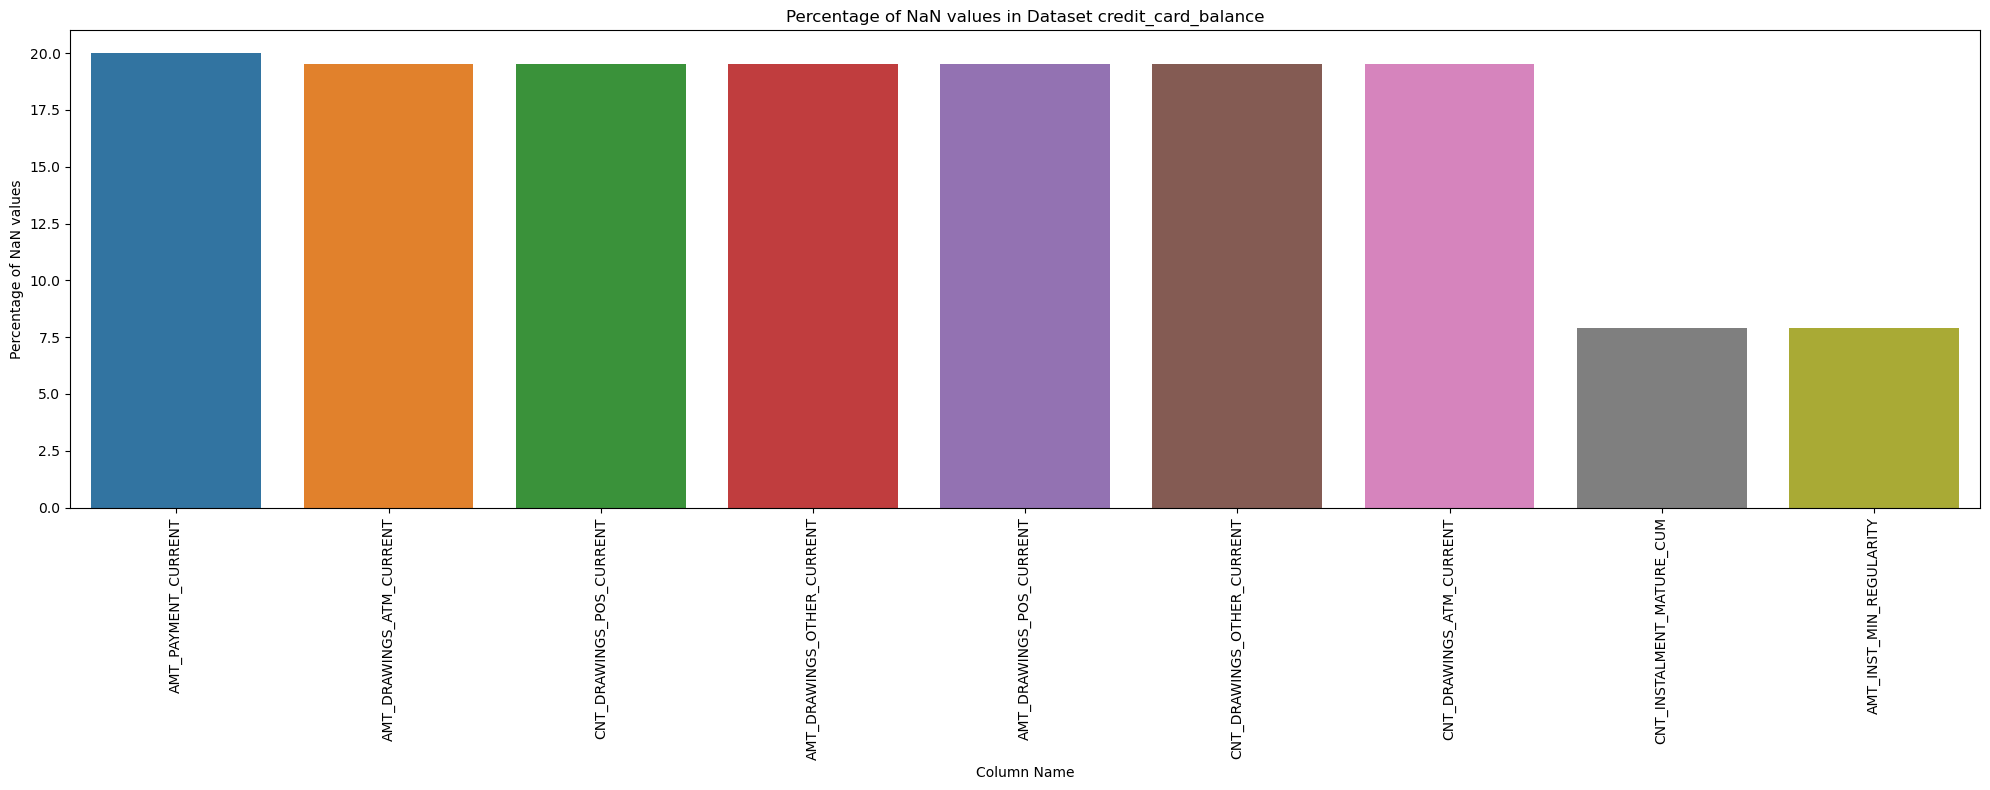

In [96]:
description_dataset(credit_card_balance, "Dataset credit_card_balance")

In [98]:
cc, cat_cols = one_hot_encoder(credit_card_balance, nan_as_category= True)
cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

In [99]:
# Amount used from limit
cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

# Current payment / Min payment
cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']

# Late payment
cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

# How much drawing of limit
cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [100]:
#Fusionner cc_agg au dataset 
data = data.join(cc_agg, how='left', on='SK_ID_CURR')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356250 entries, 0 to 48743
Columns: 859 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(711), int64(15), uint8(133)
memory usage: 2.0 GB


In [13]:
def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df

========================================Dataset========================================


Taille :  (356250, 875)


Valeurs différentes par variables : 

SK_ID_CURR ( type de variable : int64 ) contient 356250 valeurs différentes
TARGET ( type de variable : float64 ) : [ 1.  0. nan]
CODE_GENDER ( type de variable : int64 ) : [0 1]
FLAG_OWN_CAR ( type de variable : int64 ) : [0 1]
AMT_INCOME_TOTAL ( type de variable : float64 ) contient 2740 valeurs différentes
AMT_CREDIT ( type de variable : float64 ) contient 6480 valeurs différentes
AMT_ANNUITY ( type de variable : float64 ) contient 14166 valeurs différentes
AMT_GOODS_PRICE ( type de variable : float64 ) contient 1291 valeurs différentes
REGION_POPULATION_RELATIVE ( type de variable : float64 ) contient 82 valeurs différentes
DAYS_BIRTH ( type de variable : int64 ) contient 17467 valeurs différentes
DAYS_EMPLOYED ( type de variable : float64 ) contient 12895 valeurs différentes
DAYS_REGISTRATION ( type de variable : float64 ) contie

ORGANIZATION_TYPE_Industrytype5 ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Industrytype6 ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Industrytype7 ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Industrytype8 ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Industrytype9 ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Insurance ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Kindergarten ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_LegalServices ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Medicine ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Military ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Mobile ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Other ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Police ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Postal ( type de variable : int64 ) : [0 1]
ORGANIZATION_TYPE_Realtor ( type de variable : int64 ) : [0 1]
ORGANIZATION_TY

BUREAU_CREDIT_TYPE_nan_MEAN ( type de variable : float64 ) : [ 0. nan]
BUREAU_STATUS_0_MEAN_MEAN ( type de variable : float64 ) contient 89778 valeurs différentes
BUREAU_STATUS_1_MEAN_MEAN ( type de variable : float64 ) contient 19304 valeurs différentes
BUREAU_STATUS_2_MEAN_MEAN ( type de variable : float64 ) contient 3349 valeurs différentes
BUREAU_STATUS_3_MEAN_MEAN ( type de variable : float64 ) contient 1729 valeurs différentes
BUREAU_STATUS_4_MEAN_MEAN ( type de variable : float64 ) contient 1316 valeurs différentes
BUREAU_STATUS_5_MEAN_MEAN ( type de variable : float64 ) contient 2082 valeurs différentes
BUREAU_STATUS_C_MEAN_MEAN ( type de variable : float64 ) contient 75482 valeurs différentes
BUREAU_STATUS_X_MEAN_MEAN ( type de variable : float64 ) contient 63701 valeurs différentes
BUREAU_STATUS_nan_MEAN_MEAN ( type de variable : float64 ) : [ 0. nan]
BUREAU_ACTIVE_DAYS_CREDIT_MIN ( type de variable : float64 ) contient 2922 valeurs différentes
BUREAU_ACTIVE_DAYS_CREDIT_MAX (

PREV_AMT_ANNUITY_MIN ( type de variable : float64 ) contient 159917 valeurs différentes
PREV_AMT_ANNUITY_MAX ( type de variable : float64 ) contient 164388 valeurs différentes
PREV_AMT_ANNUITY_MEAN ( type de variable : float64 ) contient 309162 valeurs différentes
PREV_AMT_APPLICATION_MIN ( type de variable : float64 ) contient 39315 valeurs différentes
PREV_AMT_APPLICATION_MAX ( type de variable : float64 ) contient 53054 valeurs différentes
PREV_AMT_APPLICATION_MEAN ( type de variable : float64 ) contient 218559 valeurs différentes
PREV_AMT_CREDIT_MIN ( type de variable : float64 ) contient 40983 valeurs différentes
PREV_AMT_CREDIT_MAX ( type de variable : float64 ) contient 62833 valeurs différentes
PREV_AMT_CREDIT_MEAN ( type de variable : float64 ) contient 239718 valeurs différentes
PREV_APP_CREDIT_PERC_MIN ( type de variable : float64 ) contient 107805 valeurs différentes
PREV_APP_CREDIT_PERC_MAX ( type de variable : float64 ) contient 159474 valeurs différentes
PREV_APP_CREDIT_

PREV_NAME_CONTRACT_STATUS_Refused_MEAN ( type de variable : float64 ) contient 423 valeurs différentes
PREV_NAME_CONTRACT_STATUS_Unusedoffer_MEAN ( type de variable : float64 ) contient 124 valeurs différentes
PREV_NAME_CONTRACT_STATUS_nan_MEAN ( type de variable : float64 ) : [ 0. nan]
PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN ( type de variable : float64 ) contient 450 valeurs différentes
PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN ( type de variable : float64 ) contient 55 valeurs différentes
PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN ( type de variable : float64 ) contient 106 valeurs différentes
PREV_NAME_PAYMENT_TYPE_XNA_MEAN ( type de variable : float64 ) contient 438 valeurs différentes
PREV_NAME_PAYMENT_TYPE_nan_MEAN ( type de variable : float64 ) : [ 0. nan]
PREV_CODE_REJECT_REASON_CLIENT_MEAN ( type de variable : float64 ) contient 124 valeurs différentes
PREV_CODE_REJECT_REASON_HC_MEAN ( type de variable : float64 ) contient 409 valeurs diff

PREV_PRODUCT_COMBINATION_CardXSell_MEAN ( type de variable : float64 ) contient 191 valeurs différentes
PREV_PRODUCT_COMBINATION_Cash_MEAN ( type de variable : float64 ) contient 399 valeurs différentes
PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN ( type de variable : float64 ) contient 259 valeurs différentes
PREV_PRODUCT_COMBINATION_CashStreetlow_MEAN ( type de variable : float64 ) contient 245 valeurs différentes
PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN ( type de variable : float64 ) contient 222 valeurs différentes
PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN ( type de variable : float64 ) contient 217 valeurs différentes
PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN ( type de variable : float64 ) contient 298 valeurs différentes
PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN ( type de variable : float64 ) contient 277 valeurs différentes
PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN ( type de variable : float64 ) contient 285 valeurs différentes
PREV_PRODUCT_COMBINATION_

REFUSED_APPLICATION_CREDIT_DIFF_MAX ( type de variable : float64 ) contient 14293 valeurs différentes
REFUSED_APPLICATION_CREDIT_DIFF_MEAN ( type de variable : float64 ) contient 39413 valeurs différentes
REFUSED_APPLICATION_CREDIT_RATIO_MIN ( type de variable : float64 ) contient 23100 valeurs différentes
REFUSED_APPLICATION_CREDIT_RATIO_MAX ( type de variable : float64 ) contient 25628 valeurs différentes
REFUSED_APPLICATION_CREDIT_RATIO_MEAN ( type de variable : float64 ) contient 49656 valeurs différentes
REFUSED_APPLICATION_CREDIT_RATIO_VAR ( type de variable : float64 ) contient 35663 valeurs différentes
REFUSED_CREDIT_TO_ANNUITY_RATIO_MAX ( type de variable : float64 ) contient 42553 valeurs différentes
REFUSED_CREDIT_TO_ANNUITY_RATIO_MEAN ( type de variable : float64 ) contient 73690 valeurs différentes
REFUSED_DOWN_PAYMENT_TO_CREDIT_MEAN ( type de variable : float64 ) contient 19553 valeurs différentes
REFUSED_SIMPLE_INTERESTS_MEAN ( type de variable : float64 ) contient 59192

CC_AMT_DRAWINGS_ATM_CURRENT_MEAN ( type de variable : float64 ) contient 24822 valeurs différentes
CC_AMT_DRAWINGS_ATM_CURRENT_SUM ( type de variable : float64 ) contient 5347 valeurs différentes
CC_AMT_DRAWINGS_ATM_CURRENT_VAR ( type de variable : float64 ) contient 50448 valeurs différentes
CC_AMT_DRAWINGS_CURRENT_MIN ( type de variable : float64 ) contient 2363 valeurs différentes
CC_AMT_DRAWINGS_CURRENT_MAX ( type de variable : float64 ) contient 28333 valeurs différentes
CC_AMT_DRAWINGS_CURRENT_MEAN ( type de variable : float64 ) contient 57397 valeurs différentes
CC_AMT_DRAWINGS_CURRENT_SUM ( type de variable : float64 ) contient 47379 valeurs différentes
CC_AMT_DRAWINGS_CURRENT_VAR ( type de variable : float64 ) contient 65789 valeurs différentes
CC_AMT_DRAWINGS_OTHER_CURRENT_MIN ( type de variable : float64 ) : [    nan      0.  65250. 112500.  65520.   9180.  90000.  24750.]
CC_AMT_DRAWINGS_OTHER_CURRENT_MAX ( type de variable : float64 ) contient 1482 valeurs différentes
CC_A

CC_NAME_CONTRACT_STATUS_Completed_MAX ( type de variable : float64 ) : [nan  0.  1.]
CC_NAME_CONTRACT_STATUS_Completed_MEAN ( type de variable : float64 ) contient 1043 valeurs différentes
CC_NAME_CONTRACT_STATUS_Completed_SUM ( type de variable : float64 ) contient 44 valeurs différentes
CC_NAME_CONTRACT_STATUS_Completed_VAR ( type de variable : float64 ) contient 1943 valeurs différentes
CC_NAME_CONTRACT_STATUS_Demand_MIN ( type de variable : float64 ) : [nan  0.  1.]
CC_NAME_CONTRACT_STATUS_Demand_MAX ( type de variable : float64 ) : [nan  0.  1.]
CC_NAME_CONTRACT_STATUS_Demand_MEAN ( type de variable : float64 ) : [       nan 0.         0.73636364 0.57303371 0.56321839 0.78021978
 0.86046512 0.56382979 0.56043956 0.83157895 0.45454545 0.57894737
 0.85714286 0.02857143 0.91578947 0.8125     0.05882353 1.
 0.70967742 0.64516129 0.54166667 0.7875    ]
CC_NAME_CONTRACT_STATUS_Demand_SUM ( type de variable : float64 ) : [nan  0. 81. 51. 49. 71. 74. 53. 79. 40. 55. 72.  1. 87. 78. 96. 66

Variable name Variable type  Missing values  \
309              BUREAU_ACTIVE_ENDDATE_DIF_MEAN       float64          354347   
307               BUREAU_ACTIVE_ENDDATE_DIF_MIN       float64          354347   
308               BUREAU_ACTIVE_ENDDATE_DIF_MAX       float64          354347   
847                      CC_PAYMENT_DIV_MIN_VAR       float64          336761   
845                     CC_PAYMENT_DIV_MIN_MEAN       float64          333558   
358  BUREAU_CLOSED_CREDIT_TO_ANNUITY_RATIO_MEAN       float64          310903   
241         BUREAU_CREDIT_TO_ANNUITY_RATIO_MEAN       float64          305767   
633         REFUSED_DOWN_PAYMENT_TO_CREDIT_MEAN       float64          303647   
609                REFUSED_AMT_DOWN_PAYMENT_MAX       float64          303647   
610               REFUSED_AMT_DOWN_PAYMENT_MEAN       float64          303647   
618              REFUSED_RATE_DOWN_PAYMENT_MEAN       float64          303647   
617               REFUSED_RATE_DOWN_PAYMENT_MAX       float64          303647   
846                      CC_PAYMENT_DIV_MIN_SUM       float64          301920   
630        REFUSED_APPLICATION_CREDIT_RATIO_VAR       float64          298033   
608                 REFUSED_APP_CREDIT_PERC_VAR       float64          298033   
353          BUREAU_CLOSED_DEBT_PERCENTAGE_MEAN       float64          286447   
317  BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN       float64          285818   
857                  CC_DRAWING_LIMIT_RATIO_VAR       float64          285554   
742                  CC_AMT_PAYMENT_CURRENT_VAR       float64          284648   
717             CC_AMT_DRAWINGS_ATM_CURRENT_VAR       float64          284558   
727           CC_AMT_DRAWINGS_OTHER_CURRENT_VAR       float64          284558   
732             CC_AMT_DRAWINGS_POS_CURRENT_VAR       float64          284558   
767             CC_CNT_DRAWINGS_ATM_CURRENT_VAR       float64          284558   
782             CC_CNT_DRAWINGS_POS_CURRENT_VAR       float64          284558   
777           CC_CNT_DRAWINGS_OTHER_CURRENT_VAR       float64          284558   
855                 CC_DRAWING_LIMIT_RATIO_MEAN       float64          284353   
844                      CC_PAYMENT_DIV_MIN_MAX       float64          284330   
843                      CC_PAYMENT_DIV_MIN_MIN       float64          284330   
853                  CC_DRAWING_LIMIT_RATIO_MIN       float64          284228   
854                  CC_DRAWING_LIMIT_RATIO_MAX       float64          284228   
740                 CC_AMT_PAYMENT_CURRENT_MEAN       float64          284130   
738                  CC_AMT_PAYMENT_CURRENT_MIN       float64          284130   
739                  CC_AMT_PAYMENT_CURRENT_MAX       float64          284130   
764             CC_CNT_DRAWINGS_ATM_CURRENT_MAX       float64          284056   
773           CC_CNT_DRAWINGS_OTHER_CURRENT_MIN       float64          284056   
774           CC_CNT_DRAWINGS_OTHER_CURRENT_MAX       float64          284056   
775          CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN       float64          284056   
714             CC_AMT_DRAWINGS_ATM_CURRENT_MAX       float64          284056   
715            CC_AMT_DRAWINGS_ATM_CURRENT_MEAN       float64          284056   
765            CC_CNT_DRAWINGS_ATM_CURRENT_MEAN       float64          284056   
725          CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN       float64          284056   
723           CC_AMT_DRAWINGS_OTHER_CURRENT_MIN       float64          284056   
778             CC_CNT_DRAWINGS_POS_CURRENT_MIN       float64          284056   
728             CC_AMT_DRAWINGS_POS_CURRENT_MIN       float64          284056   
763             CC_CNT_DRAWINGS_ATM_CURRENT_MIN       float64          284056   
730            CC_AMT_DRAWINGS_POS_CURRENT_MEAN       float64          284056   
780            CC_CNT_DRAWINGS_POS_CURRENT_MEAN       float64          284056   
779             CC_CNT_DRAWINGS_POS_CURRENT_MAX       float64          284056   
729             CC_AMT_DRAWINGS_POS_CURRENT_MAX       float64    



Le nombre de colonnes ayant Nan : 712 colonnes


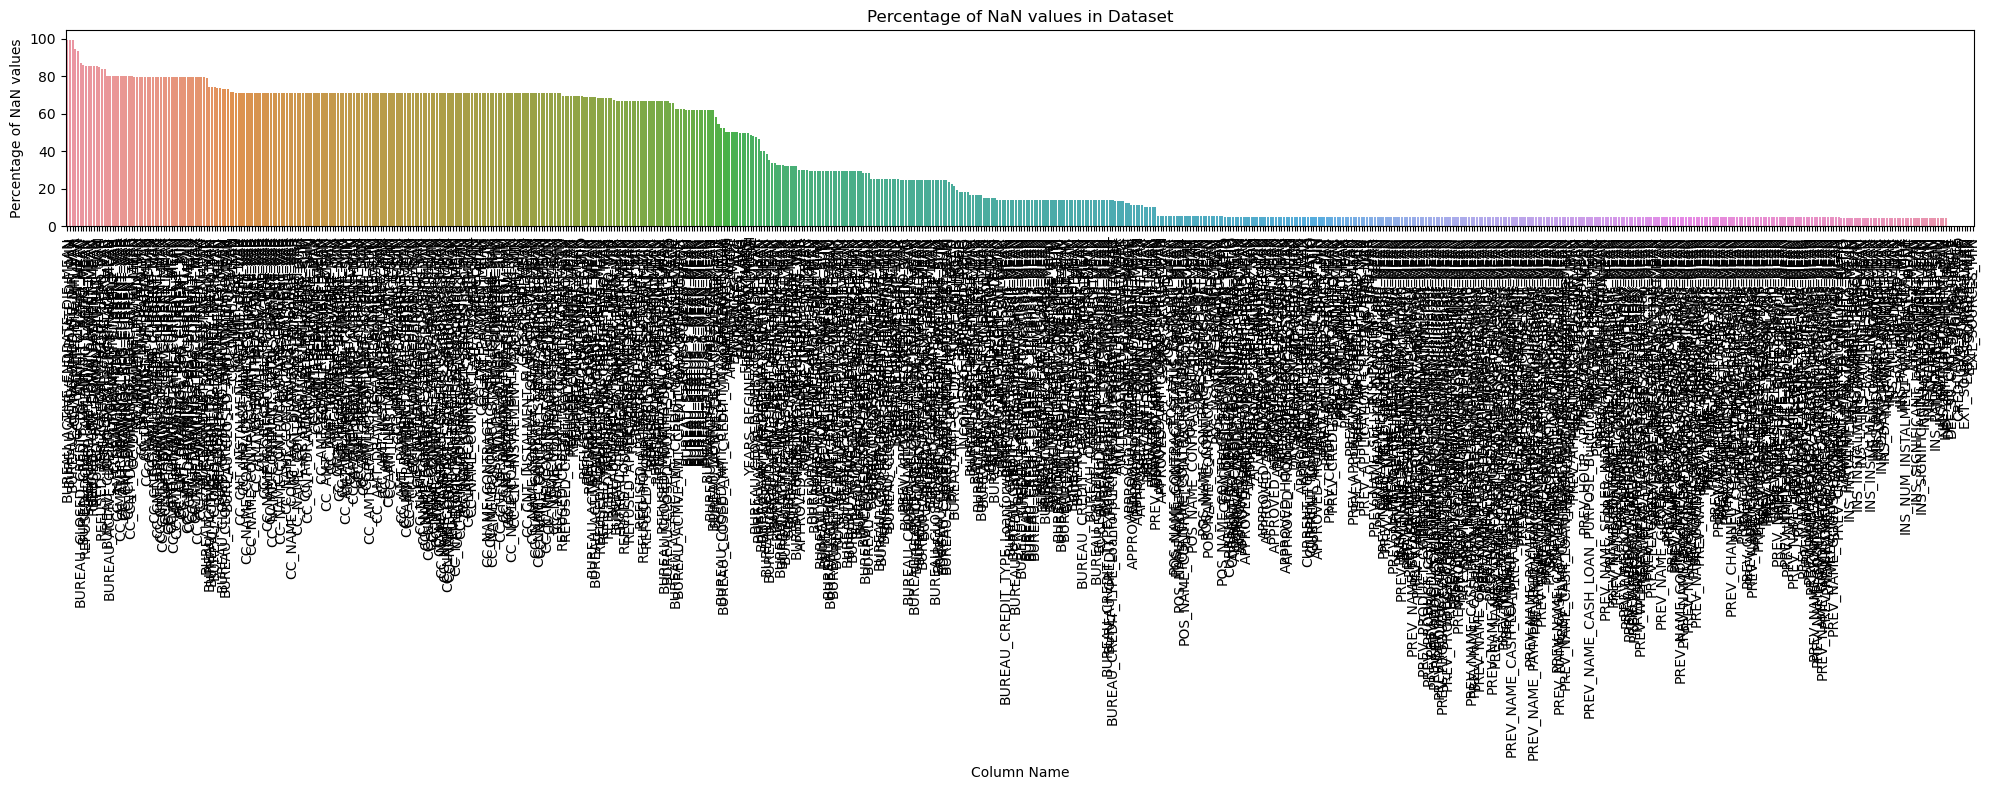

In [27]:
data = add_ratios_features(data)
description_dataset(data, 'Dataset')

In [101]:
#Enregistrement le dataset après le fusionnement de tous les fichiers
data.to_csv('C:\\Users\\LEMuon\\Downloads\\P7\\P7_Dataset_joint.csv', index=False)

In [11]:
data = pd.read_csv('C:\\Users\\karis\\Downloads\\P7\\P7_Dataset_joint.csv', low_memory=False)
data.head(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
0      100002     1.0            0             0          202500.0   
1      100003     0.0            1             0          270000.0   
2      100004     0.0            0             1           67500.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    406597.5      24700.5         351000.0                    0.018801   
1   1293502.5      35698.5        1129500.0                    0.003541   
2    135000.0       6750.0         135000.0                    0.010032   

   DAYS_BIRTH  ...  CC_LATE_PAYMENT_MAX  CC_LATE_PAYMENT_MEAN  \
0       -9461  ...                  NaN                   NaN   
1      -16765  ...                  NaN                   NaN   
2      -19046  ...                  NaN                   NaN   

   CC_LATE_PAYMENT_SUM  CC_LATE_PAYMENT_VAR  CC_DRAWING_LIMIT_RATIO_MIN  \
0                  NaN                  NaN                         NaN   
1                  NaN                  NaN                         NaN   
2                  NaN                  NaN                         NaN   

   CC_DRAWING_LIMIT_RATIO_MAX  CC_DRAWING_LIMIT_RATIO_MEAN  \
0                         NaN                          NaN   
1                         NaN                          NaN   
2                         NaN                          NaN   

   CC_DRAWING_LIMIT_RATIO_SUM  CC_DRAWING_LIMIT_RATIO_VAR  CC_COUNT  
0                         NaN                         NaN       NaN  
1                         NaN                         NaN       NaN  
2                         NaN                         NaN       NaN  

[3 rows x 859 columns]

# 3. Feature selection  par LightGBM <a class="anchor" id="chapter3"></a>

In [12]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [12]:
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [13]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
   
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    #del df
    #gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    #seri = pd.read_excel("../input/feattt/Features.xlsx")
    #seri = list(seri["feature"])
    #feats = [f for f in feats if f not in seri]
    
    print("Starting LightGBM. feats shape: {}".format(len(feats)))   
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.005134,
            num_leaves=54,
            colsample_bytree=0.508716,
            subsample=1,
            subsample_for_bin= 240000,
            max_depth=10,
            reg_alpha=0.436193,
            reg_lambda=0.436193,
            min_split_gain=0.024766,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        #del clf, train_x, train_y, valid_x, valid_y
        #gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    #if not debug:
        #test_df['TARGET'] = sub_preds
        #test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df, test_df[['SK_ID_CURR', 'TARGET']]

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", 
                                                                                                   ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    cols_series = best_features[["feature","importance"]]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')
    

In [7]:
data = pd.read_csv('C:\\Users\\karis\\Downloads\\P7\\P7_Dataset_joint.csv', low_memory=False)
data.head(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
0      100002     1.0            0             0          202500.0   
1      100003     0.0            1             0          270000.0   
2      100004     0.0            0             1           67500.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    406597.5      24700.5         351000.0                    0.018801   
1   1293502.5      35698.5        1129500.0                    0.003541   
2    135000.0       6750.0         135000.0                    0.010032   

   DAYS_BIRTH  ...  CC_LATE_PAYMENT_MAX  CC_LATE_PAYMENT_MEAN  \
0       -9461  ...                  NaN                   NaN   
1      -16765  ...                  NaN                   NaN   
2      -19046  ...                  NaN                   NaN   

   CC_LATE_PAYMENT_SUM  CC_LATE_PAYMENT_VAR  CC_DRAWING_LIMIT_RATIO_MIN  \
0                  NaN                  NaN                         NaN   
1                  NaN                  NaN                         NaN   
2                  NaN                  NaN                         NaN   

   CC_DRAWING_LIMIT_RATIO_MAX  CC_DRAWING_LIMIT_RATIO_MEAN  \
0                         NaN                          NaN   
1                         NaN                          NaN   
2                         NaN                          NaN   

   CC_DRAWING_LIMIT_RATIO_SUM  CC_DRAWING_LIMIT_RATIO_VAR  CC_COUNT  
0                         NaN                         NaN       NaN  
1                         NaN                         NaN       NaN  
2                         NaN                         NaN       NaN  

[3 rows x 859 columns]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Columns: 859 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(711), int64(148)
memory usage: 2.3 GB


## Supprimer de colonnes avec au moins 20 % de valeurs NaN

In [10]:
column_with_nan = data.columns[data.isnull().any()]

for column in column_with_nan:
    if data[column].isnull().sum()*100.0/data.shape[0] > 80:
        data.drop(column,1, inplace=True)
        
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Columns: 841 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(693), int64(148)
memory usage: 2.2 GB


In [11]:
summary_columns(data)

Variable name Variable type  Missing values  \
728           CC_AMT_PAYMENT_CURRENT_VAR       float64          284648   
713    CC_AMT_DRAWINGS_OTHER_CURRENT_VAR       float64          284558   
703      CC_AMT_DRAWINGS_ATM_CURRENT_VAR       float64          284558   
763    CC_CNT_DRAWINGS_OTHER_CURRENT_VAR       float64          284558   
768      CC_CNT_DRAWINGS_POS_CURRENT_VAR       float64          284558   
..                                   ...           ...             ...   
143  ORGANIZATION_TYPE_Industry: type 11         int64               0   
142  ORGANIZATION_TYPE_Industry: type 10         int64               0   
141   ORGANIZATION_TYPE_Industry: type 1         int64               0   
140            ORGANIZATION_TYPE_Housing         int64               0   
0                             SK_ID_CURR         int64               0   

     % Missing  
728       79.9  
713       79.9  
703       79.9  
763       79.9  
768       79.9  
..         ...  
143        0.0  
142        0.0  
141        0.0  
140        0.0  
0          0.0  

[841 rows x 4 columns]

## Exécution du kernel kaggle

Starting LightGBM. Train shape: (307506, 841), test shape: (48744, 841)
Starting LightGBM. feats shape: 839
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.776213	training's binary_logloss: 0.249125	valid_1's auc: 0.761751	valid_1's binary_logloss: 0.252451
[400]	training's auc: 0.793539	training's binary_logloss: 0.238522	valid_1's auc: 0.771599	valid_1's binary_logloss: 0.244765
[600]	training's auc: 0.807492	training's binary_logloss: 0.23197	valid_1's auc: 0.779076	valid_1's binary_logloss: 0.241014
[800]	training's auc: 0.818278	training's binary_logloss: 0.22712	valid_1's auc: 0.783809	valid_1's binary_logloss: 0.238913
[1000]	training's auc: 0.827291	training's binary_logloss: 0.22317	valid_1's auc: 0.78716	valid_1's binary_logloss: 0.237559
[1200]	training's auc: 0.835258	training's binary_logloss: 0.219736	valid_1's auc: 0.789519	valid_1's binary_logloss: 0.236645
[1400]	training's auc: 0.842475	training's binary_logloss: 0.216705	valid_1'

[3000]	training's auc: 0.88813	training's binary_logloss: 0.195982	valid_1's auc: 0.788958	valid_1's binary_logloss: 0.23873
[3200]	training's auc: 0.892437	training's binary_logloss: 0.193943	valid_1's auc: 0.789263	valid_1's binary_logloss: 0.238623
[3400]	training's auc: 0.896564	training's binary_logloss: 0.191946	valid_1's auc: 0.789594	valid_1's binary_logloss: 0.238534
[3600]	training's auc: 0.900588	training's binary_logloss: 0.18996	valid_1's auc: 0.7897	valid_1's binary_logloss: 0.238505
[3800]	training's auc: 0.904381	training's binary_logloss: 0.188032	valid_1's auc: 0.789959	valid_1's binary_logloss: 0.238427
[4000]	training's auc: 0.90801	training's binary_logloss: 0.186168	valid_1's auc: 0.790043	valid_1's binary_logloss: 0.238405
[4200]	training's auc: 0.911473	training's binary_logloss: 0.184337	valid_1's auc: 0.790211	valid_1's binary_logloss: 0.238367
[4400]	training's auc: 0.914933	training's binary_logloss: 0.182484	valid_1's auc: 0.79035	valid_1's binary_logloss: 

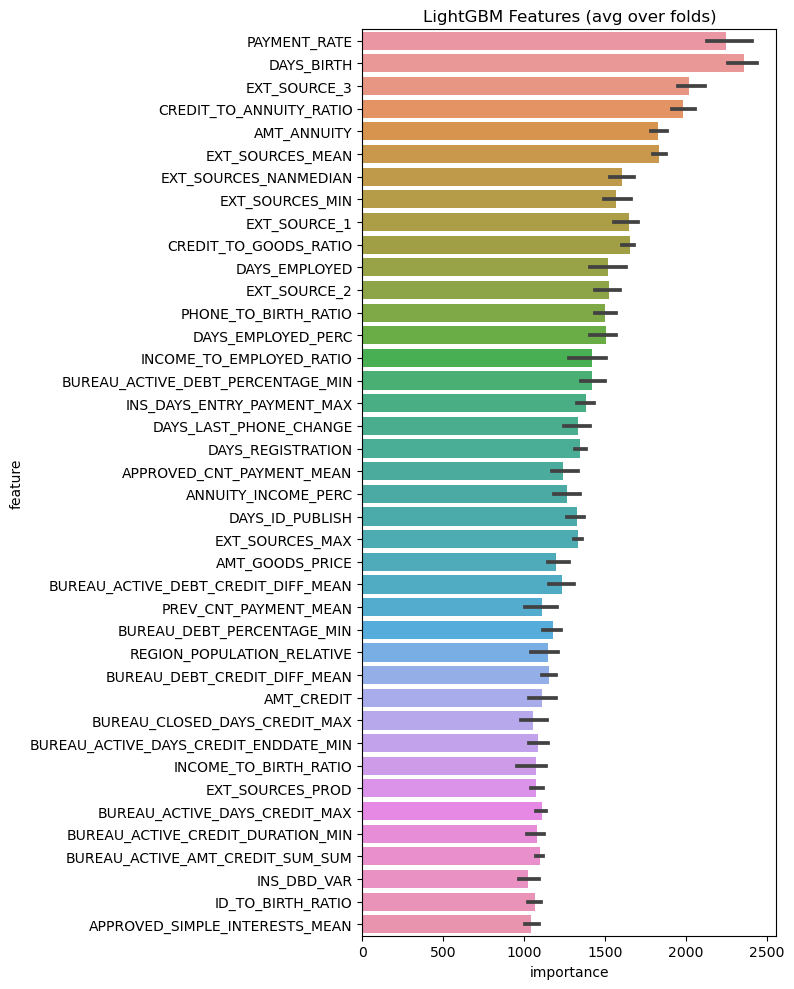

In [15]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#LightGBM
feat_importance2, test2_ = kfold_lightgbm(data, num_folds= 4, stratified= False, debug= False)

In [25]:
feat_importance2

feature  importance  fold
0                    CODE_GENDER         710     1
1                   FLAG_OWN_CAR          22     1
2               AMT_INCOME_TOTAL         522     1
3                     AMT_CREDIT        1064     1
4                    AMT_ANNUITY        1773     1
..                           ...         ...   ...
834   CC_DRAWING_LIMIT_RATIO_MIN           0     4
835   CC_DRAWING_LIMIT_RATIO_MAX         140     4
836  CC_DRAWING_LIMIT_RATIO_MEAN         313     4
837   CC_DRAWING_LIMIT_RATIO_SUM         108     4
838                     CC_COUNT          58     4

[3356 rows x 3 columns]

In [110]:
feat_importance2.to_csv('C:\\Users\\karis\\Downloads\\P7_feat_importance_lgbm.csv', index=False)

In [38]:
cols.loc[cols['importance']!=0]

importance
feature                                          
DAYS_BIRTH                                2356.75
PAYMENT_RATE                              2245.75
EXT_SOURCE_3                              2018.00
CREDIT_TO_ANNUITY_RATIO                   1983.50
EXT_SOURCES_MEAN                          1830.25
...                                           ...
ORGANIZATION_TYPE_Industrytype5              0.25
BUREAU_CLOSED_DEBT_PERCENTAGE_MAX            0.25
PREV_NAME_GOODS_CATEGORY_Tourism_MEAN        0.25
ORGANIZATION_TYPE_Agriculture                0.25
ORGANIZATION_TYPE_Industrytype1              0.25

[700 rows x 1 columns]

In [93]:
cols = feat_importance2[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", 
                                                                                         ascending=False)[:20].index
cols

Index(['DAYS_BIRTH', 'PAYMENT_RATE', 'EXT_SOURCE_3', 'CREDIT_TO_ANNUITY_RATIO',
       'EXT_SOURCES_MEAN', 'AMT_ANNUITY', 'CREDIT_TO_GOODS_RATIO',
       'EXT_SOURCE_1', 'EXT_SOURCES_NANMEDIAN', 'EXT_SOURCES_MIN',
       'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',
       'PHONE_TO_BIRTH_RATIO', 'BUREAU_ACTIVE_DEBT_PERCENTAGE_MIN',
       'INCOME_TO_EMPLOYED_RATIO', 'INS_DAYS_ENTRY_PAYMENT_MAX',
       'DAYS_REGISTRATION', 'EXT_SOURCES_MAX', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object', name='feature')

In [2]:
data_train = data[data['SK_ID_CURR'].isin(application_train["SK_ID_CURR"])]
print("\n Taille de données de train:", data_train.shape)

data_test = data[data['SK_ID_CURR'].isin(application_test["SK_ID_CURR"])]
data_test = data_test.drop('TARGET', axis=1)
print("\n Taille de données de test:", data_test.shape)

On sauvegarde le jeu de données puis passer aux étapes de nettoyage et d'analyses exporatoires.

In [109]:
data_test.to_csv('C:\\Users\\karis\\Downloads\\P7_Dataset_test.csv', index=False)

data_train.to_csv('C:\\Users\\karis\\Downloads\\P7_Dataset_train.csv', index=False)

#del data_test

#del data_train

In [14]:
data_train = chargement_dataset('C:\\Users\\karis\\Downloads\\P7_Dataset_train.csv')

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
0      100002     1.0            0             0          202500.0   
1      100003     0.0            1             0          270000.0   
2      100004     0.0            0             1           67500.0   
3      100006     0.0            1             0          135000.0   
4      100007     0.0            0             0          121500.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    406597.5      24700.5         351000.0                    0.018801   
1   1293502.5      35698.5        1129500.0                    0.003541   
2    135000.0       6750.0         135000.0                    0.010032   
3    312682.5      29686.5         297000.0                    0.008019   
4    513000.0      21865.5         513000.0                    0.028663   

   DAYS_BIRTH  ...  CC_LATE_PAYMENT_MIN  CC_LATE_PAYMENT_MAX  \
0       -9461  ...                  NaN                  NaN   
1      -16765  ...                  NaN                  NaN   
2      -19046  ...                  NaN                  NaN   
3      -19005  ...                  0.0                  0.0   
4      -19932  ...                  NaN                  NaN   

   CC_LATE_PAYMENT_MEAN  CC_LATE_PAYMENT_SUM  CC_LATE_PAYMENT_VAR  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   0.0                  0.0                  0.0   
4                   NaN                  NaN                  NaN   

   CC_DRAWING_LIMIT_RATIO_MIN  CC_DRAWING_LIMIT_RATIO_MAX  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   CC_DRAWING_LIMIT_RATIO_MEAN  CC_DRAWING_LIMIT_RATIO_SUM  CC_COUNT  
0                          NaN                         NaN       NaN  
1                          NaN                         NaN       NaN  
2                          NaN                         NaN       NaN  
3                          NaN                         0.0       6.0  
4                          NaN                         NaN       NaN  

[5 rows x 841 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 841 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(693), int64(148)
memory usage: 1.9 GB
None


In [13]:
data_feat_importance_lgbm = chargement_dataset('C:\\Users\\karis\\Downloads\\P7_feat_importance_lgbm.csv')

feature  importance  fold
0       CODE_GENDER         710     1
1      FLAG_OWN_CAR          22     1
2  AMT_INCOME_TOTAL         522     1
3        AMT_CREDIT        1064     1
4       AMT_ANNUITY        1773     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3356 entries, 0 to 3355
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   feature     3356 non-null   object
 1   importance  3356 non-null   int64 
 2   fold        3356 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 78.8+ KB
None


# 4. Analyse univariée de features sélectionné par LightGBM <a class="anchor" id="chapter4"></a>

In [16]:
cols = data_feat_importance_lgbm[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", 
                                                                                                  ascending=False)[:20].index
cols

Index(['DAYS_BIRTH', 'PAYMENT_RATE', 'EXT_SOURCE_3', 'CREDIT_TO_ANNUITY_RATIO',
       'EXT_SOURCES_MEAN', 'AMT_ANNUITY', 'CREDIT_TO_GOODS_RATIO',
       'EXT_SOURCE_1', 'EXT_SOURCES_NANMEDIAN', 'EXT_SOURCES_MIN',
       'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',
       'PHONE_TO_BIRTH_RATIO', 'BUREAU_ACTIVE_DEBT_PERCENTAGE_MIN',
       'INCOME_TO_EMPLOYED_RATIO', 'INS_DAYS_ENTRY_PAYMENT_MAX',
       'DAYS_REGISTRATION', 'EXT_SOURCES_MAX', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object', name='feature')

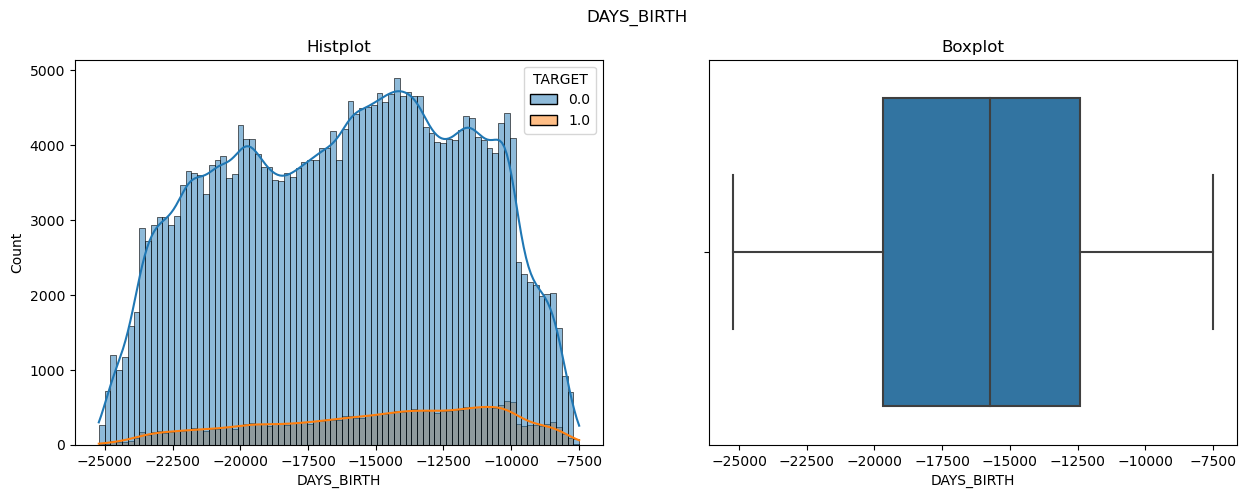

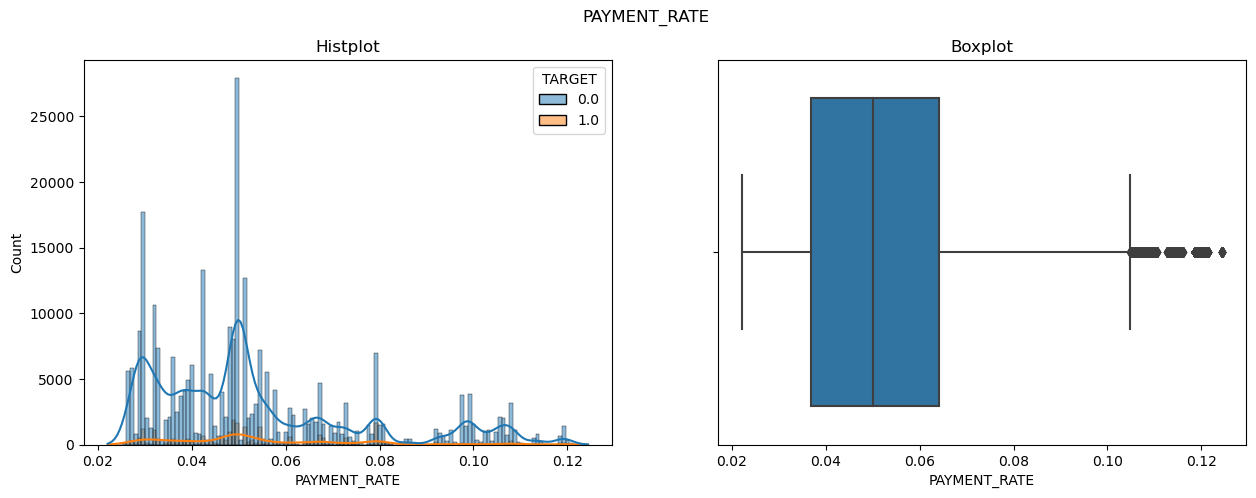

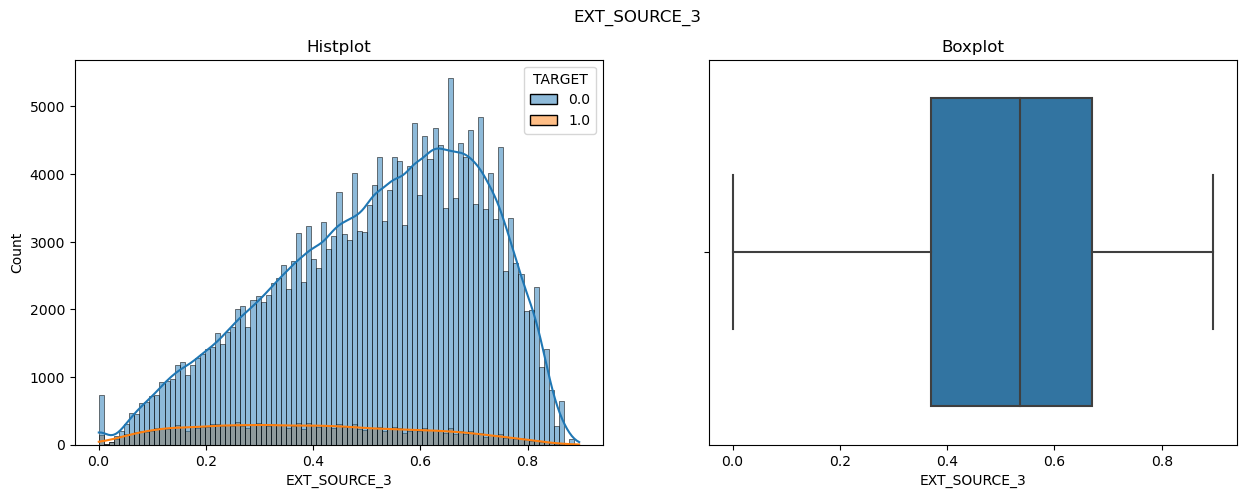

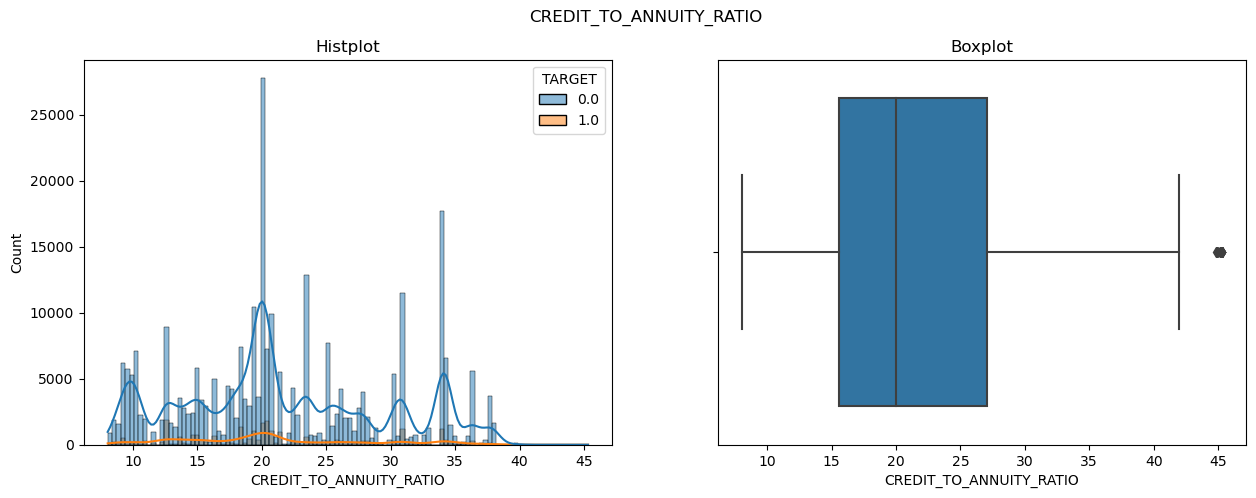

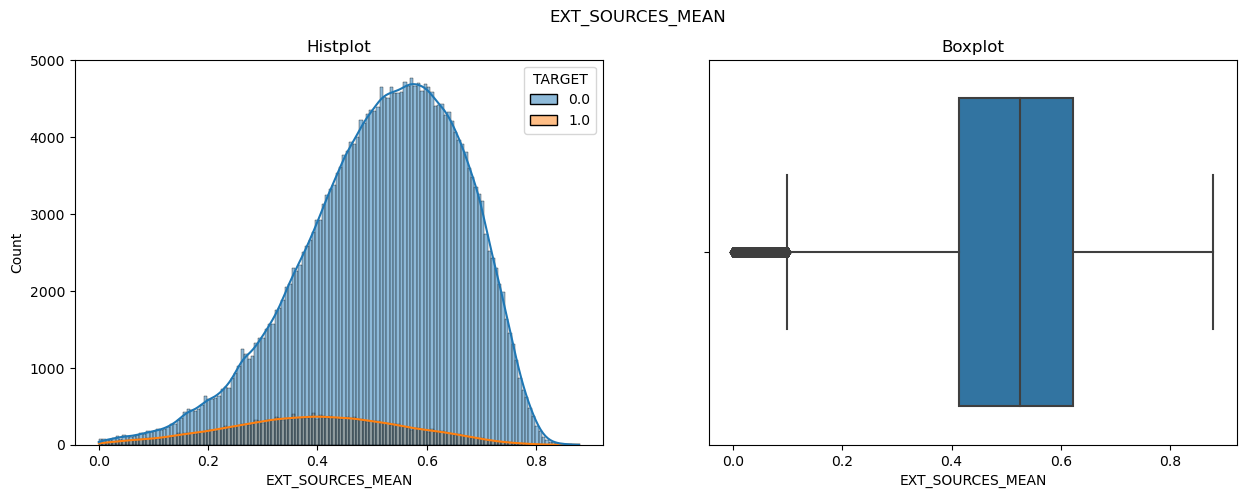

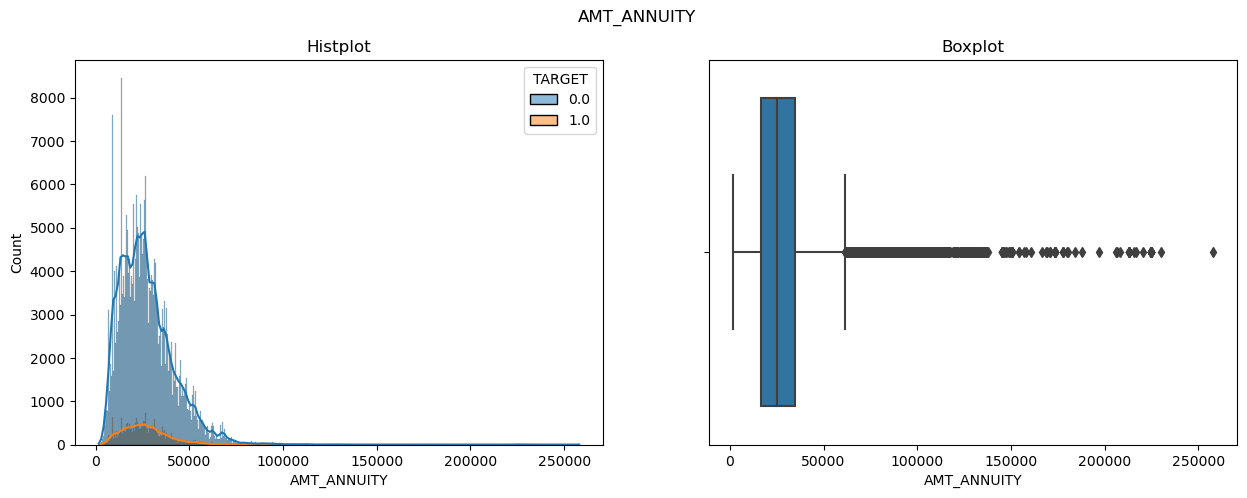

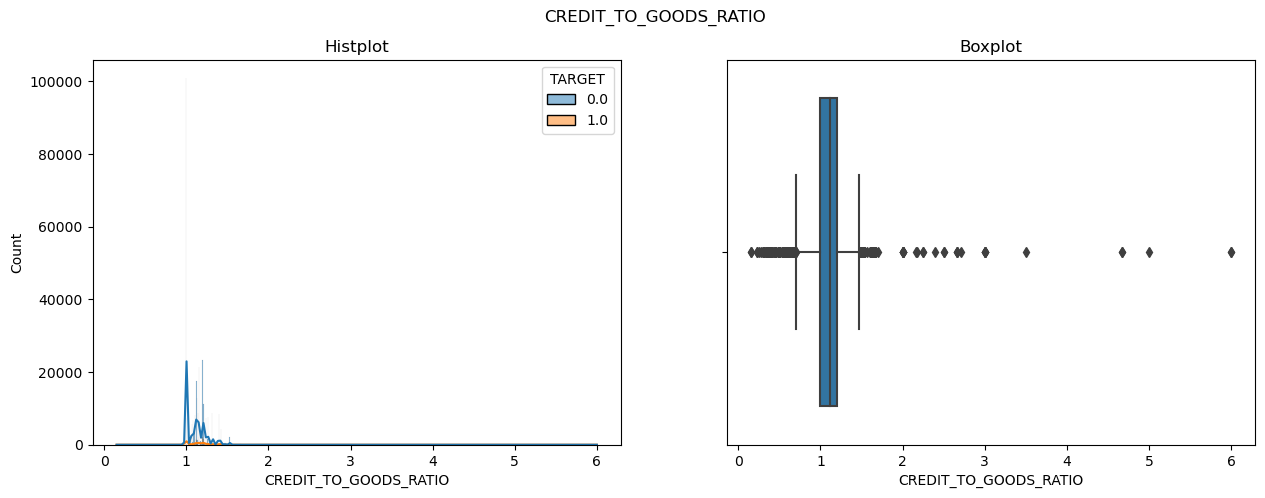

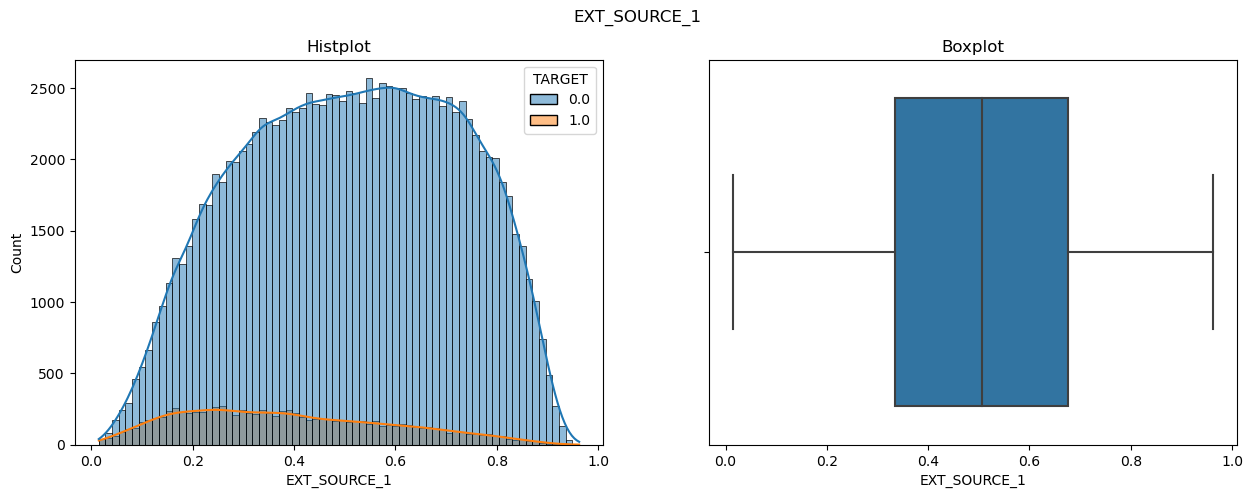

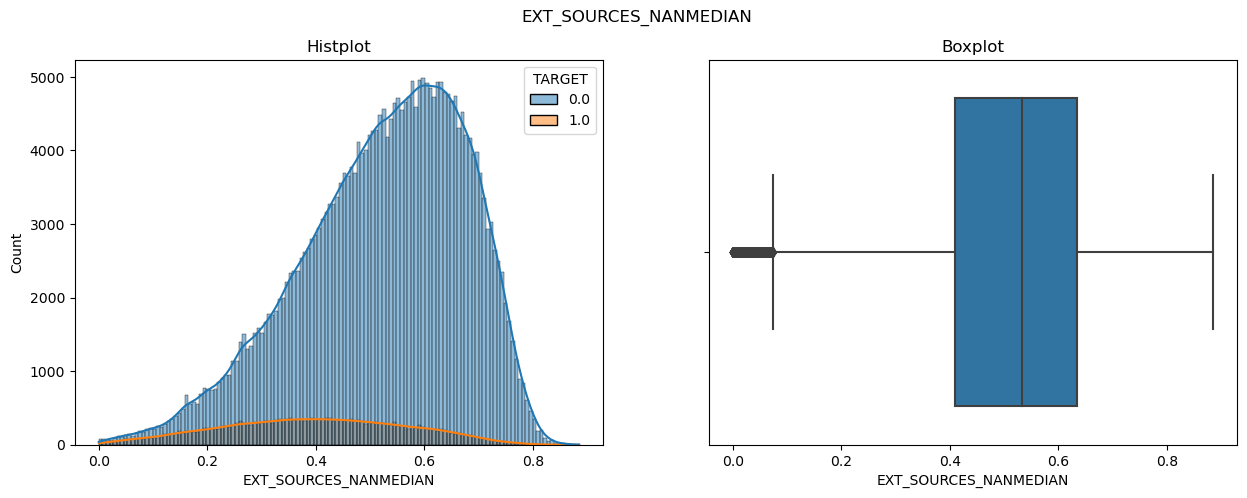

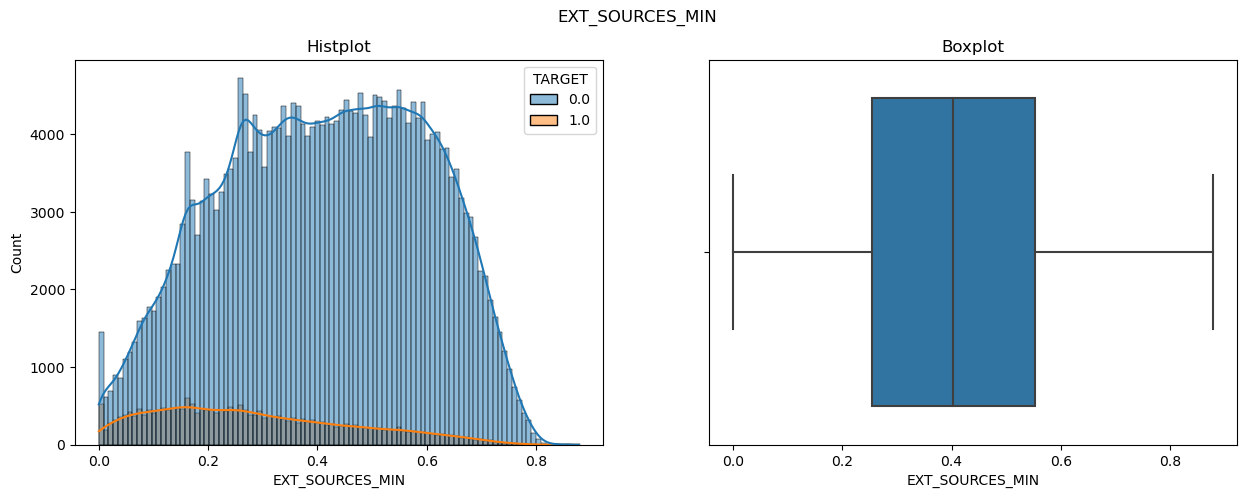

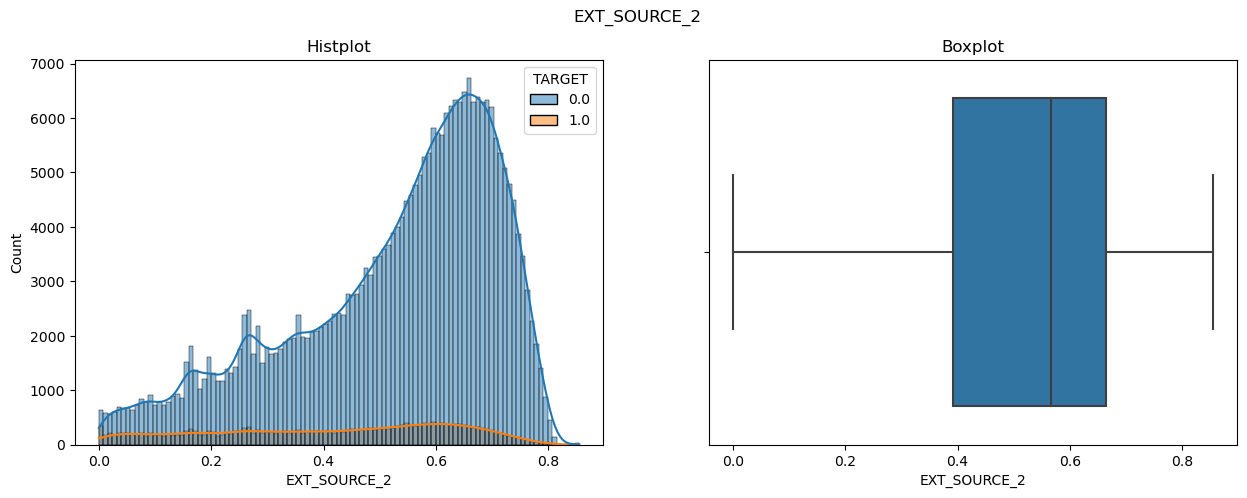

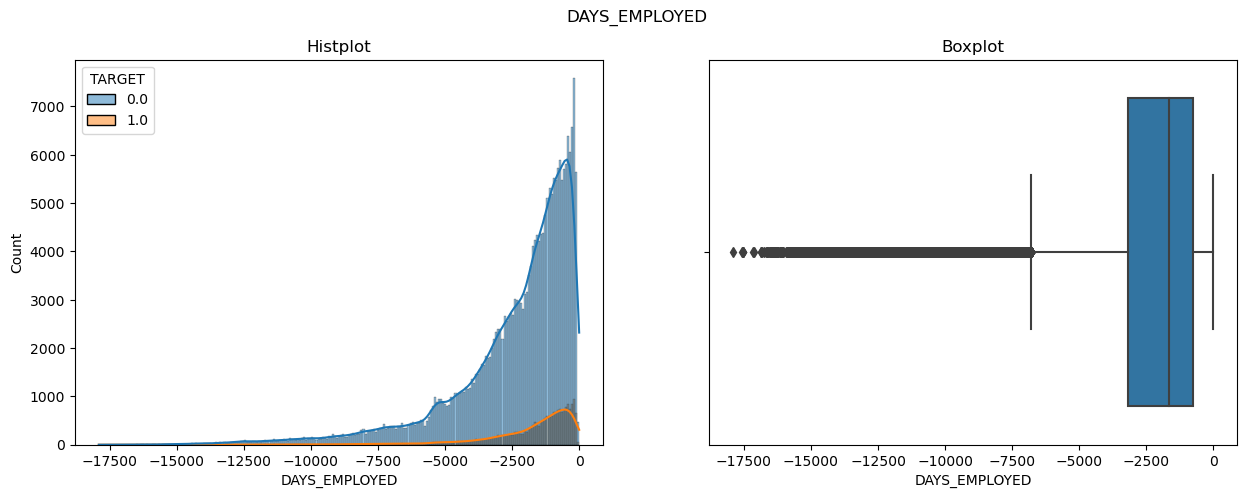

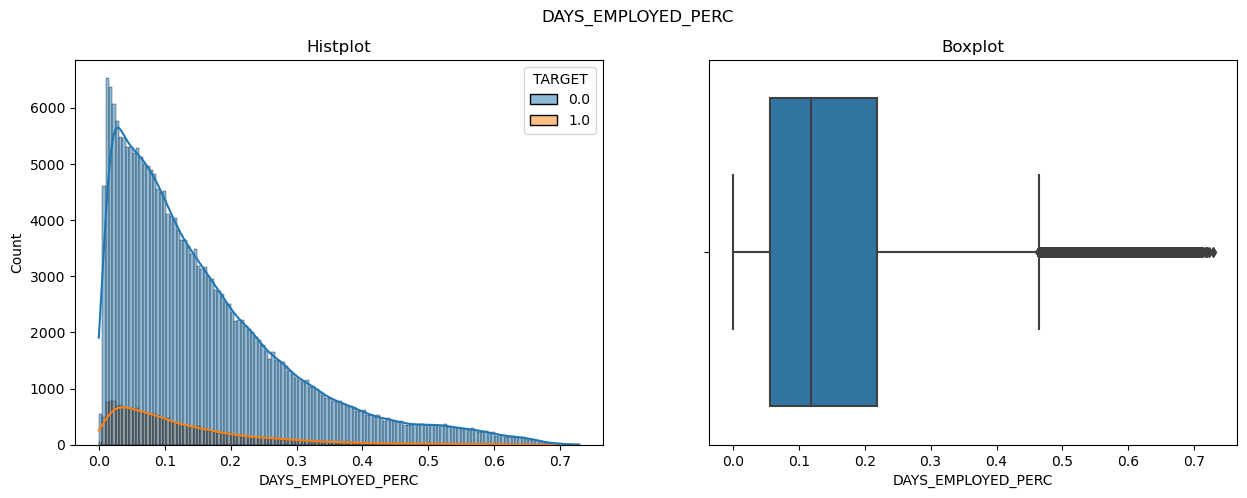

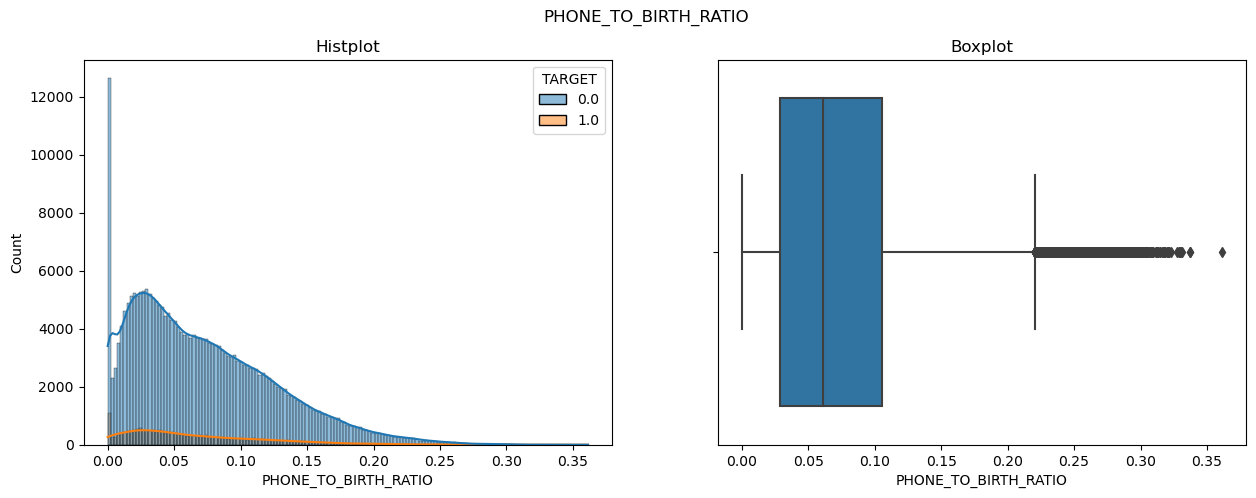

KeyboardInterrupt: 

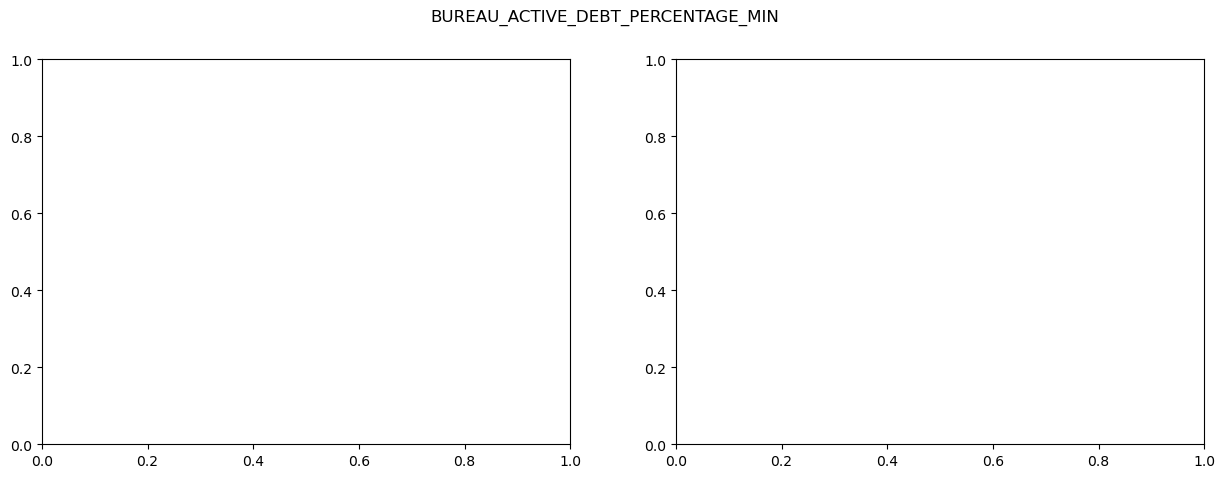

In [17]:
for var in cols :
    plots_uniVariable(data_train, var, var, 'Histplot', 'Boxplot')
    

In [18]:
correlations = data_train.corr()['TARGET'].sort_values()

In [19]:
correlations.head(20)

EXT_SOURCES_WEIGHTED                      -0.230532
EXT_SOURCES_MEAN                          -0.222040
EXT_SOURCES_NANMEDIAN                     -0.218100
EXT_SOURCES_MAX                           -0.196870
EXT_SOURCES_PROD                          -0.188527
EXT_SOURCES_MIN                           -0.185258
EXT_SOURCE_3                              -0.178906
EXT_SOURCE_2                              -0.160452
EXT_SOURCE_1                              -0.155319
BUREAU_MONTHS_BALANCE_SIZE_MEAN           -0.080193
BUREAU_CREDIT_ACTIVE_Closed_MEAN          -0.079357
PREV_CODE_REJECT_REASON_XAP_MEAN          -0.073928
EMPLOYED_TO_BIRTH_RATIO                   -0.067945
DAYS_EMPLOYED_PERC                        -0.067945
BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_MEAN    -0.065154
PREV_NAME_CONTRACT_STATUS_Approved_MEAN   -0.063523
CC_COUNT                                  -0.060481
CC_NAME_CONTRACT_STATUS_Active_SUM        -0.059376
CC_MONTHS_BALANCE_VAR                     -0.058817
BUREAU_CLOSE

In [20]:
correlations.tail(20)

PREV_NAME_GOODS_CATEGORY_HouseConstruction_MEAN   NaN
PREV_NAME_GOODS_CATEGORY_nan_MEAN                 NaN
PREV_NAME_PORTFOLIO_nan_MEAN                      NaN
PREV_NAME_PRODUCT_TYPE_nan_MEAN                   NaN
PREV_CHANNEL_TYPE_nan_MEAN                        NaN
PREV_NAME_SELLER_INDUSTRY_nan_MEAN                NaN
PREV_NAME_YIELD_GROUP_nan_MEAN                    NaN
POS_NAME_CONTRACT_STATUS_nan_MEAN                 NaN
CC_SK_DPD_MIN                                     NaN
CC_SK_DPD_DEF_MIN                                 NaN
CC_NAME_CONTRACT_STATUS_Approved_MIN              NaN
CC_NAME_CONTRACT_STATUS_Demand_MIN                NaN
CC_NAME_CONTRACT_STATUS_Refused_MIN               NaN
CC_NAME_CONTRACT_STATUS_Sentproposal_MIN          NaN
CC_NAME_CONTRACT_STATUS_nan_MIN                   NaN
CC_NAME_CONTRACT_STATUS_nan_MAX                   NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN                  NaN
CC_NAME_CONTRACT_STATUS_nan_SUM                   NaN
CC_NAME_CONTRACT_STATUS_nan_

In [42]:
data1 = data.copy(deep = True)

# Imputation des valeurs NaN par la médiane

In [75]:
from sklearn.impute import KNNImputer, SimpleImputer

data1.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy = 'median')
data_Imputed = imputer.fit_transform(data1)

In [76]:
data_Imputed.shape

(356250, 841)

In [82]:
data1_Imputed = pd.DataFrame(data_Imputed, columns=data1.columns)

In [84]:
# Standardisation des données du dataset
from sklearn.preprocessing import MinMaxScaler

# Fonction pour standardisation des données du dataset
def std_dataset(df_in, method_std):
    df_in_std = pd.DataFrame(method_std.fit_transform(df_in), columns = df_in.columns)
    
    return df_in_std

In [85]:
scaler = MinMaxScaler()
data1_Imputed_std = std_dataset(data1_Imputed, scaler)

In [105]:
data1_Imputed_std

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
0         0.000003     1.0          0.0           0.0          0.009839   
1         0.000006     0.0          1.0           0.0          0.013594   
2         0.000008     0.0          0.0           1.0          0.002328   
3         0.000014     0.0          1.0           0.0          0.006084   
4         0.000017     0.0          0.0           0.0          0.005333   
...            ...     ...          ...           ...               ...   
356245    0.999905     0.0          1.0           0.0          0.005333   
356246    0.999907     0.0          1.0           0.0          0.007335   
356247    0.999910     0.0          1.0           1.0          0.009839   
356248    0.999913     0.0          0.0           0.0          0.011091   
356249    0.999986     0.0          1.0           1.0          0.006084   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0         0.090287     0.090032         0.077441                    0.256702   
1         0.311736     0.132924         0.271605                    0.045506   
2         0.022472     0.020025         0.023569                    0.135340   
3         0.066837     0.109477         0.063973                    0.107480   
4         0.116854     0.078975         0.117845                    0.393191   
...            ...          ...              ...                         ...   
356245    0.091775     0.061846         0.057239                    0.024760   
356246    0.144173     0.118147         0.113356                    0.491855   
356247    0.067416     0.123201         0.068462                    0.361760   
356248    0.101124     0.091699         0.102132                    0.257380   
356249    0.066858     0.090067         0.057239                    0.088243   

        DAYS_BIRTH  ...  CC_LATE_PAYMENT_MIN  CC_LATE_PAYMENT_MAX  \
0         0.881337  ...                  0.0                  0.0   
1         0.473087  ...                  0.0                  0.0   
2         0.345593  ...                  0.0                  0.0   
3         0.347884  ...                  0.0                  0.0   
4         0.296071  ...                  0.0                  0.0   
...            ...  ...                  ...                  ...   
356245    0.293947  ...                  0.0                  0.0   
356246    0.784920  ...                  0.0                  0.0   
356247    0.520206  ...                  0.0                  0.0   
356248    0.629423  ...                  0.0                  0.0   
356249    0.629758  ...                  0.0                  0.0   

        CC_LATE_PAYMENT_MEAN  CC_LATE_PAYMENT_SUM  CC_LATE_PAYMENT_VAR  \
0                        0.0                  0.0                  0.0   
1                        0.0                  0.0                  0.0   
2                        0.0                  0.0                  0.0   
3                        0.0                  0.0                  0.0   
4                        0.0                  0.0                  0.0   
...                      ...                  ...                  ...   
356245                   0.0                  0.0                  0.0   
356246                   0.0                  0.0                  0.0   
356247                   0.0                  0.0                  0.0   
356248                   0.0                  0.0                  0.0   
356249                   0.0                  0.0                  0.0   

        CC_DRAWING_LIMIT_RATIO_MIN  CC_DRAWING_LIMIT_RATIO_MAX  \
0                              0.0                     0.06250   
1                              0.0                     0.06250   
2                              0.0                     0.06250   
3                              0.0                     0.06250   
4                              0.0                     0.06250   
...                            .

In [59]:
data1_Imputed.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
0    100002.0     1.0          0.0           0.0          202500.0   
1    100003.0     0.0          1.0           0.0          270000.0   
2    100004.0     0.0          0.0           1.0           67500.0   
3    100006.0     0.0          1.0           0.0          135000.0   
4    100007.0     0.0          0.0           0.0          121500.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    406597.5      24700.5         351000.0                    0.018801   
1   1293502.5      35698.5        1129500.0                    0.003541   
2    135000.0       6750.0         135000.0                    0.010032   
3    312682.5      29686.5         297000.0                    0.008019   
4    513000.0      21865.5         513000.0                    0.028663   

   DAYS_BIRTH  ...  CC_LATE_PAYMENT_MIN  CC_LATE_PAYMENT_MAX  \
0     -9461.0  ...                  0.0                  0.0   
1    -16765.0  ...                  0.0                  0.0   
2    -19046.0  ...                  0.0                  0.0   
3    -19005.0  ...                  0.0                  0.0   
4    -19932.0  ...                  0.0                  0.0   

   CC_LATE_PAYMENT_MEAN  CC_LATE_PAYMENT_SUM  CC_LATE_PAYMENT_VAR  \
0                   0.0                  0.0                  0.0   
1                   0.0                  0.0                  0.0   
2                   0.0                  0.0                  0.0   
3                   0.0                  0.0                  0.0   
4                   0.0                  0.0                  0.0   

   CC_DRAWING_LIMIT_RATIO_MIN  CC_DRAWING_LIMIT_RATIO_MAX  \
0                         0.0                         0.5   
1                         0.0                         0.5   
2                         0.0                         0.5   
3                         0.0                         0.5   
4                         0.0                         0.5   

   CC_DRAWING_LIMIT_RATIO_MEAN  CC_DRAWING_LIMIT_RATIO_SUM  CC_COUNT  
0                     0.033333                       0.375      22.0  
1                     0.033333                       0.375      22.0  
2                     0.033333                       0.375      22.0  
3                     0.033333                       0.000       6.0  
4                     0.033333                       0.375      22.0  

[5 rows x 841 columns]

# PCA(0.95)

In [39]:
def display_scree_plot(MonPCA):
    """
    Graph representing the eigenvalues of the pca model based on the file
    under study
    pca : pca of the model"""
    scree = MonPCA.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Eboulis des valeurs propres")  
    plt.show(block=False)
    
    return

In [74]:
data1_Imputed.shape[1]

841

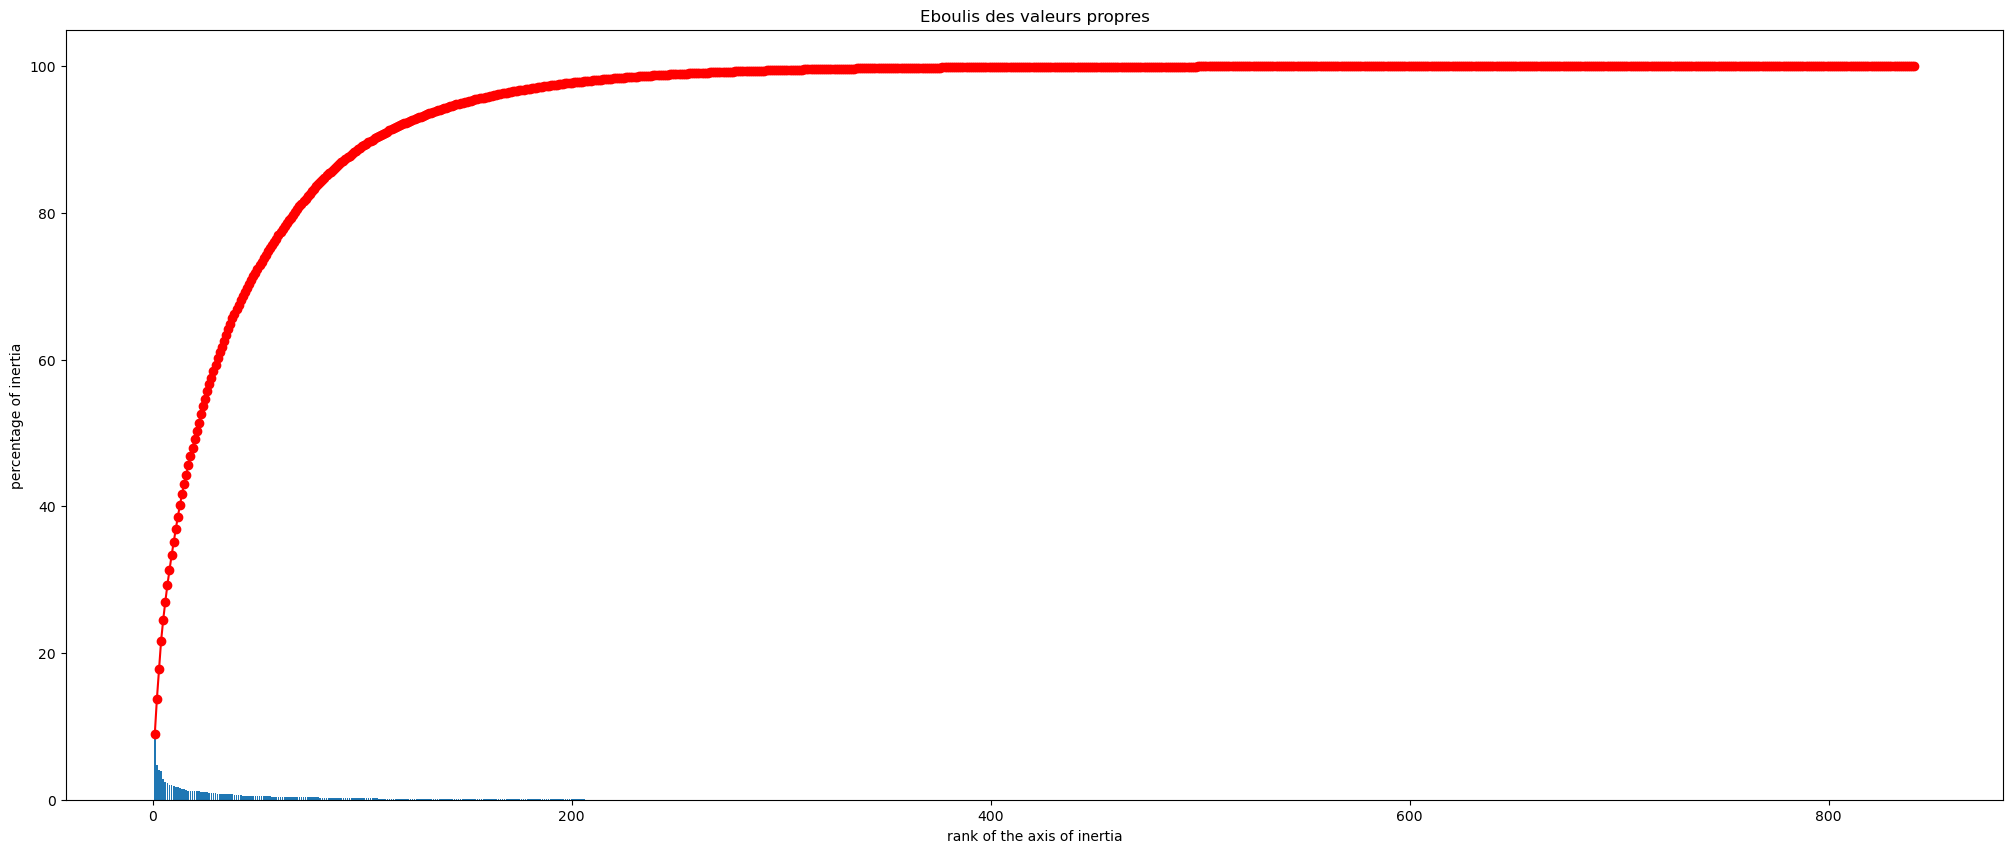

In [87]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = PCA(n_components=data1_Imputed.shape[1])

data_PCA = pca.fit_transform(data1_Imputed_std)

plt.figure(figsize=(25, 10))
display_scree_plot(pca)


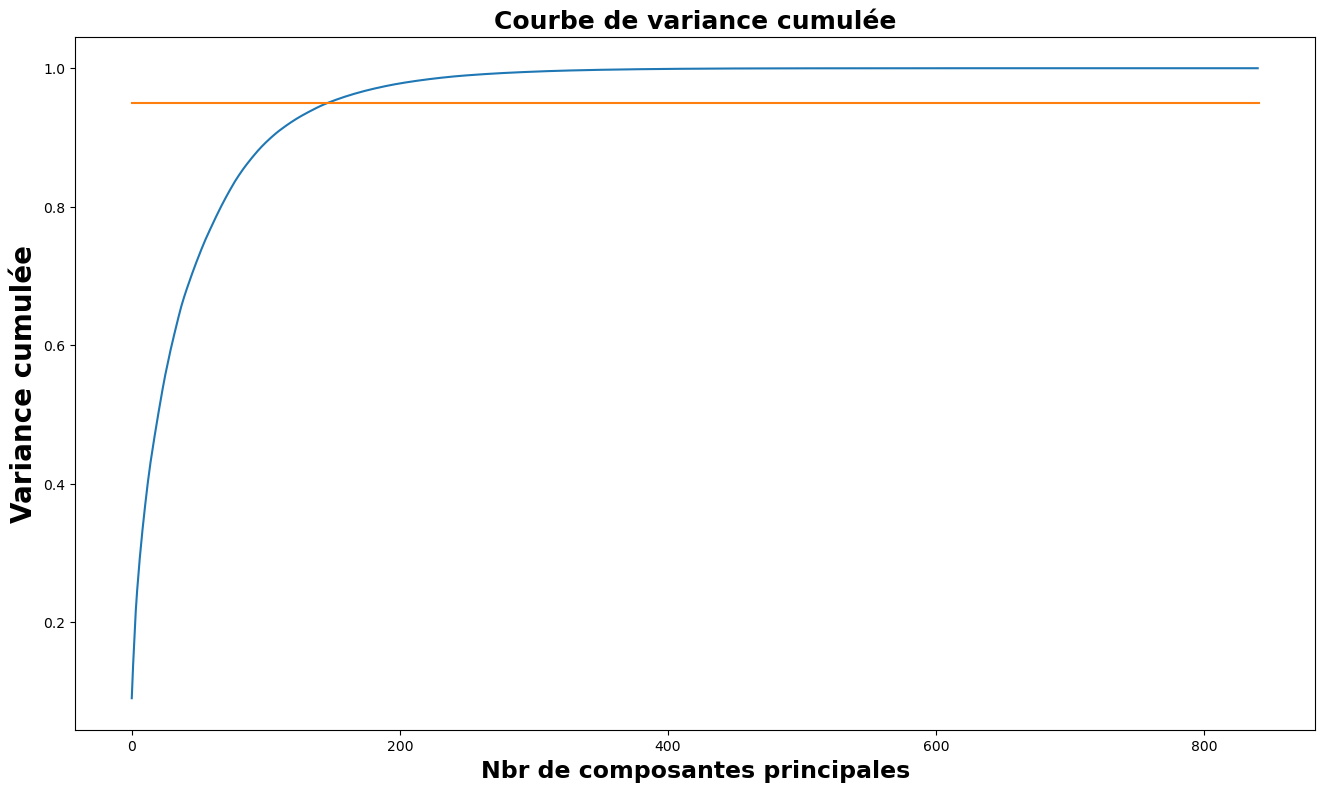

In [90]:
plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Courbe de variance cumulée', size=18, weight='bold')
plt.plot([0, data1_Imputed.shape[1]], [0.95, 0.95])

In [91]:
c = 0
for i in pca.explained_variance_ratio_.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 95% de la variance du dataset.'.format(c))
        break
    

Il faut 148 composantes pour expliquer 95% de la variance du dataset.


In [92]:
pca = PCA(n_components = 0.95, random_state=42)
data_PCA = pca.fit_transform(data1_Imputed_std)

print("Dimensions dataset avant réduction PCA : ", data1_Imputed_std.shape)

print("Dimensions dataset après réduction PCA : ", data_PCA.shape)

Dimensions dataset avant réduction PCA :  (356250, 841)
Dimensions dataset après réduction PCA :  (356250, 148)


In [107]:
## 2.5 Séparation du dataset en train et test comme à l'origine <a class="anchor" id="section2.5"></a>

data_train = data1_Imputed_std[data1_Imputed_std['SK_ID_CURR'].isin(application_train["SK_ID_CURR"])]
print("\n Taille de données de train:", data_train.shape)

data_test = data1_Imputed_std[data1_Imputed_std['SK_ID_CURR'].isin(application_test["SK_ID_CURR"])]
data_test = data_test.drop('TARGET', axis=1)
print("\n Taille de données de test:", data_test.shape)


 Taille de données de train: (0, 841)

 Taille de données de test: (0, 840)


# 3. Nettoyage et traitement du jeu de données <a class="anchor" id="chapter3"></a>

In [27]:
data = chargement_data('C:\\Users\\LEMuon\\Downloads\\P5_Dataset_fini_merge.csv')
data.drop('Unnamed: 0', axis = 1, inplace=True)

Unnamed: 0                       customer_id  \
0           0  06b8999e2fba1a1fbc88172c00ba8bc7   
1           1  18955e83d337fd6b2def6b18a428ac77   
2           2  4e7b3e00288586ebd08712fdd0374a03   
3           3  b2b6027bc5c5109e529d4dc6358b12c3   
4           4  4f2d8ab171c80ec8364f7c12e35b23ad   

                 customer_unique_id  customer_zip_code_prefix_x  \
0  861eff4711a542e4b93843c6dd7febb0                       14409   
1  290c77bc529b7ac935b93aa66c333dc3                        9790   
2  060e732b5b29e8181a18229c7b0b2b5e                        1151   
3  259dac757896d24d7702b9acbbff3f3c                        8775   
4  345ecd01c38d18a9036ed96c73b8d066                       13056   

           customer_city  customer_latitude  customer_longitude  \
0                 franca         -20.502070          -47.396822   
1  sao bernardo do campo         -23.727299          -46.542631   
2              sao paulo         -23.531294          -46.656404   
3        mogi das cruzes         -23.497390          -46.182342   
4               campinas         -22.973309          -47.141530   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

   ...                        product_id product_category_name  \
0  ...  a9516a079e37a9c9c36b9b78b10169e8      office_furniture   
1  ...  4aa6014eceb682077f9dc4bffebc05b0            housewares   
2  ...  bd07b66896d6f1494f5b86251848ced7      office_furniture   
3  ...  a5647c44af977b148e0a3a4751a09e2e      office_furniture   
4  ...  9391a573abe00141c56e38d84d7d5b3b          home_confort   

   shipping_limit_date   price  freight_value  \
0  2017-05-22 15:22:12  124.99          21.88   
1  2018-01-18 20:58:32  289.00          46.48   
2  2018-06-05 16:19:10  139.94          17.79   
3  2018-03-27 16:31:16  149.94          23.36   
4  2018-07-31 10:10:09  230.00          22.25   

                          seller_id  customer_zip_code_prefix_y  \
0  7c67e1448b00f6e969d365cea6b010ab                      8577.0   
1  b8bc237ba3788b23da09c0f1f3a3288c                     88303.0   
2  7c67e1448b00f6e969d365cea6b010ab                      8577.0   
3  7c67e1448b00f6e969d365cea6b010ab                      8577.0   
4  4a3ca9315b744ce9f8e9374361493884                     14940.0   

       seller_city seller_latitude  seller_longitude  
0  itaquaquecetuba      -23.484880        -46.366550  
1           itajai      -26.912616        -48.674015  
2  itaquaquecetuba      -23.484880        -46.366550  
3  itaquaquecetuba      -23.484880        -46.366550  
4         ibitinga      -21.757690        -48.829768  

[5 rows x 35 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     119143 non-null  int64  
 1   customer_id                    119143 non-null  object 
 2   customer_unique_id             119143 non-null  object 
 3   customer_zip_code_prefix_x     119143 non-null  int64  
 4   customer_city                  119143 non-null  object 
 5   customer_latitude              118821 non-null  float64
 6   customer_longitude             118821 non-null  float64
 7   order_id                       119143 non-null  object 
 8   order_status                   119143 non-null  object 
 9   order_purchase_timestamp       119143 non-null  object 
 10  order_approved_at              118966 non-null  object 
 11  order_delivered_carrier_date   117057 non-null  object 
 12  order_delivered_customer_date 

<AxesSubplot:>

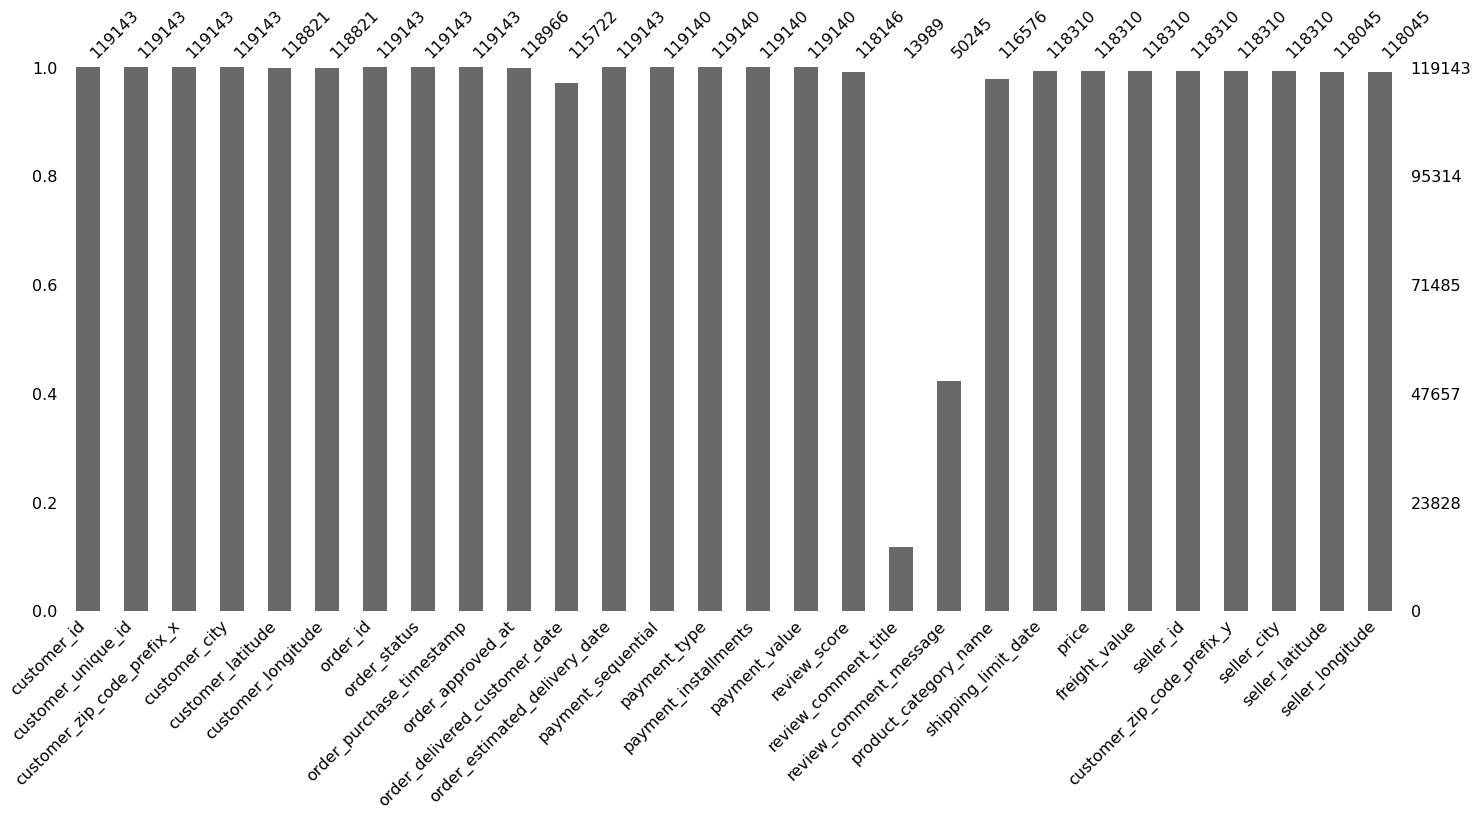

In [38]:
msn.bar(data)

## 3.1 Supprimer quelques colonnes non pertinentes pour la segmentation <a class="anchor" id="section_3.1"></a>

On commence par supprimer les variables inutiles.

In [28]:
data.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title'], axis=1, inplace=True)
data.drop(['order_delivered_carrier_date', 'product_id', 'order_item_id'], axis=1, inplace=True)

## 3.2 Changer les types des variables temps <a class="anchor" id="section_3.2"></a>

On va modifier le typage des dates.

In [29]:
listeVarDates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 
                 'order_estimated_delivery_date', 'shipping_limit_date']

for cols in listeVarDates:
    data[cols] = pd.to_datetime(data[cols], format="%Y-%m-%d", errors="ignore")

In [30]:
summary_columns(data)

Variable name   Variable type  Missing values  % Missing
0                     customer_id          object               0   0.000000
1              customer_unique_id          object               0   0.000000
2      customer_zip_code_prefix_x           int64               0   0.000000
3                   customer_city          object               0   0.000000
4               customer_latitude         float64             322   0.270263
5              customer_longitude         float64             322   0.270263
6                        order_id          object               0   0.000000
7                    order_status          object               0   0.000000
8        order_purchase_timestamp  datetime64[ns]               0   0.000000
9               order_approved_at  datetime64[ns]             177   0.148561
10  order_delivered_customer_date  datetime64[ns]            3421   2.871339
11  order_estimated_delivery_date  datetime64[ns]               0   0.000000
12             payment_sequential         float64               3   0.002518
13                   payment_type          object               3   0.002518
14           payment_installments         float64               3   0.002518
15                  payment_value         float64               3   0.002518
16                   review_score         float64             997   0.836810
17         review_comment_message          object           68898  57.827988
18          product_category_name          object            2567   2.154554
19            shipping_limit_date  datetime64[ns]             833   0.699160
20                          price         float64             833   0.699160
21                  freight_value         float64             833   0.699160
22                      seller_id          object             833   0.699160
23     customer_zip_code_prefix_y         float64             833   0.699160
24                    seller_city          object             833   0.699160
25                seller_latitude         float64            1098   0.921582
26               seller_longitude         float64            1098   0.921582

## 3.3 Calculer le délai de livraison réel et estimé <a class="anchor" id="section_3.3"></a>

On va  calculer les délais de livraison réels et estimés des commandes en utilisant les variables `order_purchase_timestamp`, `order_delivered_customer_date` et `order_estimated_delivery_date`. Pour en faciliter l'utilisation, on va les changer en durée (en jours).

In [31]:
data['real_delivery_time'] = data['order_delivered_customer_date'] - data['order_approved_at']
data['estimated_delivery_time'] = data['order_estimated_delivery_date'] - data['order_approved_at']

for cols in ['real_delivery_time', 'estimated_delivery_time']:
    data[cols] = data[cols].dt.days

data.drop(['order_delivered_customer_date', 'order_estimated_delivery_date', 'order_approved_at'], axis=1, inplace=True)

In [32]:
summary_columns(data)

Variable name   Variable type  Missing values  % Missing
0                  customer_id          object               0   0.000000
1           customer_unique_id          object               0   0.000000
2   customer_zip_code_prefix_x           int64               0   0.000000
3                customer_city          object               0   0.000000
4            customer_latitude         float64             322   0.270263
5           customer_longitude         float64             322   0.270263
6                     order_id          object               0   0.000000
7                 order_status          object               0   0.000000
8     order_purchase_timestamp  datetime64[ns]               0   0.000000
9           payment_sequential         float64               3   0.002518
10                payment_type          object               3   0.002518
11        payment_installments         float64               3   0.002518
12               payment_value         float64               3   0.002518
13                review_score         float64             997   0.836810
14      review_comment_message          object           68898  57.827988
15       product_category_name          object            2567   2.154554
16         shipping_limit_date  datetime64[ns]             833   0.699160
17                       price         float64             833   0.699160
18               freight_value         float64             833   0.699160
19                   seller_id          object             833   0.699160
20  customer_zip_code_prefix_y         float64             833   0.699160
21                 seller_city          object             833   0.699160
22             seller_latitude         float64            1098   0.921582
23            seller_longitude         float64            1098   0.921582
24          real_delivery_time         float64            3436   2.883929
25     estimated_delivery_time         float64             177   0.148561

## 3.4 Calculer la distance entre le client et le vendeur <a class="anchor" id="section_3.4"></a> 

In [33]:
data['distance_customer_seller'] = [haversine((x_C, y_C), (x_S, y_S))
                                        for x_C, y_C, x_S, y_S in zip(data.customer_latitude.astype(float), data.customer_longitude.astype(float),
                                                                      data.seller_latitude.astype(float), data.seller_longitude.astype(float))]

data.drop(['customer_latitude', 'customer_longitude', 'seller_latitude', 'seller_longitude'], axis=1, inplace=True)


In [34]:
summary_columns(data)

Variable name   Variable type  Missing values  % Missing
0                  customer_id          object               0   0.000000
1           customer_unique_id          object               0   0.000000
2   customer_zip_code_prefix_x           int64               0   0.000000
3                customer_city          object               0   0.000000
4                     order_id          object               0   0.000000
5                 order_status          object               0   0.000000
6     order_purchase_timestamp  datetime64[ns]               0   0.000000
7           payment_sequential         float64               3   0.002518
8                 payment_type          object               3   0.002518
9         payment_installments         float64               3   0.002518
10               payment_value         float64               3   0.002518
11                review_score         float64             997   0.836810
12      review_comment_message          object           68898  57.827988
13       product_category_name          object            2567   2.154554
14         shipping_limit_date  datetime64[ns]             833   0.699160
15                       price         float64             833   0.699160
16               freight_value         float64             833   0.699160
17                   seller_id          object             833   0.699160
18  customer_zip_code_prefix_y         float64             833   0.699160
19                 seller_city          object             833   0.699160
20          real_delivery_time         float64            3436   2.883929
21     estimated_delivery_time         float64             177   0.148561
22    distance_customer_seller         float64            1414   1.186809

## 3.5 Grouper les commandes par client <a class="anchor" id="section_3.5"></a> 

Certains clients ont effectué plusieurs commandes. Chaque commande a une identité de commande et une identité de client. 

Un client ayant créé un compte peut enregistrer sa commande avec son identité de compte. Sinon, on le considère comme un nouveau client.

In [35]:
data['customer_unique_id'].nunique()

96096

In [36]:
data['customer_id'].nunique()

99441

In [37]:
data['order_id'].nunique()

99441

On va donc grouper pour chaque identité de compte de client : 
 - le nombre totale de commandes, <br>
 - la somme totale dépensée, <br>
 - la somme totale de frais de livraison, <br>
 - les délais réel et estimé de livraison moyens,<br>
 - la note moyenne,<br>
 - nombre moyen de paiements,<br>
 - dernière date de commande.`<br>


In [523]:
#display(data[data.duplicated(subset="customer_id", keep=False)])

In [38]:
#snapshot_date = max(data_RFM.order_purchase_timestamp) + datetime.timedelta(days=1)
snapshot_date = max(data.order_purchase_timestamp) + datetime.timedelta(days=1)

# 1 order = 1 order_id = 1 customer_id , 1 customer_unique_id peut faire plusieurs commandes
data_gb = data.groupby('customer_unique_id').agg(nb_ordres = ('order_id', 'count'),
                                                 payment_sequential = ('payment_sequential', max),
                                                 payment_type = ('payment_type', max),
                                                 payment_installments = ('payment_installments', max),
                                                 payment_value = ('payment_value', sum),
                                                 total_price = ('price', sum),
                                                 total_freight_value = ('freight_value', sum),
                                                 mean_price = ('price', 'mean'),
                                                 mean_freight_value = ('freight_value', 'mean'),
                                                 last_order_purchase_timestamp = ('order_purchase_timestamp', max),
                                                 last_order_date = ('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
                                                 mean_real_delivery_time = ('real_delivery_time', 'mean'),
                                                 mean_estimated_delivery_time = ('estimated_delivery_time', 'mean'),
                                                 review_score = ('review_score', max))
                                
display(data_gb)


nb_ordres  payment_sequential payment_type  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2          1                 1.0  credit_card   
0000b849f77a49e4a4ce2b2a4ca5be3f          1                 1.0  credit_card   
0000f46a3911fa3c0805444483337064          1                 1.0  credit_card   
0000f6ccb0745a6a4b88665a16c9f078          1                 1.0  credit_card   
0004aac84e0df4da2b147fca70cf8255          1                 1.0  credit_card   
...                                     ...                 ...          ...   
fffcf5a5ff07b0908bd4e2dbc735a684          2                 1.0  credit_card   
fffea47cd6d3cc0a88bd621562a9d061          1                 1.0  credit_card   
ffff371b4d645b6ecea244b27531430a          1                 1.0  credit_card   
ffff5962728ec6157033ef9805bacc48          1                 1.0  credit_card   
ffffd2657e2aad2907e67c3e9daecbeb          1                 1.0  credit_card   

                                  payment_installments  payment_value  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2                   8.0         141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f                   1.0          27.19   
0000f46a3911fa3c0805444483337064                   8.0          86.22   
0000f6ccb0745a6a4b88665a16c9f078                   4.0          43.62   
0004aac84e0df4da2b147fca70cf8255                   6.0         196.89   
...                                                ...            ...   
fffcf5a5ff07b0908bd4e2dbc735a684                  10.0        4134.84   
fffea47cd6d3cc0a88bd621562a9d061                   1.0          84.58   
ffff371b4d645b6ecea244b27531430a                   1.0         112.46   
ffff5962728ec6157033ef9805bacc48                   5.0         133.69   
ffffd2657e2aad2907e67c3e9daecbeb                   4.0          71.56   

                                  total_price  total_freight_value  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2       129.90                12.00   
0000b849f77a49e4a4ce2b2a4ca5be3f        18.90                 8.29   
0000f46a3911fa3c0805444483337064        69.00                17.22   
0000f6ccb0745a6a4b88665a16c9f078        25.99                17.63   
0004aac84e0df4da2b147fca70cf8255       180.00                16.89   
...                                       ...                  ...   
fffcf5a5ff07b0908bd4e2dbc735a684      1570.00               497.42   
fffea47cd6d3cc0a88bd621562a9d061        64.89                19.69   
ffff371b4d645b6ecea244b27531430a        89.90                22.56   
ffff5962728ec6157033ef9805bacc48       115.00                18.69   
ffffd2657e2aad2907e67c3e9daecbeb        56.99                14.57   

                                  mean_price  mean_freight_value  \
customer_unique_id                                                 
0000366f3b9a7992bf8c76cfdf3221e2      129.90               12.00   
0000b849f77a49e4a4ce2b2a4ca5be3f       18.90                8.29   
0000f46a3911fa3c0805444483337064       69.00               17.22   
0000f6ccb0745a6a4b88665a16c9f078       25.99               17.63   
0004aac84e0df4da2b147fca70cf8255      180.00               16.89   
...                                      ...                 ...   
fffcf5a5ff07b0908bd4e2dbc735a684      785.00              248.71   
fffea47cd6d3cc0a88bd621562a9d061       64.89               19.69   
ffff371b4d645b6ecea244b27531430a       89.90               22.56   
ffff5962728ec6157033ef9805bacc48      115.00               18.69   
ffffd2657e2aad2907e67c3e9daecbeb       56.99               14.57   

                                 last_order_purchase_timestamp  \
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2           2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f           2018-0

In [39]:
data_gb.index.nunique()

96096

In [40]:
data.drop(['customer_id', 'order_id', 'review_score', 'price', 'payment_sequential', 'order_purchase_timestamp',
           'estimated_delivery_time', 'real_delivery_time', 'payment_type', 'payment_installments', 
           'payment_value', 'freight_value'], axis=1, inplace=True)

data = merge_data(data, data_gb, 'customer_unique_id')

customer_unique_id  customer_zip_code_prefix_x  \
0  861eff4711a542e4b93843c6dd7febb0                       14409   
1  290c77bc529b7ac935b93aa66c333dc3                        9790   
2  060e732b5b29e8181a18229c7b0b2b5e                        1151   
3  259dac757896d24d7702b9acbbff3f3c                        8775   
4  345ecd01c38d18a9036ed96c73b8d066                       13056   

           customer_city order_status  \
0                 franca    delivered   
1  sao bernardo do campo    delivered   
2              sao paulo    delivered   
3        mogi das cruzes    delivered   
4               campinas    delivered   

                          review_comment_message product_category_name  \
0                                            NaN      office_furniture   
1                                            NaN            housewares   
2                                            NaN      office_furniture   
3                                            NaN      office_furniture   
4  O baratheon è esxelente Amo adoro o baratheon          home_confort   

  shipping_limit_date                         seller_id  \
0 2017-05-22 15:22:12  7c67e1448b00f6e969d365cea6b010ab   
1 2018-01-18 20:58:32  b8bc237ba3788b23da09c0f1f3a3288c   
2 2018-06-05 16:19:10  7c67e1448b00f6e969d365cea6b010ab   
3 2018-03-27 16:31:16  7c67e1448b00f6e969d365cea6b010ab   
4 2018-07-31 10:10:09  4a3ca9315b744ce9f8e9374361493884   

   customer_zip_code_prefix_y      seller_city  ...  payment_value  \
0                      8577.0  itaquaquecetuba  ...         146.87   
1                     88303.0           itajai  ...         335.48   
2                      8577.0  itaquaquecetuba  ...         157.73   
3                      8577.0  itaquaquecetuba  ...         173.30   
4                     14940.0         ibitinga  ...         252.25   

   total_price  total_freight_value mean_price  mean_freight_value  \
0       124.99                21.88     124.99               21.88   
1       289.00                46.48     289.00               46.48   
2       139.94                17.79     139.94               17.79   
3       149.94                23.36     149.94               23.36   
4       230.00                22.25     230.00               22.25   

   last_order_purchase_timestamp  last_order_date  mean_real_delivery_time  \
0            2017-05-16 15:05:35              520                      8.0   
1            2018-01-12 20:48:24              278                     16.0   
2            2018-05-19 16:07:45              152                     25.0   
3            2018-03-13 16:06:38              219                     14.0   
4            2018-07-29 09:51:30               81                     11.0   

   mean_estimated_delivery_time  review_score  
0                          19.0           4.0  
1                          24.0           5.0  
2                          23.0           5.0  
3                          27.0           5.0  
4                          16.0           5.0  

[5 rows x 25 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             119143 non-null  object        
 1   customer_zip_code_prefix_x     119143 non-null  int64         
 2   customer_city                  119143 non-null  object        
 3   order_status                   119143 non-null  object        
 4   review_comment_message         50245 non-null   object        
 5   product_category_name          116576 non-null  object        
 6   shipping_limit_date            118310 non-null  datetime64[ns]
 7   seller_id                      118310 non-null  object        
 8   customer_zip_code_prefix_y     118310 non-null  float64       
 9   seller_city                    118310 non-null  object        
 10  distance_customer_seller       117729 non-null  float64       
 11  

On va maintenant supprimer les doublons.

In [41]:
data.loc[data.duplicated()]

customer_unique_id  customer_zip_code_prefix_x  \
19      7f3a72e8f988c6e735ba118d54f47458                        5416   
23      a96d5cfa0d3181817e2b946f921ea021                       74914   
24      a96d5cfa0d3181817e2b946f921ea021                       74914   
37      e079b18794454de9d2be5c12b4392294                       27525   
39      ef07ba9aa5226f77264ffa5762b2280b                       81750   
...                                  ...                         ...   
119116  b96d6a178adbabf269fd843b37327798                       26112   
119125  4452b8ef472646c4cc042cb31a291f3b                       12236   
119126  4452b8ef472646c4cc042cb31a291f3b                       12236   
119130  82d46759af0369aad49084bacf85a6c3                       37610   
119135  e7f8760e2bbd2f1986bebd99596c088e                       66033   

               customer_city order_status  \
19                 sao paulo    delivered   
23      aparecida de goiania    delivered   
24      aparecida de goiania    delivered   
37                   resende    delivered   
39                  curitiba    delivered   
...                      ...          ...   
119116          belford roxo    delivered   
119125   sao jose dos campos    delivered   
119126   sao jose dos campos    delivered   
119130           bom repouso    delivered   
119135                 belem    delivered   

                                   review_comment_message  \
19                                                    NaN   
23      Bom dia eu fiz uma compra de 03 peças só mim e...   
24      Bom dia eu fiz uma compra de 03 peças só mim e...   
37                                                    NaN   
39                                                    NaN   
...                                                   ...   
119116                                         Recomendo    
119125                                  Gostei do produto   
119126                                  Gostei do produto   
119130                                                NaN   
119135                                                NaN   

       product_category_name shipping_limit_date  \
19            bed_bath_table 2017-05-19 11:55:16   
23              garden_tools 2017-10-19 11:25:49   
24              garden_tools 2017-10-19 11:25:49   
37            bed_bath_table 2017-06-21 18:43:04   
39                      toys 2018-03-16 13:15:28   
...                      ...                 ...   
119116           electronics 2018-01-30 15:57:52   
119125           electronics 2017-11-30 02:31:41   
119126           electronics 2017-11-30 02:31:41   
119130           electronics 2017-11-24 12:15:25   
119135            stationery 2017-03-28 21:04:08   

                               seller_id  customer_zip_code_prefix_y  \
19      4a3ca9315b744ce9f8e9374361493884                     14940.0   
23      1f50f920176fa81dab994f9023523100                     15025.0   
24      1f50f920176fa81dab994f9023523100                     15025.0   
37      1900267e848ceeba8fa32d80c1a5f5a8                     14940.0   
39      fa40cc5b934574b62717c68f3d678b6d                      2310.0   
...                                  ...                         ...   
119116  dbd66278cbfe1aa1000f90a217ca4695                      5588.0   
119125  128639473a139ac0f3e5f5ade55873a5                     87050.0   
119126  128639473a139ac0f3e5f5ade55873a5                     87050.0   
119130  51a04a8a6bdcb23deccc82b0b80742cf                     12914.0   
119135  bf0045791395e66460eb04749c68672a                      4256.0   

                  seller_city  ...  payment_value  total_price  \
19                   ibitinga  ...         102.03       179.80   
23      sao jose do rio preto  ...         698.13       179.70   
24      sao jose do rio preto  ...         698.13       179.70   
37                   ibitinga  ...        1482.62       337.85   
39                  sao paulo  ...          45.73        61.00 

In [42]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [43]:
data.loc[data['customer_unique_id'].duplicated()]

customer_unique_id  customer_zip_code_prefix_x  \
73      76b029c87118a29f2e3de420f5ec2fa2                       38408   
90      7a380cb5434e6b6b5b37d45bb99dbe8a                        9890   
200     a40096fc0a3862e9e12bc55b5f8e6ab2                       20561   
201     a40096fc0a3862e9e12bc55b5f8e6ab2                       20561   
254     52b0e4c820d4bf6ff9b2f4ca48514319                        3609   
...                                  ...                         ...   
101086  311095a4ee35aef6817083718f97e1c4                        5001   
101091  0ee57f62666561b72f2ceacad0230cbf                        9530   
101108  0ceb502fc33a2ad327b08288c5310e2e                       29134   
101140  a5ba329297100ea689fa263768b35b8b                       95020   
101162  5cbfdb85ec130898108b32c50d619c39                       74980   

                customer_city order_status  \
73                 uberlandia    delivered   
90      sao bernardo do campo    delivered   
200            rio de janeiro    delivered   
201            rio de janeiro    delivered   
254                 sao paulo    delivered   
...                       ...          ...   
101086              sao paulo    delivered   
101091     sao caetano do sul    delivered   
101108                  viana    delivered   
101140          caxias do sul    delivered   
101162   aparecida de goiania    delivered   

                                   review_comment_message  \
73                                                    NaN   
90                                                    NaN   
200     A targaryen é um intermediário entre lojas de ...   
201     A targaryen é um intermediário entre lojas de ...   
254                    Chegou a mercadoria antes do prazo   
...                                                   ...   
101086          Recebi só a fruteira e nao recebi o cesto   
101091  chegou super rapio...o produto eh excelente, v...   
101108                                                NaN   
101140  A garrafa de vidro ainda não chegou... mas os ...   
101162                                                NaN   

       product_category_name shipping_limit_date  \
73             watches_gifts 2018-01-04 10:54:22   
90            bed_bath_table 2018-05-25 04:36:16   
200          furniture_decor 2017-10-18 16:08:32   
201           bed_bath_table 2017-10-18 16:08:32   
254            watches_gifts 2018-06-19 21:14:02   
...                      ...                 ...   
101086            housewares 2018-04-26 20:31:42   
101091            housewares 2018-06-26 14:32:11   
101108       furniture_decor 2018-05-18 14:14:45   
101140       furniture_decor 2017-07-20 14:43:29   
101162       furniture_decor 2018-01-30 18:12:41   

                               seller_id  customer_zip_code_prefix_y  \
73      fa1c13f2614d7b5c4749cbc52fecda94                     13170.0   
90      a673821011d0cec28146ea42f5ab767f                      3809.0   
200     d1b9d4be4b6f9ebd85f8acd6745ba612                     34006.0   
201     da8622b14eb17ae2831f4ac5b9dab84a                     13405.0   
254     c66dccfb3f109511246da627dd5a2498                     11900.0   
...                                  ...                         ...   
101086  ce7d1888639e6fb06b2749cbfdac1ff7                     37443.0   
101091  dfa0c4c6229ab200a4a1336b4d7128ff                     88085.0   
101108  77530e9772f57a62c906e1c21538ab82                     80310.0   
101140  1336efc61c316ddf92c899eb817f7cae                     19800.0   
101162  1025f0e2d44d7041d6cf58b6550e0bfa                      3204.0   

          seller_city  ...  payment_value  total_price  total_freight_value  \
73             sumare  ...         745.04       340.63                31.89   
90          sao paulo  ...         952.36       412.79                63.39   
200         nova lima  ...        1572.65       362.55                94.64   
201        piracicaba  ...        1572.65       362.55           

In [44]:
data.drop_duplicates(subset=['customer_unique_id'], inplace=True, ignore_index=True)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             96096 non-null  object        
 1   customer_zip_code_prefix_x     96096 non-null  int64         
 2   customer_city                  96096 non-null  object        
 3   order_status                   96096 non-null  object        
 4   review_comment_message         39414 non-null  object        
 5   product_category_name          93990 non-null  object        
 6   shipping_limit_date            95378 non-null  datetime64[ns]
 7   seller_id                      95378 non-null  object        
 8   customer_zip_code_prefix_y     95378 non-null  float64       
 9   seller_city                    95378 non-null  object        
 10  distance_customer_seller       94908 non-null  float64       
 11  nb_ordres      

## 3.6 Créer des variables de segmentation RFM<a class="anchor" id="section_3.6"></a> 

On va créer les variables de segmentation RFM (Recency, Frequency, MonetaryValue). Ce type de segmentation est utilisé en marketing pour pouvoir découper les clients en segments actionnables et ainsi adapter les stratégies en fonction du type de client. La segmentation RFM se base sur des habitudes de consommations comme la date du dernier achat (Recency), la fréquence d'achat (Frequency) et la valeur moyenne ou la somme moyenne dépensée lors d'une commande (MonetaryValue).

In [46]:
data = data.rename(columns={'last_order_date' : 'Recency' })
data = data.rename(columns={'nb_ordres' : 'Frequency' })

On va créer la variable `MonetaryValue`.

In [47]:
data.loc[data['mean_price'].isnull()]

customer_unique_id  customer_zip_code_prefix_x  \
46     233896de79986082f1f479f1f85281cb                       38300   
288    0071f46a072a9ae25bbe4438b15efe9c                       16011   
373    035f60af6e7d7f78470e9443be08d339                       28495   
383    340152332a04149987a705602615f0d0                       87030   
556    d0e87d00021530383c16452a39a393ba                       45810   
...                                 ...                         ...   
94757  d6bc315c133be9c0a334b96002b4c1c1                       13060   
95003  21c933c8dd97d088e64c50988c90ccf5                        5017   
95053  e9429d622d9e764ca60ba01bc252b0a8                        8690   
95357  21c2c79d24e2d8e3496aabb1f65d85c6                       20270   
95787  639b4096a4e5c96549a9bb495ca4871e                       13972   

        customer_city order_status  \
46          ituiutaba     canceled   
288         aracatuba  unavailable   
373           aperibe  unavailable   
383           maringa  unavailable   
556      porto seguro  unavailable   
...               ...          ...   
94757        campinas  unavailable   
95003       sao paulo  unavailable   
95053          suzano  unavailable   
95357  rio de janeiro  unavailable   
95787         itapira  unavailable   

                                  review_comment_message  \
46     Muita demora pra entregar e acima de tudo nao ...   
288    Gostaria de saber sobre o meu produto pois já ...   
373    Ainda não recebi o produto. \r\nJá paguei a pr...   
383    Absurdo! Venderam o produto, paguei e, sem nen...   
556                 O produto foi entregue corretamente.   
...                                                  ...   
94757  Produto não entregue e sem dar satisfação ao c...   
95003  Comprei um perfume Bleu de Chanel , paguei e n...   
95053                                                NaN   
95357  O produto estava anunciado no site, mas não ti...   
95787                                                NaN   

      product_category_name shipping_limit_date seller_id  \
46                      NaN                 NaT       NaN   
288                     NaN                 NaT       NaN   
373                     NaN                 NaT       NaN   
383                     NaN                 NaT       NaN   
556                     NaN                 NaT       NaN   
...                     ...                 ...       ...   
94757                   NaN                 NaT       NaN   
95003                   NaN                 NaT       NaN   
95053                   NaN                 NaT       NaN   
95357                   NaN                 NaT       NaN   
95787                   NaN                 NaT       NaN   

       customer_zip_code_prefix_y seller_city  ...  payment_value  \
46                            NaN         NaN  ...          73.16   
288                           NaN         NaN  ...         174.54   
373                           NaN         NaN  ...         117.78   
383                           NaN         NaN  ...          66.02   
556                           NaN         NaN  ...          46.69   
...                           ...         ...  ...            ...   
94757                         NaN         NaN  ...          52.73   
95003                         NaN         NaN  ...         615.53   
95053                         NaN         NaN  ...         112.91   
95357                         NaN         NaN  ...         136.50   
95787                         NaN         NaN  ...          66.42   

       total_price  total_freight_value mean_price  mean_freight_value  \
46             0.0                  0.0        NaN                 NaN   
288            0.0                  0.0        NaN                 NaN   
373            0.0                  0.0        NaN                 NaN   
383            0.0                  0.0        NaN                 NaN   
556            0.0                  0.0        NaN        

In [48]:
data.loc[data['mean_freight_value'].isnull()]

customer_unique_id  customer_zip_code_prefix_x  \
46     233896de79986082f1f479f1f85281cb                       38300   
288    0071f46a072a9ae25bbe4438b15efe9c                       16011   
373    035f60af6e7d7f78470e9443be08d339                       28495   
383    340152332a04149987a705602615f0d0                       87030   
556    d0e87d00021530383c16452a39a393ba                       45810   
...                                 ...                         ...   
94757  d6bc315c133be9c0a334b96002b4c1c1                       13060   
95003  21c933c8dd97d088e64c50988c90ccf5                        5017   
95053  e9429d622d9e764ca60ba01bc252b0a8                        8690   
95357  21c2c79d24e2d8e3496aabb1f65d85c6                       20270   
95787  639b4096a4e5c96549a9bb495ca4871e                       13972   

        customer_city order_status  \
46          ituiutaba     canceled   
288         aracatuba  unavailable   
373           aperibe  unavailable   
383           maringa  unavailable   
556      porto seguro  unavailable   
...               ...          ...   
94757        campinas  unavailable   
95003       sao paulo  unavailable   
95053          suzano  unavailable   
95357  rio de janeiro  unavailable   
95787         itapira  unavailable   

                                  review_comment_message  \
46     Muita demora pra entregar e acima de tudo nao ...   
288    Gostaria de saber sobre o meu produto pois já ...   
373    Ainda não recebi o produto. \r\nJá paguei a pr...   
383    Absurdo! Venderam o produto, paguei e, sem nen...   
556                 O produto foi entregue corretamente.   
...                                                  ...   
94757  Produto não entregue e sem dar satisfação ao c...   
95003  Comprei um perfume Bleu de Chanel , paguei e n...   
95053                                                NaN   
95357  O produto estava anunciado no site, mas não ti...   
95787                                                NaN   

      product_category_name shipping_limit_date seller_id  \
46                      NaN                 NaT       NaN   
288                     NaN                 NaT       NaN   
373                     NaN                 NaT       NaN   
383                     NaN                 NaT       NaN   
556                     NaN                 NaT       NaN   
...                     ...                 ...       ...   
94757                   NaN                 NaT       NaN   
95003                   NaN                 NaT       NaN   
95053                   NaN                 NaT       NaN   
95357                   NaN                 NaT       NaN   
95787                   NaN                 NaT       NaN   

       customer_zip_code_prefix_y seller_city  ...  payment_value  \
46                            NaN         NaN  ...          73.16   
288                           NaN         NaN  ...         174.54   
373                           NaN         NaN  ...         117.78   
383                           NaN         NaN  ...          66.02   
556                           NaN         NaN  ...          46.69   
...                           ...         ...  ...            ...   
94757                         NaN         NaN  ...          52.73   
95003                         NaN         NaN  ...         615.53   
95053                         NaN         NaN  ...         112.91   
95357                         NaN         NaN  ...         136.50   
95787                         NaN         NaN  ...          66.42   

       total_price  total_freight_value mean_price  mean_freight_value  \
46             0.0                  0.0        NaN                 NaN   
288            0.0                  0.0        NaN                 NaN   
373            0.0                  0.0        NaN                 NaN   
383            0.0                  0.0        NaN                 NaN   
556            0.0                  0.0        NaN        

In [49]:
data['MonetaryValue'] = data['mean_price'] + data['mean_freight_value'] 
for i in data.index:
    if data['total_price'][i] == 0:
        data['MonetaryValue'][i] = data['payment_value'][i] / data['Frequency'][i]

In [50]:
data.loc[data['MonetaryValue'] == 0]

customer_unique_id  customer_zip_code_prefix_x  \
3736   968fac81e2c44fb6c1e3ac2a45e6a102                        4685   
47914  4fa4365000c7090fcb8cad5713c6d3db                        1151   

      customer_city order_status  \
3736      sao paulo     canceled   
47914     sao paulo     canceled   

                                  review_comment_message  \
3736   Recebi o Diario do Bebê c um pequeno rasgo na ...   
47914  Comprei dois fones de ouvido com valor de R$ 5...   

      product_category_name shipping_limit_date seller_id  \
3736                    NaN                 NaT       NaN   
47914                   NaN                 NaT       NaN   

       customer_zip_code_prefix_y seller_city  ...  total_price  \
3736                          NaN         NaN  ...          0.0   
47914                         NaN         NaN  ...          0.0   

       total_freight_value  mean_price mean_freight_value  \
3736                   0.0         NaN                NaN   
47914                  0.0         NaN                NaN   

       last_order_purchase_timestamp  Recency  mean_real_delivery_time  \
3736             2018-09-03 14:14:25       45                      NaN   
47914            2018-08-28 15:26:39       51                      NaN   

       mean_estimated_delivery_time  review_score  MonetaryValue  
3736                            NaN           3.0            0.0  
47914                           NaN           1.0            0.0  

[2 rows x 26 columns]

In [51]:
data.drop(['mean_price', 'mean_freight_value', 'total_price', 'total_freight_value'], axis=1, inplace=True)

In [52]:
print(data.shape)
summary_columns(data)

(96096, 22)


Variable name   Variable type  Missing values  % Missing
0              customer_unique_id          object               0   0.000000
1      customer_zip_code_prefix_x           int64               0   0.000000
2                   customer_city          object               0   0.000000
3                    order_status          object               0   0.000000
4          review_comment_message          object           56682  58.984765
5           product_category_name          object            2106   2.191558
6             shipping_limit_date  datetime64[ns]             718   0.747169
7                       seller_id          object             718   0.747169
8      customer_zip_code_prefix_y         float64             718   0.747169
9                     seller_city          object             718   0.747169
10       distance_customer_seller         float64            1188   1.236264
11                      Frequency           int64               0   0.000000
12             payment_sequential         float64               1   0.001041
13                   payment_type          object               1   0.001041
14           payment_installments         float64               1   0.001041
15                  payment_value         float64               0   0.000000
16  last_order_purchase_timestamp  datetime64[ns]               0   0.000000
17                        Recency           int64               0   0.000000
18        mean_real_delivery_time         float64            2753   2.864843
19   mean_estimated_delivery_time         float64              99   0.103022
20                   review_score         float64             716   0.745088
21                  MonetaryValue         float64               0   0.000000

In [53]:
# Descriptive statistics
data.describe()

customer_zip_code_prefix_x  customer_zip_code_prefix_y  \
count                96096.000000                95378.000000   
mean                 35185.761832                24588.172765   
std                  29801.656868                27682.540992   
min                   1003.000000                 1001.000000   
25%                  11405.000000                 6429.000000   
50%                  24440.000000                13503.500000   
75%                  59035.500000                29156.000000   
max                  99990.000000                99730.000000   

       distance_customer_seller     Frequency  payment_sequential  \
count              94908.000000  96096.000000        96095.000000   
mean                 602.531835      1.239833            1.046079   
std                  596.586785      0.853158            0.383272   
min                    0.000000      1.000000            1.000000   
25%                  184.537745      1.000000            1.000000   
50%                  434.180949      1.000000            1.000000   
75%                  800.780166      1.000000            1.000000   
max                 8677.871551     75.000000           29.000000   

       payment_installments  payment_value       Recency  \
count          96095.000000   96096.000000  96096.000000   
mean               2.941391     214.157343    288.735691   
std                2.724316     644.891987    153.414676   
min                0.000000       0.000000      1.000000   
25%                1.000000      64.000000    164.000000   
50%                2.000000     113.340000    269.000000   
75%                4.000000     203.422500    398.000000   
max               24.000000  109312.640000    773.000000   

       mean_real_delivery_time  mean_estimated_delivery_time  review_score  \
count             93343.000000                  95997.000000  95380.000000   
mean                 11.650374                     22.867588      4.097211   
std                   9.522220                      8.812450      1.340486   
min                  -7.000000                   -146.000000      1.000000   
25%                   6.000000                     17.000000      4.000000   
50%                   9.000000                     22.000000      5.000000   
75%                  15.000000                     28.000000      5.000000   
max                 208.000000                    153.000000      5.000000   

       MonetaryValue  
count   96096.000000  
mean      147.153608  
std       200.386998  
min         0.000000  
25%        57.830000  
50%        96.710000  
75%       163.260000  
max      6929.310000

On va supprimer les lignes avec de valeurs négatives pour les délais de livraison et laes distance.

In [54]:
data = data.loc[data['mean_real_delivery_time'] > 0]
data = data.loc[data['mean_estimated_delivery_time'] > 0]
data = data.loc[data['distance_customer_seller'] > 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92601 entries, 0 to 96095
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             92601 non-null  object        
 1   customer_zip_code_prefix_x     92601 non-null  int64         
 2   customer_city                  92601 non-null  object        
 3   order_status                   92601 non-null  object        
 4   review_comment_message         37374 non-null  object        
 5   product_category_name          91275 non-null  object        
 6   shipping_limit_date            92601 non-null  datetime64[ns]
 7   seller_id                      92601 non-null  object        
 8   customer_zip_code_prefix_y     92601 non-null  float64       
 9   seller_city                    92601 non-null  object        
 10  distance_customer_seller       92601 non-null  float64       
 11  Frequency      

In [55]:
data.to_csv('C:\\Users\\LEMuon\\Downloads\\P5_Dataset_fini.csv')

# 4. Analyses exploratoires des données <a class="anchor" id="chapter4"></a>

In [56]:
data = chargement_data('C:\\Users\\LEMuon\\Downloads\\P5_Dataset_fini.csv')
data.drop('Unnamed: 0', axis = 1, inplace=True)

Unnamed: 0                customer_unique_id  customer_zip_code_prefix_x  \
0           0  861eff4711a542e4b93843c6dd7febb0                       14409   
1           1  290c77bc529b7ac935b93aa66c333dc3                        9790   
2           2  060e732b5b29e8181a18229c7b0b2b5e                        1151   
3           3  259dac757896d24d7702b9acbbff3f3c                        8775   
4           4  345ecd01c38d18a9036ed96c73b8d066                       13056   

           customer_city order_status  \
0                 franca    delivered   
1  sao bernardo do campo    delivered   
2              sao paulo    delivered   
3        mogi das cruzes    delivered   
4               campinas    delivered   

                          review_comment_message product_category_name  \
0                                            NaN      office_furniture   
1                                            NaN            housewares   
2                                            NaN      office_furniture   
3                                            NaN      office_furniture   
4  O baratheon è esxelente Amo adoro o baratheon          home_confort   

   shipping_limit_date                         seller_id  \
0  2017-05-22 15:22:12  7c67e1448b00f6e969d365cea6b010ab   
1  2018-01-18 20:58:32  b8bc237ba3788b23da09c0f1f3a3288c   
2  2018-06-05 16:19:10  7c67e1448b00f6e969d365cea6b010ab   
3  2018-03-27 16:31:16  7c67e1448b00f6e969d365cea6b010ab   
4  2018-07-31 10:10:09  4a3ca9315b744ce9f8e9374361493884   

   customer_zip_code_prefix_y  ... payment_sequential  payment_type  \
0                      8577.0  ...                1.0   credit_card   
1                     88303.0  ...                1.0   credit_card   
2                      8577.0  ...                1.0   credit_card   
3                      8577.0  ...                1.0   credit_card   
4                     14940.0  ...                1.0   credit_card   

   payment_installments  payment_value last_order_purchase_timestamp  Recency  \
0                   2.0         146.87           2017-05-16 15:05:35      520   
1                   8.0         335.48           2018-01-12 20:48:24      278   
2                   7.0         157.73           2018-05-19 16:07:45      152   
3                   1.0         173.30           2018-03-13 16:06:38      219   
4                   8.0         252.25           2018-07-29 09:51:30       81   

   mean_real_delivery_time mean_estimated_delivery_time  review_score  \
0                      8.0                         19.0           4.0   
1                     16.0                         24.0           5.0   
2                     25.0                         23.0           5.0   
3                     14.0                         27.0           5.0   
4                     11.0                         16.0           5.0   

   MonetaryValue  
0         146.87  
1         335.48  
2         157.73  
3         173.30  
4         252.25  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92601 entries, 0 to 92600
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     92601 non-null  int64  
 1   customer_unique_id             92601 non-null  object 
 2   customer_zip_code_prefix_x     92601 non-null  int64  
 3   customer_city                  92601 non-null  object 
 4   order_status                   92601 non-null  object 
 5   review_comment_message         37374 non-null  object 
 6   product_category_name          91275 non-null  object 
 7   shipping_limit_date            92601 non-null  object 
 8   seller_id                      92601 non-null  object 
 9   customer_zip_code_prefix_y     92601 non-null  float64
 10  seller_city                    92601 non-null  object 
 11  distance_customer_seller       92601 non-null  float64
 12  Frequency                      92601 non-null 

## 4.1 Analyses univariées des variables utilisées pour la segmentation <a class="anchor" id="section_4.1"></a>

### 4.1.1 Analyse des variables RFM <a class="anchor" id="section_4.1.1"></a>

In [36]:
# Describe statistics 
data[['Recency', 'Frequency', 'MonetaryValue']].describe()

Recency     Frequency  MonetaryValue
count  92601.000000  92601.000000   92601.000000
mean     287.343409      1.241758     146.116180
std      152.588400      0.852761     198.087763
min        1.000000      1.000000       9.341429
25%      164.000000      1.000000      57.730000
50%      268.000000      1.000000      96.470000
75%      396.000000      1.000000     162.830000
max      763.000000     75.000000    6929.310000

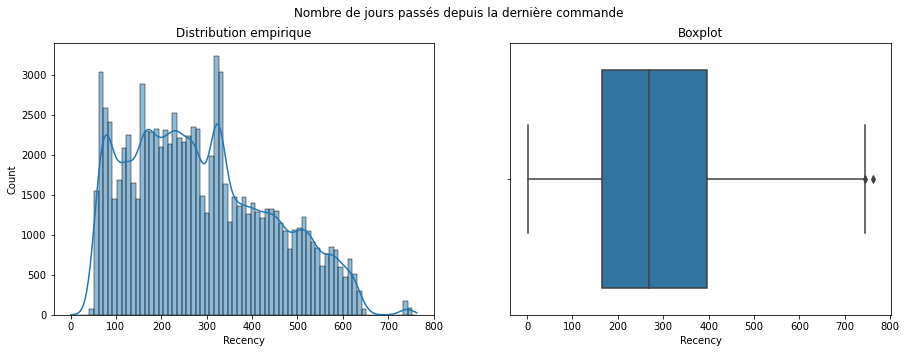

In [55]:
plots_uniVariable(data, 'Recency', 'Nombre de jours passés depuis la dernière commande', 
                  'Distribution empirique', 'Boxplot')

In [47]:
data[['Recency', 'Frequency', 'MonetaryValue']].loc[data['Recency'] > 750]

Recency  Frequency  MonetaryValue
20181      763          3          47.82

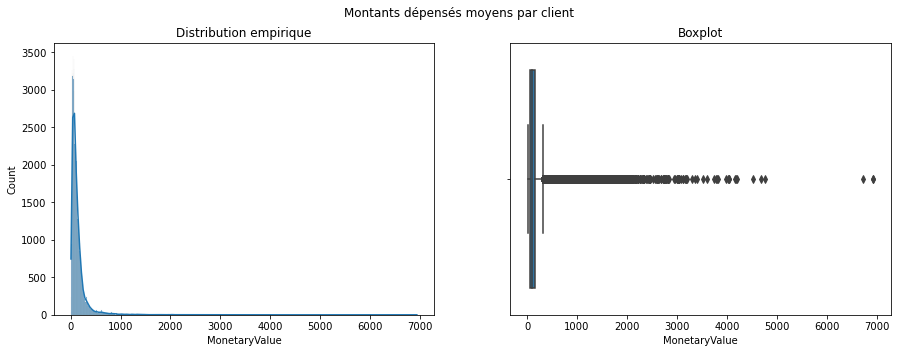

In [54]:
plots_uniVariable(data, 'MonetaryValue', 'Montants dépensés moyens par client', 'Distribution empirique', 'Boxplot')


In [44]:
data[['Recency', 'Frequency', 'MonetaryValue']].loc[data['MonetaryValue'] > 4000]

Recency  Frequency  MonetaryValue
3739       511          1        6726.66
5670       203          1        4175.26
11554      547          1        4764.34
12887      612          1        6929.31
20221       84          1        6922.21
36535      135          2        4034.44
38618      118          1        4681.78
60752       75          1        4513.32
68729      620          1        4042.74
78428      578          1        4016.91
84216       81          1        4163.51
91612      547          2        4194.76

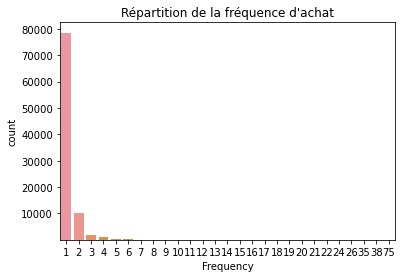

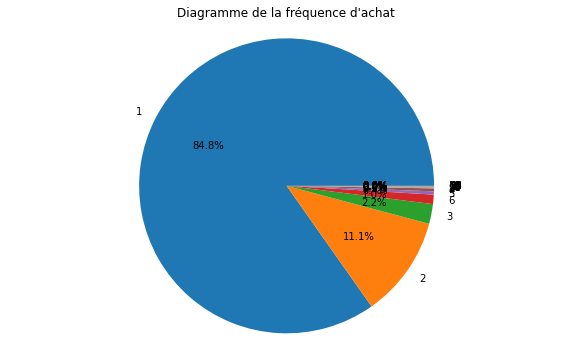

In [74]:
sns.countplot(x='Frequency', data=data)
plt.ylim(10)
plt.title("Répartition de la fréquence d'achat")
#plt.show()

plt.figure(figsize=(10, 6))
plt.pie(data['Frequency'].value_counts(), labels=data['Frequency'].unique(), autopct='%1.1f%%')
plt.axis('equal')
plt.title("Diagramme de la fréquence d'achat")
plt.show()

In [49]:
data[['Recency', 'Frequency', 'MonetaryValue']].loc[data['Frequency'] > 20]

Recency  Frequency  MonetaryValue
3942       585         35     175.919143
16010      639         24      77.900000
17377      366         24      79.085833
17877      435         75      56.716800
20365      159         24      37.050000
20555      314         22      40.850000
21502      327         24     107.850000
26012      246         24     439.720000
27954      468         24     164.610000
30844      264         21      60.242857
37350       71         24     193.995000
44631      458         21       9.341429
46421      390         38     102.870000
56185      498         26      62.680000
85399      128         21      36.940000

Les montants dépensés et la récence ne semblent pas être très discriminants. La plupart des clients réalise un seul achat. 

### 4.1.2 Analyse des variables qui peuvent être utiles pour la segmentation <a class="anchor" id="section_4.1.2"></a>

In [56]:
# Describe statistics 
data[['mean_real_delivery_time', 'review_score']].describe()

mean_real_delivery_time  review_score
count             92601.000000  92002.000000
mean                 11.672728      4.164312
std                   9.515167      1.278907
min                   1.000000      1.000000
25%                   6.000000      4.000000
50%                   9.000000      5.000000
75%                  15.000000      5.000000
max                 208.000000      5.000000

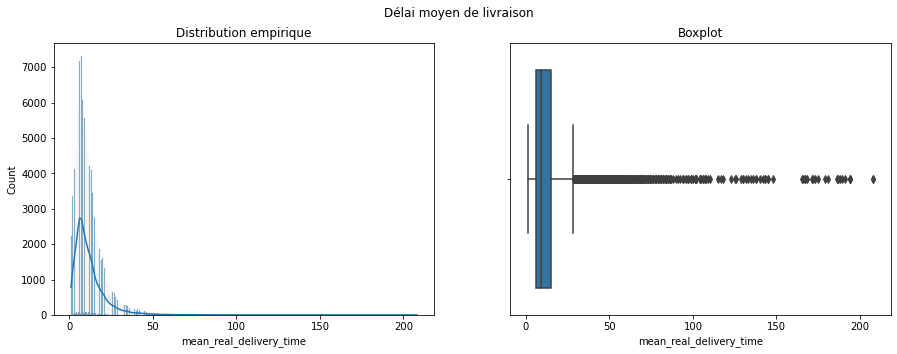

In [57]:
plots_uniVariable(data, 'mean_real_delivery_time', 'Délai moyen de livraison', 'Distribution empirique', 'Boxplot')

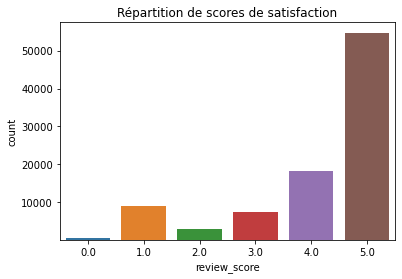

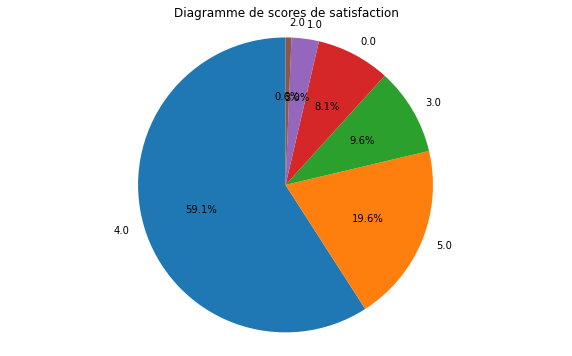

In [97]:
x = pd.DataFrame(data['review_score'])
x = x.fillna(0)

sns.countplot(x='review_score', data=x)
plt.ylim(10)
plt.title('Répartition de scores de satisfaction')

plt.figure(figsize=(10, 6))
plt.pie(x['review_score'].value_counts(), labels=x['review_score'].unique(), autopct='%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Diagramme de scores de satisfaction')
plt.show()

## 4.2 Analyses bivariées des variables utilisées pour la segmentation <a class="anchor" id="section_4.2"></a>

<AxesSubplot:>

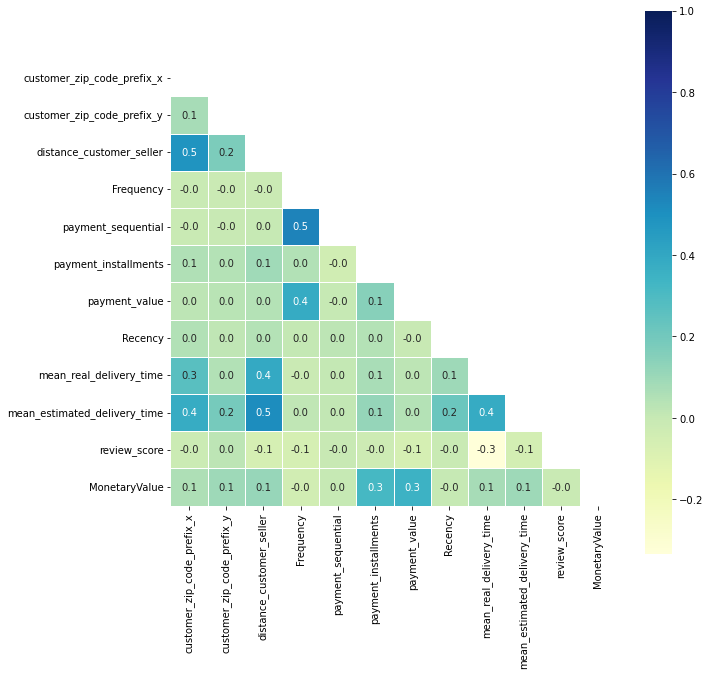

In [98]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.heatmap(corr, annot=True, cmap='YlGnBu', mask=mask, fmt='.1f', linewidths=.5, square=True, vmax=1)

Il n'y a pas de variables très corrélées.

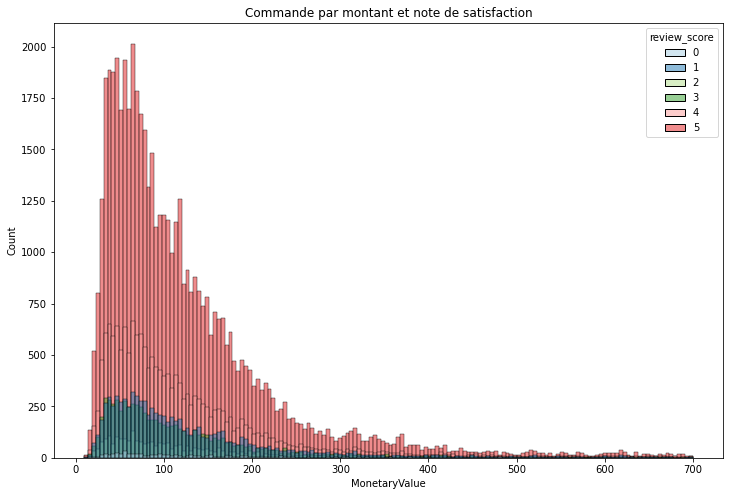

In [101]:
note = np.round(x['review_score']).astype(int)
#x = data.loc[data['mean_payment_value']<350, 'mean_payment_value']

plt.figure(figsize=(12, 8))
sns.histplot(x=data.loc[data['MonetaryValue']<700, 'MonetaryValue'], hue=note, palette='Paired')
plt.title('Montant par commande et note de satisfaction')
plt.show()